In [36]:
import os
import argparse
import pandas as pd
import yaml
import random
random.seed(100)
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

import os
import time
import tqdm
import pandas as pd
from copy import deepcopy
from typing import Dict

from sklearn.metrics import confusion_matrix

import math
import pickle

In [37]:
df_icu = pd.read_csv('ICUSTAYS.csv')
df_pat = pd.read_csv('PATIENTS.csv')
df_adm = pd.read_csv('ADMISSIONS.csv')
df_diag = pd.read_csv('DIAGNOSES_ICD.csv')
df_output_events = pd.read_csv('OUTPUTEVENTS.csv')
df_adm['DISCHTIME'].fillna('0',inplace=True)
df_icu.OUTTIME.fillna('0',inplace=True)

In [38]:
df_icu[df_icu.HADM_ID == 100001]
df_icu[df_icu.SUBJECT_ID == 20785]
# df_diag[(df_diag.SUBJECT_ID == 109) & (df_diag.HADM_ID == 183350)]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
28216,26364,20785,199993,271752,carevue,CSRU,CSRU,14,14,2161-10-23 18:01:44,2161-11-17 08:10:41,24.5895


In [39]:
import yaml

with open('hcup_ccs_2015_definitions.yaml', 'r') as file:
    data = yaml.load(file, Loader=yaml.FullLoader)



In [40]:
count = 0
phenotype = {}
for k, v in data.items():
    if v['use_in_benchmark']:
        phenotype[k] = v['codes']
        count +=1
count

25

In [41]:
df_mer = pd.merge(df_adm, df_icu, on = 'HADM_ID')
select_one_icu_per_hadm = df_mer.groupby('HADM_ID')['HADM_ID'].count() == 1
print(select_one_icu_per_hadm.head())
select_one_icu_per_hadm = list(select_one_icu_per_hadm[select_one_icu_per_hadm == True].index)

HADM_ID
100001    True
100003    True
100006    True
100007    True
100009    True
Name: HADM_ID, dtype: bool


In [42]:
pat_one_icu_per_hadm = set(list(df_adm[df_adm['HADM_ID'].isin(select_one_icu_per_hadm)]['SUBJECT_ID']))
len(pat_one_icu_per_hadm)

44471

In [43]:
# df_icu[df_icu.HADM_ID == 100001]
sample = list(df_diag[(df_diag.SUBJECT_ID == 58526) & (df_diag.HADM_ID == 100001)]['ICD9_CODE'])

In [44]:
def code_in_phenotype(phenotype, code):

    for k, v in phenotype.items():
        if code in v:    
            return k
        else: continue
    return 'OTHER'

def does_key_exist(values, list_codes):
    for v in values:
        if v in list_codes:
            return 1
    return 0
    


def icd_to_pheno(list_codes):
    pheno = []
    for k, v in phenotype.items():
        if does_key_exist(v, list_codes):
            pheno.append(1)
        else: 
            pheno.append(0)
    return pheno
    
        

code_in_phenotype(phenotype,'41071')    

'Acute myocardial infarction'

In [45]:
test = df_diag[(df_diag.SUBJECT_ID == 21219)]
test
icd_to_pheno(list(test['ICD9_CODE']))

[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [46]:
# list(df_output_events[df_output_events.SUBJECT_ID == 21219]['ITEMID'])
# list(df_output_events[df_output_events.SUBJECT_ID == 21219]['VALUE'])


In [47]:
t1 = df_diag.groupby(['SUBJECT_ID','HADM_ID'])['SEQ_NUM'].count()
t2 = pd.DataFrame(t1)
t3 = t2.groupby('SUBJECT_ID').count() == 1
ll = list(t3[t3['SEQ_NUM'] == True].index)
len(ll)

38983

In [48]:
len(df_diag)

651047

In [49]:
# df_output_events[df_output_events.SUBJECT_ID == 21219]['ITEMID'].unique()

df_output_events[df_output_events.SUBJECT_ID == 21219]['VALUE']

0          200.0
1          200.0
2          120.0
3          100.0
4          200.0
           ...  
2621430     80.0
2621431     80.0
2794781     45.0
2794782    100.0
2794783    100.0
Name: VALUE, Length: 424, dtype: float64

In [50]:
df_diag[df_diag.SUBJECT_ID == 21219]

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
214657,236658,21219,177991,1.0,51881
214658,236659,21219,177991,2.0,4280
214659,236660,21219,177991,3.0,515
214660,236661,21219,177991,4.0,41071
214661,236662,21219,177991,5.0,42731
214662,236663,21219,177991,6.0,4821
214663,236664,21219,177991,7.0,0389
214664,236665,21219,177991,8.0,5939
214665,236666,21219,177991,9.0,7921


In [51]:
df_output_events.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,ITEMID,VALUE,VALUEUOM,STORETIME,CGID,STOPPED,NEWBOTTLE,ISERROR
0,344,21219,177991.0,225765.0,2142-09-08 10:00:00,40055,200.0,ml,2142-09-08 12:08:00,17269,NaN,NaN,NaN
1,345,21219,177991.0,225765.0,2142-09-08 12:00:00,40055,200.0,ml,2142-09-08 12:08:00,17269,NaN,NaN,NaN
2,346,21219,177991.0,225765.0,2142-09-08 13:00:00,40055,120.0,ml,2142-09-08 13:39:00,17269,NaN,NaN,NaN
3,347,21219,177991.0,225765.0,2142-09-08 14:00:00,40055,100.0,ml,2142-09-08 16:17:00,17269,NaN,NaN,NaN
4,348,21219,177991.0,225765.0,2142-09-08 16:00:00,40055,200.0,ml,2142-09-08 16:17:00,17269,NaN,NaN,NaN


In [52]:
len(pat_one_icu_per_hadm)
# list(df_output_events[df_output_events.SUBJECT_ID == 1]['VALUE'])

44471

In [53]:
Y = []
X = []
X_val = []
X_item = []
for p in pat_one_icu_per_hadm:
    x_val = list(df_output_events[df_output_events.SUBJECT_ID == p]['VALUE'])
    if len(x_val) > 0:
        test = df_diag[(df_diag.SUBJECT_ID == p)]
        y = icd_to_pheno(list(test['ICD9_CODE']))
        Y.append(y)
        x_item = list(df_output_events[df_output_events.SUBJECT_ID == p]['ITEMID'])
        X_val.append(x_val)
        X_item.append(x_item)
        result = np.array([np.array(x_item), np.array(x_val)]).transpose()
        X.append(result)
#         result = np.column_stack((a, b))
    else: continue

In [54]:
print("Patient ID:", list(pat_one_icu_per_hadm)[3])
print("Phenotype:", Y[3])
print("# of tests:", len(X[3]))
print(X[3].shape, len(X[3]))
all_sizes = [len(x) for x in X]
max(all_sizes)

Patient ID: 5
Phenotype: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# of tests: 5
(5, 2) 5


7118

In [90]:
min_test_size = 100
len(Y), len(X), len(np.where(np.array(all_sizes) > min_test_size)[0])


(39902, 39902, 10132)

In [91]:
# patients more than 100 features
idx = np.where(np.array(all_sizes) > min_test_size)[0]
Y_new = [item for i, item in enumerate(Y) if i not in idx]
X_new = [item for i, item in enumerate(X) if i not in idx]
len(Y_new), len(X_new)

(29770, 29770)

In [92]:
new_sizes = [len(x) for x in X_new]
max_size = max(new_sizes)
max_size

100

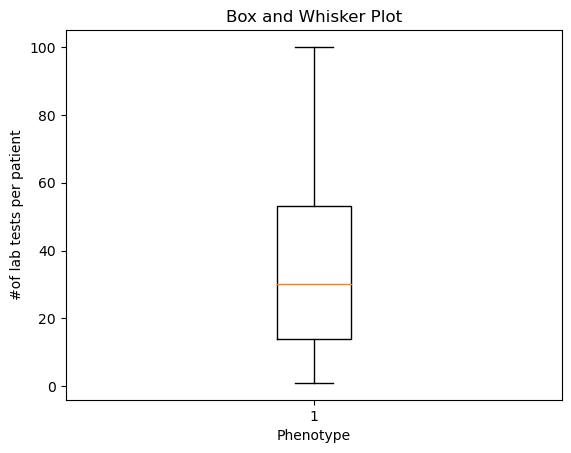

In [93]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

# Creating dataset
data = new_sizes

# Create a figure and axis
fig, ax = plt.subplots()

# Create a box and whisker plot
ax.boxplot(data)
ax.set_title('Box and Whisker Plot')
ax.set_xlabel('Phenotype')
ax.set_ylabel('#of lab tests per patient')

# show plot
plt.show()


In [88]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    
    def __init__(self, tests, pheno):
        
        """
        TODO: Store `seqs`. to `self.x` and `hfs` to `self.y`.
        
        Note that you DO NOT need to covert them to tensor as we will do this later.
        Do NOT permute the data.
        """
        
        # your code here
        self.x = tests
        self.y = pheno
#         raise NotImplementedError
    
    def __len__(self):
        
        """
        TODO: Return the number of samples (i.e. patients).
        """
        
        # your code here
        return len(self.y)
#         raise NotImplementedError
    
    def __getitem__(self, index):
        
        """
        TODO: Generates one sample of data.
        
        Note that you DO NOT need to covert them to tensor as we will do this later.
        """
        
        # your code here
        test = self.x[index]
        pheno = self.y[index]

        return test, pheno
#         raise NotImplementedError
        

dataset = CustomDataset(X_new, Y_new)

In [60]:
def collate_fn(data):
    
    sequences, pheno = zip(*data)
    y = torch.tensor(pheno, dtype=torch.float)
    num_patients = len(sequences)
#     print(num_patients)
#     print(max_num_visits, max_num_codes, len(y) )
#     x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
    x = torch.full((len(sequences), max_size, 2), 1e-10)
    for i_patient, patient in enumerate(sequences):
        x[i_patient, :len(patient), :] = torch.tensor(patient)
    return x, y

In [61]:
from torch.utils.data.dataset import random_split

split = int(len(dataset)*0.7)

lengths = [split, len(dataset) - split]
train_dataset, val_test_dataset = random_split(dataset, lengths)

split = int(len(val_test_dataset)*0.7)
lengths = [split, len(val_test_dataset) - split]
val_dataset, test_dataset = random_split(val_test_dataset, lengths)

print("Length of train dataset:", len(train_dataset))
print("Length of val dataset:", len(val_dataset))
print("Length of test dataset:", len(test_dataset))

Length of train dataset: 20839
Length of val dataset: 6251
Length of test dataset: 2680


In [62]:
from torch.utils.data import DataLoader

def load_data(train_dataset, val_dataset, test_dataset, batch_size, collate_fn):
    
    '''
    TODO: Implement this function to return the data loader for  train and validation dataset. 
    Set batchsize to 32. Set `shuffle=True` only for train dataloader.
    
    Arguments:
        train dataset: train dataset of type `CustomDataset`
        val dataset: validation dataset of type `CustomDataset`
        collate_fn: collate function
        
    Outputs:
        train_loader, val_loader: train and validation dataloaders
    
    Note that you need to pass the collate function to the data loader `collate_fn()`.
    '''
    
    batch_size = batch_size
    # your code here
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)
#     raise NotImplementedError
    
    return train_loader, val_loader, test_loader


batch_size = 128
train_loader, val_loader, test_loader = load_data(train_dataset, val_dataset, test_dataset, batch_size, collate_fn)

In [63]:
loader_iter = iter(test_loader)
x, y = next(loader_iter)
x.shape

for x, y in test_loader:
    print(x.shape, y.shape)

torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([128, 100, 2]) torch.Size([128, 25])
torch.Size([120, 100, 2]) torch.Size([12

In [65]:
from torch.autograd import Variable

class MyNeuralNetworkClassifier:
    def __init__(self, model, criterion, optimizer, optimizer_config: dict) -> None:
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.optimizer = optimizer(self.model.parameters(), **optimizer_config)
        self.criterion = criterion

        self.hyper_params = optimizer_config
        self._start_epoch = 0
        self.hyper_params["epochs"] = self._start_epoch
        self.__num_classes = None
        self._is_parallel = False

        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)
            self._is_parallel = True

            notice = "Running on {} GPUs.".format(torch.cuda.device_count())
            print("\033[33m" + notice + "\033[0m")
            
    def fit(self, loader: Dict[str, DataLoader], epochs: int, checkpoint_path: str = None, validation: bool = True) -> None:
        len_of_train_dataset = len(loader["train"].dataset)
        epochs = epochs + self._start_epoch

        self.hyper_params["epochs"] = epochs
        self.hyper_params["batch_size"] = loader["train"].batch_size
        self.hyper_params["train_ds_size"] = len_of_train_dataset
        
       
        
        if validation:
            len_of_val_dataset = len(loader["val"].dataset)
            self.hyper_params["val_ds_size"] = len_of_val_dataset
            
        for epoch in range(self._start_epoch, epochs):
            if checkpoint_path is not None and epoch % 100 == 0:
                self.save_to_file(checkpoint_path)
            correct = 0.0
            total = 0.0
            
            self.model.train()
            pbar = tqdm.tqdm(total=len_of_train_dataset)
            for x, y in loader["train"]:
#                 print(x.shape, y.shape)
                b_size = y.shape[0]
                total += y.shape[0]
                x = x.to(self.device) if isinstance(x, torch.Tensor) else [i.to(self.device) for i in x]
                y = y.to(self.device)

                pbar.set_description(
                    "\033[36m" + "Training" + "\033[0m" + " - Epochs: {:03d}/{:03d}".format(epoch+1, epochs)
                )
                pbar.update(b_size)

                self.optimizer.zero_grad()
#                 print("Here1")
                outputs = self.model(x)
#                 print("Here2")
#                 print(outputs.shape, y.shape)
                a =  outputs > 0
                predicted = torch.where(a, torch.tensor(1, dtype=torch.float64), torch.tensor(0, dtype=torch.float64))
                
                loss = self.criterion(predicted, y)
#                 loss = self.criterion(outputs, y)
                print("Training loss", loss.item())
                loss = Variable(loss, requires_grad = True)
                loss.backward()
                self.optimizer.step()
                
#                 _, predicted = torch.max(outputs, 1)
#                 print("predicted, y, int_tensor", predicted.shape, y.shape, int_tensor.shape)
                correct += (predicted == y).sum().float().cpu().item()

                
    def evaluate(self, loader: DataLoader, verbose: bool = False) -> None or float:

        running_loss = 0.0
        running_corrects = 0.0
        pbar = tqdm.tqdm(total=len(loader.dataset))

        self.model.eval()
        print("test_ds_size", len(loader.dataset))



        with torch.no_grad():
            correct = 0.0
            total = 0.0
#                 for x, y in enumerate(loader): SAYAN
            for x, y in loader:
#                 print("Here is type & shape", type(y), y.shape)
                b_size = y.shape[0]
                total += y.shape[0]
                x = x.to(self.device) if isinstance(x, torch.Tensor) else [i.to(self.device) for i in x]
                y = y.to(self.device)

                pbar.set_description("\033[32m"+"Evaluating"+"\033[0m")
                pbar.update(b_size)

                outputs = self.model(x)
                a =  outputs > 0
                predicted = torch.where(a, torch.tensor(1, dtype=torch.float64), torch.tensor(0, dtype=torch.float64))
#                 loss = self.criterion(outputs, y)
                loss = self.criterion(predicted, y)
                loss = Variable(loss, requires_grad = True)
#                 _, predicted = torch.max(outputs, 1)
                
                correct += (predicted == y).sum().float().cpu().item()

                running_loss += loss.cpu().item()
                running_corrects += torch.sum(predicted == y).float().cpu().item()
                print("loss", running_loss)
                acc = float(running_corrects / (total * 25))
                print("accuracy", acc)
            pbar.close()
#         acc = self.experiment.get_metric("accuracy")

        print("\033[33m" + "Evaluation finished. " + "\033[0m" + "Accuracy: {:.4f}".format(acc))

        if verbose:
            return acc

 
    def save_checkpoint(self) -> dict:
        """
        The method of saving trained PyTorch model.

        Note,  return value contains
            - the number of last epoch as `epochs`
            - optimizer state as `optimizer_state_dict`
            - model state as `model_state_dict`

        ::

            clf = NeuralNetworkClassifier(
                    Network(), nn.CrossEntropyLoss(),
                    optim.Adam, optimizer_config, experiment
                )

            clf.fit(train_loader, epochs=10)
            checkpoints = clf.save_checkpoint()

        :return: dict {'epoch', 'optimizer_state_dict', 'model_state_dict'}
        """

        checkpoints = {
            "epoch": deepcopy(self.hyper_params["epochs"]),
            "optimizer_state_dict": deepcopy(self.optimizer.state_dict())
        }

        if self._is_parallel:
            checkpoints["model_state_dict"] = deepcopy(self.model.module.state_dict())
        else:
            checkpoints["model_state_dict"] = deepcopy(self.model.state_dict())

        return checkpoints

    def save_to_file(self, path: str) -> str:
        """
        | The method of saving trained PyTorch model to file.
        | Those weights are uploaded to comet.ml as backup.
        | check "Asserts".

        Note, .pth file contains
            - the number of last epoch as `epochs`
            - optimizer state as `optimizer_state_dict`
            - model state as `model_state_dict`

        ::

            clf = NeuralNetworkClassifier(
                    Network(), nn.CrossEntropyLoss(),
                    optim.Adam, optimizer_config, experiment
                )

            clf.fit(train_loader, epochs=10)
            filename = clf.save_to_file('path/to/save/dir/')

        :param path: path to saving directory. : string
        :return: path to file : string
        """
        if not os.path.isdir(path):
            os.mkdir(path)

        file_name = "model_params-epochs_{}-{}.pth".format(
            self.hyper_params["epochs"], time.ctime().replace(" ", "_")
        )
        path = path + file_name

        checkpoints = self.save_checkpoint()

        torch.save(checkpoints, path)
#         self.experiment.log_asset(path, file_name=file_name)

        return path
        

In [66]:

class PositionWiseFeedForward(nn.Module):
    def __init__(self, hidden_size: int) -> None:
        super(PositionWiseFeedForward, self).__init__()
        self.hidden_size = hidden_size

        self.conv = nn.Sequential(
            nn.Conv1d(hidden_size, hidden_size * 2, 1),
            nn.ReLU(),
            nn.Conv1d(hidden_size * 2, hidden_size, 1)
        )

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        tensor = tensor.transpose(1, 2)
        tensor = self.conv(tensor)
        tensor = tensor.transpose(1, 2)

        return tensor




class PositionalEncoding(nn.Module):
    def __init__(self, d_model, seq_len) -> None:
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

        pe = torch.zeros(seq_len, d_model)

        for pos in range(seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i+1] = math.cos(pos / (10000 ** ((2 * (i+1)) / d_model)))

        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x) -> torch.Tensor:
        seq_len = x.shape[1]
        x = math.sqrt(self.d_model) * x
        x = x + self.pe[:, :seq_len].requires_grad_(False)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, embed_dim: int, num_head: int, dropout_rate=0.1) -> None:
        super(EncoderBlock, self).__init__()
        self.attention = ResidualBlock(
            nn.MultiheadAttention(embed_dim, num_head), embed_dim, p=dropout_rate
        )
        self.ffn = ResidualBlock(PositionWiseFeedForward(embed_dim), embed_dim, p=dropout_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
#         print("EncoderBlock", x.shape)
        x = self.attention(x)
        x = self.ffn(x)
        return x



class ResidualBlock(nn.Module):
    def __init__(self, layer: nn.Module, embed_dim: int, p=0.1) -> None:
        super(ResidualBlock, self).__init__()
        self.layer = layer
        self.dropout = nn.Dropout(p=p)
        self.norm = nn.LayerNorm(embed_dim)
        self.attn_weights = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param x: [N, seq_len, features]
        :return: [N, seq_len, features]
        """
        if isinstance(self.layer, nn.MultiheadAttention):
            src = x.transpose(0, 1)     # [seq_len, N, features]
            output, self.attn_weights = self.layer(src, src, src)
            output = output.transpose(0, 1)     # [N, seq_len, features]

        else:
            output = self.layer(x)

        output = self.dropout(output)
        output = self.norm(x + output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, seq_len) -> None:
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

        pe = torch.zeros(seq_len, d_model)

        for pos in range(seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i+1] = math.cos(pos / (10000 ** ((2 * (i+1)) / d_model)))

        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x) -> torch.Tensor:
        seq_len = x.shape[1]
        x = math.sqrt(self.d_model) * x
        x = x + self.pe[:, :seq_len].requires_grad_(False)
        return x 

class EncoderLayerForSAnD(nn.Module):
    def __init__(self, input_features, seq_len, n_heads, n_layers, d_model=128, dropout_rate=0.2) -> None:
        super(EncoderLayerForSAnD, self).__init__()
        self.d_model = d_model

        self.input_embedding = nn.Conv1d(input_features, d_model, 1)
        self.positional_encoding = PositionalEncoding(d_model, seq_len)
        self.blocks = nn.ModuleList([
            EncoderBlock(d_model, n_heads, dropout_rate) for _ in range(n_layers)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = x.transpose(1, 2)
#         print(x.type())
        x = self.input_embedding(x)
        x = x.transpose(1, 2)

        x = self.positional_encoding(x)

        for l in self.blocks:
            x = l(x)

        return x

class DenseInterpolation(nn.Module):
    def __init__(self, seq_len: int, factor: int) -> None:
        """
        :param seq_len: sequence length
        :param factor: factor M
        """
        super(DenseInterpolation, self).__init__()

        W = np.zeros((factor, seq_len), dtype=np.float32)

        for t in range(seq_len):
            s = np.array((factor * (t + 1)) / seq_len, dtype=np.float32)
            for m in range(factor):
                tmp = np.array(1 - (np.abs(s - (1+m)) / factor), dtype=np.float32)
                w = np.power(tmp, 2, dtype=np.float32)
                W[m, t] = w

        W = torch.tensor(W).float().unsqueeze(0)
        self.register_buffer("W", W)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        w = self.W.repeat(x.shape[0], 1, 1).requires_grad_(False)
        u = torch.bmm(w, x)
        return u.transpose_(1, 2)

    

class ClassificationModule(nn.Module):
    def __init__(self, d_model: int, factor: int, num_class: int) -> None:
        super(ClassificationModule, self).__init__()
        self.d_model = d_model
        self.factor = factor
        self.num_class = num_class

        self.fc = nn.Linear(int(d_model * factor), num_class)
        self.sm = nn.Softmax()

        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.contiguous().view(-1, int(self.factor * self.d_model))
        x = self.fc(x)
        return x

    

class RegressionModule(nn.Module):
    def __init__(self, d_model: int, factor: int, output_size: int) -> None:
        super(RegressionModule, self).__init__()
        self.d_model = d_model
        self.factor = factor
        self.output_size = output_size
        self.fc = nn.Linear(int(d_model * factor), output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.contiguous().view(-1, int(self.factor * self.d_model))
        x = self.fc(x)
        return x


In [67]:
class SAnD(nn.Module):

    def __init__(
            self, input_features: int, seq_len: int, n_heads: int, factor: int,
            n_class: int, n_layers: int, d_model: int = 128, dropout_rate: float = 0.2
    ) -> None:
        super(SAnD, self).__init__()
        self.encoder = EncoderLayerForSAnD(input_features, seq_len, n_heads, n_layers, d_model, dropout_rate)
        self.dense_interpolation = DenseInterpolation(seq_len, factor)
        self.clf = ClassificationModule(d_model, factor, n_class)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.dense_interpolation(x)
        x = self.clf(x)
        return x

In [68]:
clf = MyNeuralNetworkClassifier(
    SAnD(in_feature, seq_len, n_heads, factor, num_class, num_layers),
    nn.CrossEntropyLoss(),
    optim.Adam, optimizer_config={"lr": 1e-5, "betas": (0.9, 0.98), "eps": 4e-09, "weight_decay": 5e-4},
)


In [69]:
# training network
clf.fit(
    {"train": train_loader,
     "val": val_loader},
     epochs= 2
)

Training - Epochs: 001/002:   2%|▋                                   | 384/20839 [00:00<00:19, 1072.14it/s]

Training loss 11.227495107108155
Training loss 12.506911880595398


Training - Epochs: 001/002:   3%|█                                   | 640/20839 [00:00<00:18, 1108.47it/s]

Training loss 11.762095652644584
Training loss 10.55696009167896


Training - Epochs: 001/002:   4%|█▌                                  | 896/20839 [00:00<00:18, 1081.70it/s]

Training loss 10.363225237971909
Training loss 12.129054449112568


Training - Epochs: 001/002:   6%|██▏                                | 1280/20839 [00:01<00:16, 1214.95it/s]

Training loss 11.602589572865643
Training loss 11.47513809688621
Training loss 11.403276105640181


Training - Epochs: 001/002:   7%|██▌                                | 1536/20839 [00:01<00:16, 1198.43it/s]

Training loss 11.404423922687034
Training loss 12.40628653568106


Training - Epochs: 001/002:   9%|███                                | 1792/20839 [00:01<00:15, 1203.19it/s]

Training loss 13.144576688834992
Training loss 12.284268904888865


Training - Epochs: 001/002:  10%|███▍                               | 2048/20839 [00:01<00:16, 1124.95it/s]

Training loss 12.537742816927683
Training loss 11.929406709800077


Training - Epochs: 001/002:  11%|███▊                               | 2304/20839 [00:02<00:17, 1074.49it/s]

Training loss 10.289051799718951
Training loss 11.870927209464561


Training - Epochs: 001/002:  12%|████▎                              | 2560/20839 [00:02<00:16, 1104.06it/s]

Training loss 9.965655514248173
Training loss 11.584864239980702
Training loss 9.90773833136113


Training - Epochs: 001/002:  15%|█████▏                             | 3072/20839 [00:02<00:14, 1258.04it/s]

Training loss 11.855688000512497
Training loss 11.103609656344984
Training loss 12.746232223899852


Training - Epochs: 001/002:  16%|█████▌                             | 3328/20839 [00:02<00:13, 1277.08it/s]

Training loss 10.414401099476315
Training loss 11.756877202225159


Training - Epochs: 001/002:  17%|██████                             | 3584/20839 [00:03<00:14, 1227.84it/s]

Training loss 11.968307581266032
Training loss 12.542997514844341


Training - Epochs: 001/002:  18%|██████▍                            | 3840/20839 [00:03<00:13, 1236.80it/s]

Training loss 12.551194368758907
Training loss 11.002825361364


Training - Epochs: 001/002:  20%|██████▉                            | 4096/20839 [00:03<00:13, 1246.66it/s]

Training loss 11.396855233310156
Training loss 12.437756670892368


Training - Epochs: 001/002:  21%|███████▎                           | 4352/20839 [00:03<00:13, 1219.19it/s]

Training loss 11.548211493349415
Training loss 12.783112924400402


Training - Epochs: 001/002:  22%|███████▋                           | 4608/20839 [00:03<00:13, 1185.29it/s]

Training loss 11.851546052747453
Training loss 12.43851818086614


Training - Epochs: 001/002:  23%|████████▏                          | 4864/20839 [00:04<00:13, 1220.27it/s]

Training loss 11.731376441688958
Training loss 11.469332605817385


Training - Epochs: 001/002:  25%|████████▌                          | 5120/20839 [00:04<00:14, 1050.31it/s]

Training loss 11.161123281594609
Training loss 12.710437445766992


Training - Epochs: 001/002:  26%|█████████▎                          | 5376/20839 [00:04<00:16, 938.31it/s]

Training loss 10.844967661378295
Training loss 11.348757952767313


Training - Epochs: 001/002:  27%|█████████▋                          | 5632/20839 [00:04<00:16, 949.43it/s]

Training loss 11.334360073065486
Training loss 10.594918160738851


Training - Epochs: 001/002:  28%|██████████▏                         | 5888/20839 [00:05<00:15, 939.84it/s]

Training loss 11.91841588264138
Training loss 11.584195809247394


Training - Epochs: 001/002:  29%|██████████▌                         | 6144/20839 [00:05<00:15, 942.76it/s]

Training loss 10.716390791861784
Training loss 11.66055666333244


Training - Epochs: 001/002:  31%|██████████▋                        | 6400/20839 [00:05<00:13, 1036.20it/s]

Training loss 11.25679567732445
Training loss 10.55588860036913


Training - Epochs: 001/002:  32%|███████████▏                       | 6656/20839 [00:05<00:13, 1065.75it/s]

Training loss 11.557301790810403
Training loss 10.486471207825904


Training - Epochs: 001/002:  33%|███████████▌                       | 6912/20839 [00:06<00:12, 1110.75it/s]

Training loss 11.99031567109581
Training loss 12.453847676179107


Training - Epochs: 001/002:  34%|████████████                       | 7168/20839 [00:06<00:12, 1113.23it/s]

Training loss 10.304857773097712
Training loss 11.85704856699463


Training - Epochs: 001/002:  36%|████████████▍                      | 7424/20839 [00:06<00:11, 1128.89it/s]

Training loss 11.57131418935813
Training loss 10.91620196257911


Training - Epochs: 001/002:  37%|████████████▉                      | 7680/20839 [00:06<00:11, 1157.60it/s]

Training loss 11.952921846800473
Training loss 11.331299803349282


Training - Epochs: 001/002:  38%|█████████████▎                     | 7936/20839 [00:07<00:11, 1089.98it/s]

Training loss 11.646161975254413
Training loss 11.944299436845542


Training - Epochs: 001/002:  39%|██████████████▏                     | 8192/20839 [00:07<00:12, 986.29it/s]

Training loss 11.291513030329645
Training loss 10.732861323504633


Training - Epochs: 001/002:  41%|██████████████▌                     | 8448/20839 [00:07<00:12, 982.18it/s]

Training loss 10.41596836970677
Training loss 11.418035178971978


Training - Epochs: 001/002:  42%|██████████████▌                    | 8704/20839 [00:07<00:11, 1030.47it/s]

Training loss 12.383826701596327
Training loss 10.505919036682974


Training - Epochs: 001/002:  43%|███████████████                    | 8960/20839 [00:08<00:11, 1013.97it/s]

Training loss 12.477227567067182
Training loss 10.765950414666701


Training - Epochs: 001/002:  44%|███████████████▍                   | 9216/20839 [00:08<00:10, 1072.67it/s]

Training loss 11.894068209101238
Training loss 11.951425083711758


Training - Epochs: 001/002:  45%|███████████████▉                   | 9472/20839 [00:08<00:11, 1019.86it/s]

Training loss 11.810953477995053
Training loss 12.60515974126443


Training - Epochs: 001/002:  47%|████████████████▎                  | 9728/20839 [00:08<00:11, 1002.12it/s]

Training loss 10.851404938441043
Training loss 11.025982603344662


Training - Epochs: 001/002:  48%|█████████████████▏                  | 9984/20839 [00:09<00:11, 953.18it/s]

Training loss 13.06138053573499
Training loss 13.538801147229053


Training - Epochs: 001/002:  49%|████████████████▋                 | 10240/20839 [00:09<00:10, 1048.30it/s]

Training loss 11.845658740858147
Training loss 11.277365118356428


Training - Epochs: 001/002:  50%|█████████████████                 | 10496/20839 [00:09<00:09, 1116.67it/s]

Training loss 12.019120293644578
Training loss 10.317773650322248


Training - Epochs: 001/002:  52%|█████████████████▌                | 10752/20839 [00:09<00:09, 1070.90it/s]

Training loss 10.868581008769016
Training loss 12.126139905386477


Training - Epochs: 001/002:  53%|█████████████████▉                | 11008/20839 [00:10<00:08, 1113.13it/s]

Training loss 13.244626409502747
Training loss 12.221350075132605


Training - Epochs: 001/002:  54%|██████████████████▍               | 11264/20839 [00:10<00:08, 1166.69it/s]

Training loss 11.14320315414587
Training loss 11.895947772912479


Training - Epochs: 001/002:  55%|██████████████████▊               | 11520/20839 [00:10<00:08, 1076.67it/s]

Training loss 12.817385724727124
Training loss 10.233944663904873


Training - Epochs: 001/002:  57%|███████████████████▊               | 11776/20839 [00:10<00:09, 964.03it/s]

Training loss 10.673522633472697
Training loss 12.280728146667583


Training - Epochs: 001/002:  58%|███████████████████▋              | 12032/20839 [00:11<00:08, 1032.88it/s]

Training loss 12.02069129107784
Training loss 10.025248898557063


Training - Epochs: 001/002:  59%|████████████████████              | 12288/20839 [00:11<00:07, 1106.60it/s]

Training loss 11.487983049640716
Training loss 11.34732551275999


Training - Epochs: 001/002:  60%|████████████████████▍             | 12544/20839 [00:11<00:07, 1075.01it/s]

Training loss 11.044436540902879
Training loss 11.168917991196908


Training - Epochs: 001/002:  61%|████████████████████▉             | 12800/20839 [00:11<00:07, 1063.84it/s]

Training loss 10.546759914588122
Training loss 10.919278916796586


Training - Epochs: 001/002:  63%|█████████████████████▎            | 13056/20839 [00:12<00:07, 1077.68it/s]

Training loss 11.030636670206906
Training loss 11.294117640547679


Training - Epochs: 001/002:  64%|█████████████████████▋            | 13312/20839 [00:12<00:06, 1116.13it/s]

Training loss 11.198232065748826
Training loss 10.445069479957763


Training - Epochs: 001/002:  65%|██████████████████████▏           | 13568/20839 [00:12<00:06, 1085.40it/s]

Training loss 12.456987173055808
Training loss 12.500255532548225


Training - Epochs: 001/002:  66%|██████████████████████▌           | 13824/20839 [00:12<00:06, 1124.58it/s]

Training loss 11.928098133167023
Training loss 13.142008152721822


Training - Epochs: 001/002:  68%|██████████████████████▉           | 14080/20839 [00:12<00:06, 1104.76it/s]

Training loss 11.226846306343411
Training loss 11.140413256084418


Training - Epochs: 001/002:  69%|███████████████████████▍          | 14336/20839 [00:13<00:05, 1147.32it/s]

Training loss 12.344398513341778
Training loss 11.773075127060316


Training - Epochs: 001/002:  71%|████████████████████████          | 14720/20839 [00:13<00:05, 1207.73it/s]

Training loss 10.738842100579426
Training loss 12.393443361585195
Training loss 11.343569647849826


Training - Epochs: 001/002:  72%|████████████████████████▍         | 14976/20839 [00:13<00:04, 1224.20it/s]

Training loss 10.99646221182886
Training loss 11.078384194168358


Training - Epochs: 001/002:  73%|████████████████████████▊         | 15232/20839 [00:13<00:04, 1221.56it/s]

Training loss 12.913628064525648
Training loss 11.280400603123795


Training - Epochs: 001/002:  74%|█████████████████████████▎        | 15488/20839 [00:14<00:04, 1114.88it/s]

Training loss 10.22679939646281
Training loss 11.676969229237772


Training - Epochs: 001/002:  76%|█████████████████████████▋        | 15744/20839 [00:14<00:04, 1096.18it/s]

Training loss 11.615110383387073
Training loss 10.921534766654908


Training - Epochs: 001/002:  77%|██████████████████████████        | 16000/20839 [00:14<00:04, 1138.95it/s]

Training loss 10.626722414445876
Training loss 10.687194743836645


Training - Epochs: 001/002:  78%|██████████████████████████▌       | 16256/20839 [00:14<00:03, 1156.96it/s]

Training loss 10.917492755392395
Training loss 11.44408814942602


Training - Epochs: 001/002:  79%|██████████████████████████▉       | 16512/20839 [00:14<00:03, 1249.93it/s]

Training loss 10.096304999109197
Training loss 10.74936923405409
Training loss 12.208258716377658


Training - Epochs: 001/002:  80%|███████████████████████████▏      | 16640/20839 [00:15<00:03, 1224.36it/s]

Training loss 10.83438386227259


Training - Epochs: 001/002:  82%|███████████████████████████▊      | 17024/20839 [00:15<00:03, 1053.40it/s]

Training loss 12.577405137105142
Training loss 11.723039206945526


Training - Epochs: 001/002:  84%|████████████████████████████▍     | 17408/20839 [00:15<00:02, 1163.33it/s]

Training loss 12.045178491336257
Training loss 11.910165147325406
Training loss 12.072508960667031


Training - Epochs: 001/002:  85%|████████████████████████████▊     | 17664/20839 [00:16<00:02, 1198.37it/s]

Training loss 11.848041275834111
Training loss 12.197935859460074


Training - Epochs: 001/002:  87%|█████████████████████████████▍    | 18048/20839 [00:16<00:02, 1241.79it/s]

Training loss 10.222568410464559
Training loss 12.363545366653184
Training loss 11.560933701325519


Training - Epochs: 001/002:  88%|█████████████████████████████▊    | 18304/20839 [00:16<00:02, 1246.58it/s]

Training loss 11.2564460176139
Training loss 12.267640593611741


Training - Epochs: 001/002:  89%|██████████████████████████████▎   | 18560/20839 [00:16<00:01, 1274.88it/s]

Training loss 11.255750273141194
Training loss 12.47606198841895
Training loss 11.48014648433859


Training - Epochs: 001/002:  90%|██████████████████████████████▋   | 18816/20839 [00:17<00:01, 1303.76it/s]

Training loss 11.977541610673207
Training loss 10.51317761135956


Training - Epochs: 001/002:  92%|███████████████████████████████▎  | 19200/20839 [00:17<00:01, 1237.96it/s]

Training loss 12.602312292630264
Training loss 10.595629769748147


Training - Epochs: 001/002:  94%|███████████████████████████████▉  | 19584/20839 [00:17<00:01, 1254.76it/s]

Training loss 10.347426786048263
Training loss 10.290605379179954
Training loss 10.90719418593856


Training - Epochs: 001/002:  95%|████████████████████████████████▎ | 19840/20839 [00:17<00:00, 1235.57it/s]

Training loss 10.898576838465099
Training loss 12.365109227530061


Training - Epochs: 001/002:  96%|████████████████████████████████▊ | 20096/20839 [00:17<00:00, 1197.90it/s]

Training loss 10.782790663802295
Training loss 12.92313455624335


Training - Epochs: 001/002:  98%|█████████████████████████████████▏| 20352/20839 [00:18<00:00, 1141.91it/s]

Training loss 13.302807540502833
Training loss 11.043273908202675


Training - Epochs: 001/002: 100%|█████████████████████████████████▊| 20736/20839 [00:18<00:00, 1232.74it/s]

Training loss 11.606409516029766
Training loss 10.675644125118332
Training loss 10.469613233962976


Training - Epochs: 001/002: 100%|█████████████████████████████████▊| 20736/20839 [00:18<00:00, 1232.74it/s]

Training loss 12.381534064495378
Training loss 11.192250623343307



Training - Epochs: 001/002: 100%|██████████████████████████████████| 20839/20839 [00:18<00:00, 1113.16it/s]

Training - Epochs: 002/002:   1%|▍                                   | 256/20839 [00:00<00:08, 2503.08it/s]

Training loss 10.350811618828512



Training - Epochs: 002/002:   1%|▍                                   | 256/20839 [00:00<00:08, 2503.08it/s]

Training loss 10.744609962484661



Training - Epochs: 002/002:   2%|▉                                   | 512/20839 [00:00<00:13, 1524.79it/s]

Training loss 9.81617261385718
Training loss 11.404060066078884



Training - Epochs: 002/002:   4%|█▎                                  | 768/20839 [00:00<00:14, 1423.36it/s]

Training loss 10.868956659731968



Training - Epochs: 002/002:   5%|█▋                                 | 1024/20839 [00:00<00:13, 1422.94it/s]

Training loss 10.520685281674172
Training loss 12.62870745133996



Training - Epochs: 002/002:   5%|█▋                                 | 1024/20839 [00:00<00:13, 1422.94it/s]

Training loss 11.272110709004036



Training - Epochs: 002/002:   6%|██▏                                | 1280/20839 [00:00<00:14, 1378.83it/s]

Training loss 9.967095767849461



Training - Epochs: 002/002:   6%|██▏                                | 1280/20839 [00:00<00:14, 1378.83it/s]

Training loss 11.818792508381538



Training - Epochs: 002/002:   7%|██▌                                | 1536/20839 [00:01<00:15, 1240.45it/s]

Training loss 12.46198082455454



Training - Epochs: 002/002:   7%|██▌                                | 1536/20839 [00:01<00:15, 1240.45it/s]

Training loss 11.725725224347315



Training - Epochs: 002/002:   9%|███                                | 1792/20839 [00:01<00:16, 1161.75it/s]

Training loss 10.762795028736159



Training - Epochs: 002/002:   9%|███▏                               | 1920/20839 [00:01<00:16, 1148.40it/s]

Training loss 11.46640574214598



Training - Epochs: 002/002:  10%|███▍                               | 2048/20839 [00:01<00:16, 1147.60it/s]

Training loss 10.655076288128361



Training - Epochs: 002/002:  10%|███▋                               | 2176/20839 [00:01<00:17, 1091.80it/s]

Training loss 12.419604331980867



Training - Epochs: 002/002:  11%|███▊                               | 2304/20839 [00:01<00:16, 1130.11it/s]

Training loss 10.521046477296421



Training - Epochs: 002/002:  12%|████                               | 2432/20839 [00:01<00:15, 1161.63it/s]

Training loss 11.27577953589533



Training - Epochs: 002/002:  12%|████▎                              | 2560/20839 [00:02<00:15, 1184.01it/s]

Training loss 12.750287054589537



Training - Epochs: 002/002:  13%|████▌                              | 2688/20839 [00:02<00:15, 1202.04it/s]

Training loss 11.183787363798167



Training - Epochs: 002/002:  14%|████▋                              | 2816/20839 [00:02<00:15, 1185.48it/s]

Training loss 13.621514203996568



Training - Epochs: 002/002:  14%|████▉                              | 2944/20839 [00:02<00:15, 1178.89it/s]

Training loss 11.002635818392392



Training - Epochs: 002/002:  15%|█████▏                             | 3072/20839 [00:02<00:15, 1173.23it/s]

Training loss 11.995291569280274



Training - Epochs: 002/002:  15%|█████▎                             | 3200/20839 [00:02<00:15, 1163.23it/s]

Training loss 10.361947026428373



Training - Epochs: 002/002:  16%|█████▌                             | 3328/20839 [00:02<00:15, 1156.59it/s]

Training loss 11.302964288815735



Training - Epochs: 002/002:  17%|█████▊                             | 3456/20839 [00:02<00:14, 1168.80it/s]

Training loss 10.911603972913008



Training - Epochs: 002/002:  17%|██████                             | 3584/20839 [00:02<00:14, 1165.92it/s]

Training loss 11.460339103948197



Training - Epochs: 002/002:  18%|██████▏                            | 3712/20839 [00:03<00:15, 1134.72it/s]

Training loss 12.82647252352903



Training - Epochs: 002/002:  18%|██████▍                            | 3840/20839 [00:03<00:15, 1104.24it/s]

Training loss 11.176339695148721



Training - Epochs: 002/002:  19%|██████▋                            | 3968/20839 [00:03<00:15, 1102.49it/s]

Training loss 10.85980329782019



Training - Epochs: 002/002:  20%|██████▉                            | 4096/20839 [00:03<00:15, 1107.33it/s]

Training loss 11.396348417657187



Training - Epochs: 002/002:  20%|███████                            | 4224/20839 [00:03<00:14, 1151.46it/s]

Training loss 13.662281941473747



Training - Epochs: 002/002:  21%|███████▎                           | 4352/20839 [00:03<00:14, 1153.03it/s]

Training loss 11.534898517193955



Training - Epochs: 002/002:  21%|███████▌                           | 4480/20839 [00:03<00:14, 1167.01it/s]

Training loss 11.607075758034014



Training - Epochs: 002/002:  22%|███████▋                           | 4608/20839 [00:03<00:14, 1137.67it/s]

Training loss 11.969219681095275



Training - Epochs: 002/002:  23%|███████▉                           | 4736/20839 [00:03<00:13, 1175.65it/s]

Training loss 10.34609100468257
Training loss 11.637729206961051



Training - Epochs: 002/002:  25%|████████▌                          | 5120/20839 [00:04<00:12, 1212.31it/s]

Training loss 11.861720550447878
Training loss 12.872910244428581



Training - Epochs: 002/002:  26%|█████████                          | 5376/20839 [00:04<00:13, 1176.30it/s]

Training loss 10.593248923447993
Training loss 11.3520569816267



Training - Epochs: 002/002:  27%|█████████▍                         | 5632/20839 [00:04<00:13, 1154.37it/s]

Training loss 12.17487718649302
Training loss 11.076077072863075



Training - Epochs: 002/002:  28%|██████████▏                         | 5888/20839 [00:05<00:15, 967.16it/s]

Training loss 11.369988855151153
Training loss 12.066846048273575



Training - Epochs: 002/002:  29%|██████████▌                         | 6144/20839 [00:05<00:14, 995.89it/s]

Training loss 12.073519919304594
Training loss 12.466764947687905



Training - Epochs: 002/002:  31%|██████████▋                        | 6400/20839 [00:05<00:13, 1059.29it/s]

Training loss 11.61521093145774
Training loss 11.832768029934348



Training - Epochs: 002/002:  32%|███████████▏                       | 6656/20839 [00:05<00:13, 1022.06it/s]

Training loss 11.905473125791874
Training loss 9.680034456580078



Training - Epochs: 002/002:  33%|███████████▌                       | 6912/20839 [00:05<00:13, 1031.02it/s]

Training loss 10.704589059728946
Training loss 11.235760328292177



Training - Epochs: 002/002:  34%|████████████                       | 7168/20839 [00:06<00:13, 1019.14it/s]

Training loss 10.193486001381395
Training loss 11.078046017012712



Training - Epochs: 002/002:  36%|████████████▊                       | 7424/20839 [00:06<00:13, 978.53it/s]

Training loss 12.229995868274335
Training loss 11.134684990965864



Training - Epochs: 002/002:  37%|████████████▉                      | 7680/20839 [00:06<00:12, 1020.25it/s]

Training loss 12.223676277460935
Training loss 11.627293276444718



Training - Epochs: 002/002:  38%|█████████████▎                     | 7936/20839 [00:06<00:11, 1094.68it/s]

Training loss 10.782396852071873
Training loss 11.266401772470743



Training - Epochs: 002/002:  39%|█████████████▊                     | 8192/20839 [00:07<00:11, 1096.32it/s]

Training loss 10.772338087495442
Training loss 12.438206444893648



Training - Epochs: 002/002:  41%|██████████████▏                    | 8448/20839 [00:07<00:11, 1065.20it/s]

Training loss 13.202474994056868
Training loss 11.739798983788463



Training - Epochs: 002/002:  42%|██████████████▌                    | 8704/20839 [00:07<00:11, 1100.27it/s]

Training loss 11.435990455306875
Training loss 11.137314427512278



Training - Epochs: 002/002:  43%|███████████████                    | 8960/20839 [00:07<00:11, 1055.81it/s]

Training loss 11.735690492309683
Training loss 10.983474103834734



Training - Epochs: 002/002:  44%|███████████████▍                   | 9216/20839 [00:08<00:11, 1045.22it/s]

Training loss 10.8372620829107
Training loss 10.802315077571777



Training - Epochs: 002/002:  45%|████████████████▎                   | 9472/20839 [00:08<00:11, 955.91it/s]

Training loss 11.27464431090762
Training loss 12.6173727962564



Training - Epochs: 002/002:  47%|████████████████▊                   | 9728/20839 [00:08<00:11, 930.50it/s]

Training loss 12.005128980654128
Training loss 11.823770530906394



Training - Epochs: 002/002:  48%|█████████████████▏                  | 9984/20839 [00:09<00:11, 971.76it/s]

Training loss 11.351620396178184
Training loss 9.643465421190218



Training - Epochs: 002/002:  49%|█████████████████▏                 | 10240/20839 [00:09<00:10, 977.69it/s]

Training loss 10.998836068183946
Training loss 11.431598306620703



Training - Epochs: 002/002:  50%|█████████████████                 | 10496/20839 [00:09<00:10, 1016.38it/s]

Training loss 10.895127918566736
Training loss 10.894580793227538



Training - Epochs: 002/002:  52%|██████████████████                 | 10752/20839 [00:09<00:10, 995.89it/s]

Training loss 11.537758819132938
Training loss 12.211750047336219



Training - Epochs: 002/002:  53%|██████████████████▍                | 11008/20839 [00:10<00:10, 966.44it/s]

Training loss 13.47892078324076
Training loss 12.171673399588713



Training - Epochs: 002/002:  54%|██████████████████▍               | 11264/20839 [00:10<00:09, 1032.69it/s]

Training loss 11.359312030483707
Training loss 11.494876701758358



Training - Epochs: 002/002:  55%|███████████████████▎               | 11520/20839 [00:10<00:09, 991.63it/s]

Training loss 12.057578022076058
Training loss 10.864822488079506



Training - Epochs: 002/002:  57%|███████████████████▊               | 11776/20839 [00:10<00:09, 925.85it/s]

Training loss 12.246443122378388
Training loss 12.545825338658446



Training - Epochs: 002/002:  58%|███████████████████▋              | 12032/20839 [00:11<00:08, 1007.80it/s]

Training loss 12.920965695891628
Training loss 10.665839086594037



Training - Epochs: 002/002:  59%|████████████████████▋              | 12288/20839 [00:11<00:09, 913.90it/s]

Training loss 11.615569793808483
Training loss 10.627377845221144



Training - Epochs: 002/002:  60%|█████████████████████              | 12544/20839 [00:11<00:08, 945.27it/s]

Training loss 10.841526245179484
Training loss 11.70535282566459



Training - Epochs: 002/002:  61%|█████████████████████▍             | 12800/20839 [00:11<00:08, 996.03it/s]

Training loss 11.359316949868045
Training loss 10.814091256819232



Training - Epochs: 002/002:  63%|█████████████████████▎            | 13056/20839 [00:12<00:07, 1016.90it/s]

Training loss 12.111662566118135
Training loss 11.122140809873535



Training - Epochs: 002/002:  64%|█████████████████████▋            | 13312/20839 [00:12<00:07, 1023.65it/s]

Training loss 9.787402500109458
Training loss 11.376420354206271



Training - Epochs: 002/002:  65%|██████████████████████▏           | 13568/20839 [00:12<00:06, 1052.34it/s]

Training loss 10.288256041691351
Training loss 11.258370105089352



Training - Epochs: 002/002:  66%|██████████████████████▌           | 13824/20839 [00:12<00:06, 1064.16it/s]

Training loss 10.222713638317357
Training loss 12.097520676265464



Training - Epochs: 002/002:  68%|██████████████████████▉           | 14080/20839 [00:13<00:06, 1064.39it/s]

Training loss 10.899172046718979
Training loss 12.423130612233434



Training - Epochs: 002/002:  69%|███████████████████████▍          | 14336/20839 [00:13<00:06, 1072.81it/s]

Training loss 11.551932770876594
Training loss 12.613557168822538



Training - Epochs: 002/002:  70%|███████████████████████▊          | 14592/20839 [00:13<00:05, 1062.23it/s]

Training loss 10.633123463399105
Training loss 12.069934321285158



Training - Epochs: 002/002:  71%|████████████████████████          | 14720/20839 [00:13<00:05, 1024.14it/s]

Training loss 12.496974172467079
Training loss 12.743871708151389



Training - Epochs: 002/002:  72%|████████████████████████▍         | 14976/20839 [00:14<00:05, 1116.22it/s]

Training loss 10.996837423873455
Training loss 11.028971228672264
Training loss 11.363626823396443



Training - Epochs: 002/002:  74%|█████████████████████████▎        | 15488/20839 [00:14<00:04, 1229.20it/s]

Training loss 11.140496806320328
Training loss 13.342863569086521
Training loss 10.873548636190101



Training - Epochs: 002/002:  76%|█████████████████████████▋        | 15744/20839 [00:14<00:03, 1296.31it/s]

Training loss 11.78389617799941
Training loss 11.114543613233042
Training loss 11.116996358448882



Training - Epochs: 002/002:  78%|██████████████████████████▌       | 16256/20839 [00:14<00:03, 1260.46it/s]

Training loss 11.404859027034455
Training loss 11.960602006515924



Training - Epochs: 002/002:  79%|██████████████████████████▋       | 16384/20839 [00:15<00:03, 1263.69it/s]

Training loss 13.216388067941093
Training loss 12.215302919669512



Training - Epochs: 002/002:  80%|███████████████████████████▎      | 16768/20839 [00:15<00:03, 1240.94it/s]

Training loss 11.688478334840939
Training loss 12.278247628311286



Training - Epochs: 002/002:  82%|███████████████████████████▊      | 17024/20839 [00:15<00:03, 1209.11it/s]

Training loss 12.399781088473565
Training loss 12.080273532352502



Training - Epochs: 002/002:  83%|████████████████████████████▏     | 17280/20839 [00:15<00:03, 1171.25it/s]

Training loss 10.735809080482582
Training loss 10.910063748177096



Training - Epochs: 002/002:  84%|████████████████████████████▌     | 17536/20839 [00:15<00:02, 1137.36it/s]

Training loss 12.910329347250908
Training loss 10.710562956018823



Training - Epochs: 002/002:  85%|█████████████████████████████     | 17792/20839 [00:16<00:02, 1178.16it/s]

Training loss 13.104385022082617
Training loss 11.347803950869299



Training - Epochs: 002/002:  87%|█████████████████████████████▍    | 18048/20839 [00:16<00:02, 1151.02it/s]

Training loss 10.908392972170358
Training loss 12.268014661300445



Training - Epochs: 002/002:  88%|█████████████████████████████▊    | 18304/20839 [00:16<00:02, 1160.62it/s]

Training loss 10.005633912445568
Training loss 9.844432576143562



Training - Epochs: 002/002:  89%|██████████████████████████████▎   | 18560/20839 [00:16<00:02, 1066.55it/s]

Training loss 11.602861857202438
Training loss 9.961162280699952



Training - Epochs: 002/002:  90%|██████████████████████████████▋   | 18816/20839 [00:17<00:01, 1094.52it/s]

Training loss 11.58448077577922
Training loss 11.458642894241336



Training - Epochs: 002/002:  92%|███████████████████████████████   | 19072/20839 [00:17<00:01, 1136.39it/s]

Training loss 12.440638788126558
Training loss 11.268006481250303



Training - Epochs: 002/002:  93%|███████████████████████████████▌  | 19328/20839 [00:17<00:01, 1060.47it/s]

Training loss 12.725814439594846
Training loss 12.357121487825598



Training - Epochs: 002/002:  94%|███████████████████████████████▉  | 19584/20839 [00:17<00:01, 1014.49it/s]

Training loss 11.131199609024382
Training loss 12.186151590447837



Training - Epochs: 002/002:  95%|████████████████████████████████▏ | 19712/20839 [00:18<00:01, 1048.51it/s]

Training loss 11.684363888936296
Training loss 12.276942830336445
Training loss 12.887406722799785



Training - Epochs: 002/002:  97%|████████████████████████████████▉ | 20224/20839 [00:18<00:00, 1198.54it/s]

Training loss 12.892754247391583
Training loss 10.62120913954695



Training - Epochs: 002/002:  98%|█████████████████████████████████▍| 20480/20839 [00:18<00:00, 1204.55it/s]

Training loss 11.954184203846916
Training loss 12.599704646636884



Training - Epochs: 002/002: 100%|██████████████████████████████████| 20839/20839 [00:18<00:00, 1205.82it/s]

Training loss 10.513934816832121
Training loss 10.698153052520162
Training loss 12.235597522633896


Training - Epochs: 002/002: 100%|██████████████████████████████████| 20839/20839 [00:18<00:00, 1098.25it/s]

Training loss 11.518162108606692


In [70]:
clf.evaluate(test_loader)

Evaluating:  10%|█████                                                | 256/2680 [00:00<00:01, 2046.10it/s]

test_ds_size 2680
loss 11.531359090359123
accuracy 0.6134375


Evaluating:  19%|██████████▏                                          | 512/2680 [00:00<00:01, 1501.85it/s]

loss 23.047115770703464
accuracy 0.620625
loss 34.50669735526647
accuracy 0.6236458333333333
loss 46.66471965375886
accuracy 0.626484375


Evaluating:  38%|███████████████████▊                                | 1024/2680 [00:00<00:01, 1447.88it/s]

loss 58.360738873094114
accuracy 0.6261875
loss 70.30469638726782
accuracy 0.6305208333333333
loss 81.88546704386178
accuracy 0.6308928571428571


Evaluating:  48%|████████████████████████▊                           | 1280/2680 [00:00<00:01, 1386.30it/s]

loss 94.78275629425974
accuracy 0.6288671875
loss 105.90521632073535
accuracy 0.6314583333333333


Evaluating:  57%|█████████████████████████████▊                      | 1536/2680 [00:01<00:00, 1347.88it/s]

loss 118.50229118713735
accuracy 0.63271875
loss 129.00637909610856
accuracy 0.6330681818181818


Evaluating:  67%|██████████████████████████████████▊                 | 1792/2680 [00:01<00:00, 1294.16it/s]

loss 141.0245977436593
accuracy 0.6339322916666666
loss 153.3290680706436
accuracy 0.6321394230769231


Evaluating:  76%|███████████████████████████████████████▋            | 2048/2680 [00:01<00:00, 1230.55it/s]

loss 163.92153158204346
accuracy 0.6333035714285714
loss 175.5534997547488
accuracy 0.63275


Evaluating:  86%|████████████████████████████████████████████▋       | 2304/2680 [00:01<00:00, 1234.29it/s]

loss 186.82751232544953
accuracy 0.63375
loss 198.3854943186953
accuracy 0.6346691176470588
loss 210.13534829257978
accuracy 0.63453125


Evaluating: 100%|████████████████████████████████████████████████████| 2680/2680 [00:02<00:00, 1260.97it/s]

loss 221.4367901260386
accuracy 0.6341282894736842
loss 232.19330360736885
accuracy 0.633765625
loss 241.99916100474923
accuracy 0.634044776119403
Evaluation finished. Accuracy: 0.6340


In [ ]:
M = [10, 20, 40, 80, 160]
N = [1,2,3]
auc = []
in_feature = 2
seq_len = max_size
n_heads = 32
# factor = 5 # M - dense interpolation factor
num_class = 25
# num_layers = 1 #N

In [77]:
def my_evaluate(model):

        running_loss = 0.0
        running_corrects = 0.0
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        pbar = tqdm.tqdm(total=len(test_loader.dataset))

#         self.model.eval()
        print("test_ds_size", len(test_loader.dataset))
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        Y_pred= []
        Y_true = []

        with torch.no_grad():
            correct = 0.0
            total = 0.0
#                 for x, y in enumerate(loader): SAYAN
            for x, y in test_loader:
#                 print("Here is type & shape", type(y), y.shape)
                b_size = y.shape[0]
                total += y.shape[0]
                x = x.to(device) if isinstance(x, torch.Tensor) else [i.to(device) for i in x]
                y = y.to(device)

                pbar.set_description("\033[32m"+"Evaluating"+"\033[0m")
                pbar.update(b_size)

                outputs = model(x)
                a =  outputs > 0
                predicted = torch.where(a, torch.tensor(1, dtype=torch.float64), torch.tensor(0, dtype=torch.float64))
#                 loss = self.criterion(outputs, y)
                loss = criterion(predicted, y)
                loss = Variable(loss, requires_grad = True)
#                 _, predicted = torch.max(outputs, 1)
                
                correct += (predicted == y).sum().float().cpu().item()

                running_loss += loss.cpu().item()
                running_corrects += torch.sum(predicted == y).float().cpu().item()
                print("loss", running_loss)
                acc = float(running_corrects / (total * 25))
                print("accuracy", acc)
            pbar.close()
#         acc = self.experiment.get_metric("accuracy")

        print("\033[33m" + "Evaluation finished. " + "\033[0m" + "Accuracy: {:.4f}".format(acc))
        
        return acc



In [78]:
from sklearn.metrics import precision_score, recall_score, auc, precision_recall_curve, roc_auc_score, accuracy_score

from comet_ml import Experiment

# Initialize Comet.ml with your API key
experiment = Experiment(api_key="dGXMo2OT0jVdMZPp2KVui30tD", project_name="general")


param = [[10,1], [20,1], [40,1], [80,1], [10,2], [20,2], [40,2], [80,2], [10,3], [20,3], [40,3], [80,3]]
ROC = []
ACC = []

for factor, num_layers in param:
    print(factor, num_layers)
    clf = MyNeuralNetworkClassifier(
        SAnD(in_feature, seq_len, n_heads, factor, num_class, num_layers),
        nn.CrossEntropyLoss(),
        optim.Adam, optimizer_config={"lr": 1e-5, "betas": (0.9, 0.98), "eps": 4e-09, "weight_decay": 5e-4},
        )
    clf.fit(
            {"train": train_loader,
             "val": val_loader},
             epochs= 1
            )
    acc = my_evaluate(clf.model)
    ACC.append(acc)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/sayan3/general/2d8f7878298c426fa2295d3f88d40a2a
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using Experiment.log

10 1




  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<00:38, 533.72it/s]

Training - Epochs: 001/001:   1%|▍                                   | 256/20839 [00:00<00:19, 1060.45it/s]

Training loss 11.796197932042306




Training - Epochs: 001/001:   1%|▍                                   | 256/20839 [00:00<00:19, 1060.45it/s]

Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:26, 767.31it/s]

Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:26, 767.31it/s]

Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:00<00:24, 815.76it/s]

Training loss 12.608960282416186
Training loss 13.276104871173569




Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:00<00:24, 815.76it/s]

Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:00<00:25, 780.12it/s]

Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:00<00:25, 780.12it/s]

Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:00<00:27, 738.13it/s]

Training loss 12.866095914503623
Training loss 11.13204235994602




Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:27, 738.13it/s]

Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:25, 776.91it/s]

Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:25, 776.91it/s]

Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:01<00:23, 845.38it/s]

Training loss 12.738488099909427
Training loss 11.973748248710661




Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:01<00:23, 845.38it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:01<00:21, 905.23it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:01<00:21, 905.23it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:01<00:20, 938.85it/s]

Training loss 10.730352756363365
Training loss 11.758725056922216




Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:01<00:20, 938.85it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:01<00:21, 896.10it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:01<00:21, 896.10it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:01<00:20, 939.69it/s]

Training loss 11.514581683959582
Training loss 13.57422625666466




Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:01<00:20, 939.69it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:01<00:20, 956.79it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:02<00:20, 956.79it/s]

Training - Epochs: 001/001:   9%|███                                | 1792/20839 [00:02<00:18, 1027.03it/s]

Training loss 12.507535659848525
Training loss 12.570842895756773




Training - Epochs: 001/001:   9%|███                                | 1792/20839 [00:02<00:18, 1027.03it/s]

Training - Epochs: 001/001:   9%|███▏                               | 1920/20839 [00:02<00:17, 1068.39it/s]

Training - Epochs: 001/001:   9%|███▏                               | 1920/20839 [00:02<00:17, 1068.39it/s]

Training - Epochs: 001/001:  10%|███▍                               | 2048/20839 [00:02<00:17, 1075.49it/s]

Training loss 10.85180083991255
Training loss 11.37870159829647




Training - Epochs: 001/001:  10%|███▍                               | 2048/20839 [00:02<00:17, 1075.49it/s]

Training - Epochs: 001/001:  10%|███▋                               | 2176/20839 [00:02<00:16, 1125.18it/s]

Training - Epochs: 001/001:  10%|███▋                               | 2176/20839 [00:02<00:16, 1125.18it/s]

Training - Epochs: 001/001:  11%|███▊                               | 2304/20839 [00:02<00:16, 1115.69it/s]

Training loss 12.579501149766392
Training loss 11.060722334818278




Training - Epochs: 001/001:  11%|███▊                               | 2304/20839 [00:02<00:16, 1115.69it/s]

Training - Epochs: 001/001:  12%|████                               | 2432/20839 [00:02<00:17, 1056.74it/s]

Training - Epochs: 001/001:  12%|████                               | 2432/20839 [00:02<00:17, 1056.74it/s]

Training - Epochs: 001/001:  12%|████▎                              | 2560/20839 [00:02<00:17, 1056.74it/s]

Training loss 11.462081953130514
Training loss 11.58581323263897
Training loss 11.174101002453519




Training - Epochs: 001/001:  13%|████▌                              | 2688/20839 [00:02<00:15, 1157.35it/s]

Training - Epochs: 001/001:  13%|████▌                              | 2688/20839 [00:02<00:15, 1157.35it/s]

Training - Epochs: 001/001:  14%|████▋                              | 2816/20839 [00:02<00:15, 1163.97it/s]

Training - Epochs: 001/001:  14%|████▋                              | 2816/20839 [00:02<00:15, 1163.97it/s]

Training loss 10.756083772921214
Training loss 10.375128618764517
Training loss 12.149042881437623




Training - Epochs: 001/001:  14%|████▉                              | 2944/20839 [00:03<00:15, 1163.97it/s]

Training - Epochs: 001/001:  15%|█████▏                             | 3072/20839 [00:03<00:14, 1213.53it/s]

Training - Epochs: 001/001:  15%|█████▏                             | 3072/20839 [00:03<00:14, 1213.53it/s]

Training - Epochs: 001/001:  15%|█████▎                             | 3200/20839 [00:03<00:15, 1174.91it/s]

Training - Epochs: 001/001:  15%|█████▎                             | 3200/20839 [00:03<00:15, 1174.91it/s]

Training - Epochs: 001/001:  16%|█████▌                             | 3328/20839 [00:03<00:14, 1195.76it/s]

Training loss 11.936528747240633
Training loss 10.4498473297755




Training - Epochs: 001/001:  16%|█████▌                             | 3328/20839 [00:03<00:14, 1195.76it/s]

Training - Epochs: 001/001:  17%|█████▊                             | 3456/20839 [00:03<00:15, 1146.55it/s]

Training - Epochs: 001/001:  17%|█████▊                             | 3456/20839 [00:03<00:15, 1146.55it/s]

Training - Epochs: 001/001:  17%|██████                             | 3584/20839 [00:03<00:16, 1064.11it/s]

Training loss 11.266474488053964
Training loss 11.927109774257183




Training - Epochs: 001/001:  17%|██████                             | 3584/20839 [00:03<00:16, 1064.11it/s]

Training - Epochs: 001/001:  18%|██████▏                            | 3712/20839 [00:03<00:16, 1052.13it/s]

Training - Epochs: 001/001:  18%|██████▏                            | 3712/20839 [00:03<00:16, 1052.13it/s]

Training - Epochs: 001/001:  18%|██████▍                            | 3840/20839 [00:03<00:15, 1068.25it/s]

Training loss 12.52250821636842
Training loss 11.321159791970839




Training - Epochs: 001/001:  18%|██████▍                            | 3840/20839 [00:03<00:15, 1068.25it/s]

Training - Epochs: 001/001:  19%|██████▋                            | 3968/20839 [00:03<00:15, 1065.19it/s]

Training - Epochs: 001/001:  19%|██████▋                            | 3968/20839 [00:04<00:15, 1065.19it/s]

Training - Epochs: 001/001:  20%|██████▉                            | 4096/20839 [00:04<00:15, 1075.65it/s]

Training loss 12.81830141519697
Training loss 10.879193794401894




Training - Epochs: 001/001:  20%|██████▉                            | 4096/20839 [00:04<00:15, 1075.65it/s]

Training - Epochs: 001/001:  20%|███████                            | 4224/20839 [00:04<00:15, 1057.97it/s]

Training - Epochs: 001/001:  20%|███████                            | 4224/20839 [00:04<00:15, 1057.97it/s]

Training - Epochs: 001/001:  21%|███████▎                           | 4352/20839 [00:04<00:15, 1085.10it/s]

Training loss 13.209662980915212
Training loss 11.776836885283586




Training - Epochs: 001/001:  21%|███████▎                           | 4352/20839 [00:04<00:15, 1085.10it/s]

Training - Epochs: 001/001:  21%|███████▌                           | 4480/20839 [00:04<00:15, 1061.42it/s]

Training - Epochs: 001/001:  21%|███████▌                           | 4480/20839 [00:04<00:15, 1061.42it/s]

Training - Epochs: 001/001:  22%|███████▋                           | 4608/20839 [00:04<00:16, 1007.69it/s]

Training loss 11.454516535794854
Training loss 11.584685825293061




Training - Epochs: 001/001:  22%|███████▋                           | 4608/20839 [00:04<00:16, 1007.69it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:04<00:16, 971.40it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:04<00:16, 971.40it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:04<00:16, 995.16it/s]

Training loss 11.18206320204312
Training loss 13.190302323016843




Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:04<00:16, 995.16it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:04<00:16, 965.68it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:05<00:16, 965.68it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:05<00:15, 990.36it/s]

Training loss 11.374705870988883
Training loss 11.982590954069874




Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:05<00:15, 990.36it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:05<00:15, 986.66it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:05<00:15, 986.66it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:05<00:17, 879.07it/s]

Training loss 11.729769899803319
Training loss 10.32048518327321




Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:05<00:17, 879.07it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:05<00:16, 925.72it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:05<00:16, 925.72it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:05<00:16, 908.23it/s]

Training loss 11.406611219765141
Training loss 10.690624607584017




Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:05<00:16, 908.23it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:05<00:16, 911.22it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:05<00:16, 911.22it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:05<00:16, 896.96it/s]

Training loss 11.340884064328453
Training loss 11.268791663894776




Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:06<00:16, 896.96it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:06<00:16, 921.46it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:06<00:16, 921.46it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:06<00:15, 921.96it/s]

Training loss 11.46821133451876
Training loss 11.494772405681182




Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:06<00:15, 921.96it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:06<00:15, 916.78it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:06<00:15, 916.78it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:06<00:16, 858.91it/s]

Training loss 10.726171864942001
Training loss 10.38768175783859




Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:06<00:16, 858.91it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:06<00:16, 867.80it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:06<00:16, 867.80it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:06<00:16, 857.70it/s]

Training loss 10.883419598111011
Training loss 12.203591550692536




Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:06<00:16, 857.70it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:06<00:16, 842.97it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:07<00:16, 842.97it/s]

Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:07<00:16, 826.27it/s]

Training loss 11.509267396053277
Training loss 12.779714752815144




Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:07<00:16, 826.27it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:07<00:16, 828.54it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:07<00:16, 828.54it/s]

Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:07<00:16, 807.28it/s]

Training loss 11.847785677592505
Training loss 10.477271893723277




Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:07<00:16, 807.28it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:07<00:16, 827.44it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:07<00:16, 827.44it/s]

Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:07<00:15, 860.76it/s]

Training loss 11.471629316261769
Training loss 10.850388513437604




Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:07<00:15, 860.76it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:07<00:15, 865.62it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:08<00:15, 865.62it/s]

Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:08<00:15, 854.91it/s]

Training loss 11.065762593974142
Training loss 11.038836863512469




Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:08<00:15, 854.91it/s]

Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:08<00:15, 859.17it/s]

Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:08<00:15, 859.17it/s]

Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:08<00:15, 833.34it/s]

Training loss 10.239684934186041
Training loss 11.604993163628619




Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:08<00:15, 833.34it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:08<00:15, 816.16it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:08<00:15, 816.16it/s]

Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:08<00:14, 853.81it/s]

Training loss 11.777991814200554
Training loss 12.593788580915108




Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:08<00:14, 853.81it/s]

Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:08<00:14, 864.37it/s]

Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:08<00:14, 864.37it/s]

Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:08<00:13, 888.78it/s]

Training loss 12.57575410923656
Training loss 10.050108598994509




Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:09<00:13, 888.78it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:09<00:13, 887.01it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:09<00:13, 887.01it/s]

Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:09<00:13, 908.98it/s]

Training loss 10.699305920916906
Training loss 13.06359144152457




Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:09<00:13, 908.98it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:09<00:12, 924.32it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:09<00:12, 924.32it/s]

Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:09<00:12, 933.01it/s]

Training loss 11.007279882978642
Training loss 10.852252922654914




Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:09<00:12, 933.01it/s]

Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:09<00:12, 915.73it/s]

Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:09<00:12, 915.73it/s]

Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:09<00:12, 896.24it/s]

Training loss 12.084446695480478
Training loss 12.44621686860229




Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:09<00:12, 896.24it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:09<00:12, 899.30it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:10<00:12, 899.30it/s]

Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:10<00:12, 898.28it/s]

Training loss 10.627500754916506
Training loss 11.904918271887228




Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:10<00:12, 898.28it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:10<00:12, 917.52it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:10<00:12, 917.52it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:10<00:11, 941.11it/s]

Training loss 11.227155984512592
Training loss 10.808994254891015




Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:10<00:11, 941.11it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:10<00:11, 963.43it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:10<00:11, 963.43it/s]

Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:10<00:11, 955.11it/s]

Training loss 11.741179469413272
Training loss 11.111021058878368




Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:10<00:11, 955.11it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:10<00:11, 954.36it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:10<00:11, 954.36it/s]

Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:10<00:11, 900.40it/s]

Training loss 11.654141950317332
Training loss 11.763974996442421




Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:11<00:11, 900.40it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:11<00:11, 874.58it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:11<00:11, 874.58it/s]

Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:11<00:11, 875.98it/s]

Training loss 11.714592420175748
Training loss 11.389364297235051




Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:11<00:11, 875.98it/s]

Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:11<00:12, 847.06it/s]

Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:11<00:12, 847.06it/s]

Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:11<00:12, 807.21it/s]

Training loss 12.838352126149317
Training loss 11.672642578074058




Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:11<00:12, 807.21it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:11<00:13, 740.92it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:11<00:13, 740.92it/s]

Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:11<00:12, 776.34it/s]

Training loss 11.65730299848303
Training loss 11.38418302188079




Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:12<00:12, 776.34it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:12<00:12, 771.61it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:12<00:12, 771.61it/s]

Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:12<00:11, 806.89it/s]

Training loss 10.998781369798987
Training loss 10.588012772548055




Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:12<00:11, 806.89it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:12<00:11, 830.42it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:12<00:11, 830.42it/s]

Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:12<00:10, 859.59it/s]

Training loss 11.068424277846212
Training loss 11.718682911841487




Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:12<00:10, 859.59it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:12<00:10, 839.03it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:12<00:10, 839.03it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:12<00:10, 899.93it/s]

Training loss 10.470823835002715
Training loss 11.09232099410974




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:12<00:10, 899.93it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:12<00:10, 884.99it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:13<00:10, 884.99it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:13<00:10, 842.34it/s]

Training loss 11.665505413623762
Training loss 11.315412745922758




Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:13<00:10, 842.34it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:13<00:11, 745.95it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:13<00:11, 745.95it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:13<00:11, 770.58it/s]

Training loss 11.983955216412799
Training loss 12.330699656755051




Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:13<00:11, 770.58it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:13<00:11, 743.18it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:13<00:11, 743.18it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:13<00:10, 776.96it/s]

Training loss 13.068919970896612
Training loss 12.305374724768424




Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:13<00:10, 776.96it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:13<00:10, 753.72it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:14<00:10, 753.72it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:14<00:10, 775.08it/s]

Training loss 13.390606102691173
Training loss 10.83801861338601




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:14<00:10, 775.08it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:14<00:10, 730.99it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:14<00:10, 730.99it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:14<00:10, 725.16it/s]

Training loss 12.111407981864494
Training loss 12.02381721515871




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:14<00:10, 725.16it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:14<00:11, 661.96it/s]

Training loss 11.670549974812547




Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:14<00:11, 661.96it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:14<00:12, 625.78it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:15<00:12, 625.78it/s]

Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:15<00:11, 672.39it/s]

Training loss 11.510404690723618
Training loss 11.808779100616759




Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:15<00:11, 672.39it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:15<00:10, 721.42it/s]

Training loss 12.492708712908062




Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:15<00:10, 721.42it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:15<00:10, 693.87it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:15<00:10, 693.87it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:15<00:09, 716.36it/s]

Training loss 13.053285732581534
Training loss 11.999619632065496




Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:15<00:09, 716.36it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:15<00:09, 757.35it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:15<00:09, 757.35it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:15<00:08, 777.14it/s]

Training loss 11.515712379716176
Training loss 10.538260485396208




Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:16<00:08, 777.14it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:16<00:08, 819.83it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:16<00:08, 819.83it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:16<00:07, 872.93it/s]

Training loss 10.905259110867764
Training loss 11.337679348622379




Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:16<00:07, 872.93it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:16<00:06, 917.20it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:16<00:06, 917.20it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:16<00:06, 949.75it/s]

Training loss 10.890658262487527
Training loss 10.775353084067646




Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:16<00:06, 949.75it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:16<00:06, 980.34it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:16<00:06, 980.34it/s]

Training - Epochs: 001/001:  71%|████████████████████████▏         | 14848/20839 [00:16<00:05, 1007.68it/s]

Training loss 11.401599855616505
Training loss 11.422218638383931




Training - Epochs: 001/001:  71%|████████████████████████▏         | 14848/20839 [00:16<00:05, 1007.68it/s]

Training - Epochs: 001/001:  72%|████████████████████████▍         | 14976/20839 [00:16<00:05, 1021.05it/s]

Training - Epochs: 001/001:  72%|████████████████████████▍         | 14976/20839 [00:16<00:05, 1021.05it/s]

Training - Epochs: 001/001:  72%|████████████████████████▋         | 15104/20839 [00:16<00:05, 1056.39it/s]

Training loss 10.495451497381312
Training loss 11.777537555724255




Training - Epochs: 001/001:  72%|████████████████████████▋         | 15104/20839 [00:17<00:05, 1056.39it/s]

Training - Epochs: 001/001:  73%|████████████████████████▊         | 15232/20839 [00:17<00:05, 1085.43it/s]

Training - Epochs: 001/001:  73%|████████████████████████▊         | 15232/20839 [00:17<00:05, 1085.43it/s]

Training - Epochs: 001/001:  74%|█████████████████████████         | 15360/20839 [00:17<00:04, 1118.87it/s]

Training loss 10.079844243297206
Training loss 11.90188779923789




Training - Epochs: 001/001:  74%|█████████████████████████         | 15360/20839 [00:17<00:04, 1118.87it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▎        | 15488/20839 [00:17<00:04, 1133.03it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▎        | 15488/20839 [00:17<00:04, 1133.03it/s]

Training - Epochs: 001/001:  75%|█████████████████████████▍        | 15616/20839 [00:17<00:04, 1095.75it/s]

Training loss 11.727646140572979
Training loss 10.728719620960607




Training - Epochs: 001/001:  75%|█████████████████████████▍        | 15616/20839 [00:17<00:04, 1095.75it/s]

Training - Epochs: 001/001:  76%|█████████████████████████▋        | 15744/20839 [00:17<00:04, 1091.61it/s]

Training - Epochs: 001/001:  76%|█████████████████████████▋        | 15744/20839 [00:17<00:04, 1091.61it/s]

Training - Epochs: 001/001:  76%|█████████████████████████▉        | 15872/20839 [00:17<00:04, 1129.97it/s]

Training loss 12.350138152725581
Training loss 11.526917538948712




Training - Epochs: 001/001:  76%|█████████████████████████▉        | 15872/20839 [00:17<00:04, 1129.97it/s]

Training - Epochs: 001/001:  77%|██████████████████████████        | 16000/20839 [00:17<00:04, 1082.02it/s]

Training - Epochs: 001/001:  77%|██████████████████████████        | 16000/20839 [00:17<00:04, 1082.02it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▎       | 16128/20839 [00:17<00:04, 1100.52it/s]

Training loss 10.431777728493003
Training loss 11.965479547498507




Training - Epochs: 001/001:  77%|██████████████████████████▎       | 16128/20839 [00:17<00:04, 1100.52it/s]

Training - Epochs: 001/001:  78%|██████████████████████████▌       | 16256/20839 [00:17<00:04, 1110.76it/s]

Training - Epochs: 001/001:  78%|██████████████████████████▌       | 16256/20839 [00:18<00:04, 1110.76it/s]

Training - Epochs: 001/001:  79%|██████████████████████████▋       | 16384/20839 [00:18<00:04, 1088.87it/s]

Training loss 12.87078033643271
Training loss 13.978223189195482




Training - Epochs: 001/001:  79%|██████████████████████████▋       | 16384/20839 [00:18<00:04, 1088.87it/s]

Training - Epochs: 001/001:  79%|██████████████████████████▉       | 16512/20839 [00:18<00:03, 1096.57it/s]

Training - Epochs: 001/001:  79%|██████████████████████████▉       | 16512/20839 [00:18<00:03, 1096.57it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▏      | 16640/20839 [00:18<00:03, 1110.58it/s]

Training loss 12.52600559651585
Training loss 11.219323642539745




Training - Epochs: 001/001:  80%|███████████████████████████▏      | 16640/20839 [00:18<00:03, 1110.58it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▎      | 16768/20839 [00:18<00:03, 1096.30it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▎      | 16768/20839 [00:18<00:03, 1096.30it/s]

Training - Epochs: 001/001:  81%|███████████████████████████▌      | 16896/20839 [00:18<00:03, 1080.27it/s]

Training loss 12.21686381455407
Training loss 11.769700969594426




Training - Epochs: 001/001:  81%|███████████████████████████▌      | 16896/20839 [00:18<00:03, 1080.27it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:18<00:04, 901.98it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:18<00:04, 901.98it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:18<00:04, 913.94it/s]

Training loss 10.839628625201144
Training loss 10.893358670292328




Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:18<00:04, 913.94it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:18<00:03, 931.12it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:19<00:03, 931.12it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:19<00:03, 972.71it/s]

Training loss 12.407421412350033
Training loss 11.450202537990883




Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:19<00:03, 972.71it/s]

Training - Epochs: 001/001:  84%|████████████████████████████▌     | 17536/20839 [00:19<00:03, 1001.10it/s]

Training - Epochs: 001/001:  84%|████████████████████████████▌     | 17536/20839 [00:19<00:03, 1001.10it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:19<00:03, 958.99it/s]

Training loss 10.703032453209516
Training loss 10.587608484218304




Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:19<00:03, 958.99it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:19<00:03, 920.11it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:19<00:03, 920.11it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:19<00:03, 864.67it/s]

Training loss 12.781653365672506
Training loss 10.299659522737775




Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:19<00:03, 864.67it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:19<00:02, 944.48it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:19<00:02, 944.48it/s]

Training - Epochs: 001/001:  87%|█████████████████████████████▋    | 18176/20839 [00:19<00:02, 1009.56it/s]

Training loss 11.556694722897895
Training loss 11.531514409095685




Training - Epochs: 001/001:  87%|█████████████████████████████▋    | 18176/20839 [00:20<00:02, 1009.56it/s]

Training - Epochs: 001/001:  88%|█████████████████████████████▊    | 18304/20839 [00:20<00:02, 1009.90it/s]

Training - Epochs: 001/001:  88%|█████████████████████████████▊    | 18304/20839 [00:20<00:02, 1009.90it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████    | 18432/20839 [00:20<00:02, 1017.97it/s]

Training loss 10.769916447709004
Training loss 11.360110388004875




Training - Epochs: 001/001:  88%|██████████████████████████████    | 18432/20839 [00:20<00:02, 1017.97it/s]

Training - Epochs: 001/001:  89%|██████████████████████████████▎   | 18560/20839 [00:20<00:02, 1044.92it/s]

Training - Epochs: 001/001:  89%|██████████████████████████████▎   | 18560/20839 [00:20<00:02, 1044.92it/s]

Training loss 11.931998411680368
Training loss 12.164746159179874




Training - Epochs: 001/001:  90%|██████████████████████████████▍   | 18688/20839 [00:20<00:02, 1044.92it/s]

Training - Epochs: 001/001:  90%|██████████████████████████████▋   | 18816/20839 [00:20<00:01, 1111.22it/s]

Training - Epochs: 001/001:  90%|██████████████████████████████▋   | 18816/20839 [00:20<00:01, 1111.22it/s]

Training - Epochs: 001/001:  91%|██████████████████████████████▉   | 18944/20839 [00:20<00:01, 1136.33it/s]

Training loss 11.474969151656158
Training loss 10.132051257761447




Training - Epochs: 001/001:  91%|██████████████████████████████▉   | 18944/20839 [00:20<00:01, 1136.33it/s]

Training - Epochs: 001/001:  92%|███████████████████████████████   | 19072/20839 [00:20<00:01, 1170.33it/s]

Training - Epochs: 001/001:  92%|███████████████████████████████   | 19072/20839 [00:20<00:01, 1170.33it/s]

Training - Epochs: 001/001:  92%|███████████████████████████████▎  | 19200/20839 [00:20<00:01, 1191.41it/s]

Training loss 11.63808936431516
Training loss 10.050058553842009




Training - Epochs: 001/001:  92%|███████████████████████████████▎  | 19200/20839 [00:20<00:01, 1191.41it/s]

Training - Epochs: 001/001:  93%|███████████████████████████████▌  | 19328/20839 [00:20<00:01, 1197.02it/s]

Training - Epochs: 001/001:  93%|███████████████████████████████▌  | 19328/20839 [00:20<00:01, 1197.02it/s]

Training - Epochs: 001/001:  93%|███████████████████████████████▋  | 19456/20839 [00:21<00:01, 1197.02it/s]

Training - Epochs: 001/001:  94%|███████████████████████████████▉  | 19584/20839 [00:21<00:01, 1252.60it/s]

Training loss 11.77355145650379
Training loss 11.56141717943904
Training loss 11.429062454855845




Training - Epochs: 001/001:  94%|███████████████████████████████▉  | 19584/20839 [00:21<00:01, 1252.60it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▏ | 19712/20839 [00:21<00:00, 1252.48it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▏ | 19712/20839 [00:21<00:00, 1252.48it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▎ | 19840/20839 [00:21<00:00, 1252.41it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▎ | 19840/20839 [00:21<00:00, 1252.41it/s]

Training loss 10.36636198972899
Training loss 11.359465093059601
Training loss 12.47336887602371




Training - Epochs: 001/001:  96%|████████████████████████████████▌ | 19968/20839 [00:21<00:00, 1252.41it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▊ | 20096/20839 [00:21<00:00, 1287.74it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▊ | 20096/20839 [00:21<00:00, 1287.74it/s]

Training loss 11.373059427015509
Training loss 12.544011267418197




Training - Epochs: 001/001:  97%|████████████████████████████████▉ | 20224/20839 [00:21<00:00, 1287.74it/s]

Training - Epochs: 001/001:  98%|█████████████████████████████████▏| 20352/20839 [00:21<00:00, 1280.90it/s]

Training - Epochs: 001/001:  98%|█████████████████████████████████▏| 20352/20839 [00:21<00:00, 1280.90it/s]

Training loss 10.793791949120633
Training loss 11.394510600194323




Training - Epochs: 001/001:  98%|█████████████████████████████████▍| 20480/20839 [00:21<00:00, 1280.90it/s]

Training - Epochs: 001/001:  99%|█████████████████████████████████▌| 20608/20839 [00:21<00:00, 1177.88it/s]

Training - Epochs: 001/001:  99%|█████████████████████████████████▌| 20608/20839 [00:22<00:00, 1177.88it/s]

Training - Epochs: 001/001: 100%|█████████████████████████████████▊| 20736/20839 [00:22<00:00, 1113.54it/s]

Training loss 11.796774602661047
Training loss 11.557918902803863




Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:22<00:00, 935.30it/s]


Training loss 11.78605373325738
Training loss 10.264351009798055




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

Evaluating:   5%|██▌                                                  | 128/2680 [00:00<00:02, 1271.89it/s]

Evaluating:  10%|█████                                                | 256/2680 [00:00<00:00, 2501.50it/s]

test_ds_size 2680
loss 11.489774975056068
accuracy 0.5428125




Evaluating:  10%|█████                                                | 256/2680 [00:00<00:00, 2501.50it/s]

Evaluating:  14%|███████▌                                             | 384/2680 [00:00<00:00, 2501.50it/s]

Evaluating:  19%|██████████▏                                          | 512/2680 [00:00<00:01, 1559.90it/s]

loss 23.114744398395278
accuracy 0.5578125
loss 34.642983693351134
accuracy 0.5580208333333333




Evaluating:  19%|██████████▏                                          | 512/2680 [00:00<00:01, 1559.90it/s]

Evaluating:  24%|████████████▋                                        | 640/2680 [00:00<00:01, 1559.90it/s]

Evaluating:  29%|███████████████▏                                     | 768/2680 [00:00<00:01, 1339.11it/s]

loss 46.74042688988433
accuracy 0.5653125
loss 58.53967384586498
accuracy 0.568125




Evaluating:  29%|███████████████▏                                     | 768/2680 [00:00<00:01, 1339.11it/s]

Evaluating:  33%|█████████████████▋                                   | 896/2680 [00:00<00:01, 1339.11it/s]

Evaluating:  38%|███████████████████▊                                | 1024/2680 [00:00<00:01, 1107.49it/s]

loss 70.56959786556723
accuracy 0.5722395833333334
loss 82.27335853026919
accuracy 0.5713392857142857




Evaluating:  38%|███████████████████▊                                | 1024/2680 [00:00<00:01, 1107.49it/s]

Evaluating:  43%|██████████████████████▎                             | 1152/2680 [00:00<00:01, 1006.44it/s]

Evaluating:  43%|██████████████████████▎                             | 1152/2680 [00:01<00:01, 1006.44it/s]

Evaluating:  48%|████████████████████████▊                           | 1280/2680 [00:01<00:01, 1039.13it/s]

loss 95.24391256426328
accuracy 0.571953125
loss 106.30050257782794
accuracy 0.5746180555555556




Evaluating:  48%|████████████████████████▊                           | 1280/2680 [00:01<00:01, 1039.13it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:01<00:01, 984.99it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:01<00:01, 984.99it/s]

Evaluating:  57%|█████████████████████████████▊                      | 1536/2680 [00:01<00:01, 1008.42it/s]

loss 119.02259405774022
accuracy 0.574
loss 129.54399584535966
accuracy 0.5752272727272727




Evaluating:  57%|█████████████████████████████▊                      | 1536/2680 [00:01<00:01, 1008.42it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:01<00:01, 981.50it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:01<00:01, 981.50it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:01<00:00, 974.67it/s]

loss 141.70907904172296
accuracy 0.5752083333333333
loss 154.1225329383069
accuracy 0.5733413461538461




Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:01<00:00, 974.67it/s]

Evaluating:  72%|█████████████████████████████████████▎              | 1920/2680 [00:01<00:00, 1017.85it/s]

Evaluating:  72%|█████████████████████████████████████▎              | 1920/2680 [00:01<00:00, 1017.85it/s]

Evaluating:  76%|███████████████████████████████████████▋            | 2048/2680 [00:01<00:00, 1072.43it/s]

loss 164.67591387082058
accuracy 0.5743973214285715
loss 176.35144400724775
accuracy 0.57325




Evaluating:  76%|███████████████████████████████████████▋            | 2048/2680 [00:01<00:00, 1072.43it/s]

Evaluating:  81%|██████████████████████████████████████████▏         | 2176/2680 [00:01<00:00, 1104.84it/s]

Evaluating:  81%|██████████████████████████████████████████▏         | 2176/2680 [00:02<00:00, 1104.84it/s]

Evaluating:  86%|████████████████████████████████████████████▋       | 2304/2680 [00:02<00:00, 1117.85it/s]

loss 187.55939645984097
accuracy 0.5742578125
loss 199.09663199144168
accuracy 0.574577205882353




Evaluating:  86%|████████████████████████████████████████████▋       | 2304/2680 [00:02<00:00, 1117.85it/s]

Evaluating:  91%|███████████████████████████████████████████████▏    | 2432/2680 [00:02<00:00, 1093.61it/s]

Evaluating:  91%|███████████████████████████████████████████████▏    | 2432/2680 [00:02<00:00, 1093.61it/s]

Evaluating:  96%|█████████████████████████████████████████████████▋  | 2560/2680 [00:02<00:00, 1084.74it/s]

loss 210.95896004841728
accuracy 0.5752604166666667
loss 222.53699989637
accuracy 0.5748355263157895




Evaluating:  96%|█████████████████████████████████████████████████▋  | 2560/2680 [00:02<00:00, 1084.74it/s]

Evaluating: 100%|████████████████████████████████████████████████████| 2680/2680 [00:02<00:00, 1028.49it/s]

loss 233.30015786134362
accuracy 0.57459375
loss 243.21863590792586
accuracy 0.5751940298507463
Evaluation finished. Accuracy: 0.5752
20 1





  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<00:22, 915.57it/s]

Training - Epochs: 001/001:   1%|▍                                   | 256/20839 [00:00<00:11, 1820.57it/s]

Training - Epochs: 001/001:   1%|▍                                   | 256/20839 [00:00<00:11, 1820.57it/s]

Training loss 10.690428933338705
Training loss 12.035611122497144




Training - Epochs: 001/001:   2%|▋                                   | 384/20839 [00:00<00:11, 1820.57it/s]

Training - Epochs: 001/001:   2%|▉                                   | 512/20839 [00:00<00:17, 1154.38it/s]

Training - Epochs: 001/001:   2%|▉                                   | 512/20839 [00:00<00:17, 1154.38it/s]

Training loss 10.74622580894825
Training loss 10.15782256638259




Training - Epochs: 001/001:   3%|█                                   | 640/20839 [00:00<00:17, 1154.38it/s]

Training - Epochs: 001/001:   4%|█▎                                  | 768/20839 [00:00<00:18, 1114.15it/s]

Training - Epochs: 001/001:   4%|█▎                                  | 768/20839 [00:00<00:18, 1114.15it/s]

Training - Epochs: 001/001:   4%|█▌                                  | 896/20839 [00:00<00:18, 1104.32it/s]

Training loss 12.459832954937097
Training loss 11.195268861845909




Training - Epochs: 001/001:   4%|█▌                                  | 896/20839 [00:00<00:18, 1104.32it/s]

Training - Epochs: 001/001:   5%|█▋                                 | 1024/20839 [00:00<00:19, 1041.36it/s]

Training - Epochs: 001/001:   5%|█▋                                 | 1024/20839 [00:01<00:19, 1041.36it/s]

Training - Epochs: 001/001:   6%|█▉                                 | 1152/20839 [00:01<00:19, 1003.53it/s]

Training loss 12.116189013762837
Training loss 11.688667580126822




Training - Epochs: 001/001:   6%|█▉                                 | 1152/20839 [00:01<00:19, 1003.53it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:01<00:19, 997.93it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:01<00:19, 997.93it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:01<00:19, 991.66it/s]

Training loss 13.280825182300482
Training loss 11.550993385168294




Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:01<00:19, 991.66it/s]

Training - Epochs: 001/001:   7%|██▌                                | 1536/20839 [00:01<00:19, 1004.38it/s]

Training - Epochs: 001/001:   7%|██▌                                | 1536/20839 [00:01<00:19, 1004.38it/s]

Training - Epochs: 001/001:   8%|██▊                                | 1664/20839 [00:01<00:19, 1000.48it/s]

Training loss 10.52926847196267
Training loss 11.896656493432333




Training - Epochs: 001/001:   8%|██▊                                | 1664/20839 [00:01<00:19, 1000.48it/s]

Training - Epochs: 001/001:   9%|███                                | 1792/20839 [00:01<00:18, 1030.94it/s]

Training - Epochs: 001/001:   9%|███                                | 1792/20839 [00:01<00:18, 1030.94it/s]

Training - Epochs: 001/001:   9%|███▏                               | 1920/20839 [00:01<00:18, 1040.28it/s]

Training loss 10.30957813423917
Training loss 10.875278250529343




Training - Epochs: 001/001:   9%|███▏                               | 1920/20839 [00:01<00:18, 1040.28it/s]

Training - Epochs: 001/001:  10%|███▍                               | 2048/20839 [00:01<00:18, 1023.24it/s]

Training - Epochs: 001/001:  10%|███▍                               | 2048/20839 [00:02<00:18, 1023.24it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:02<00:20, 929.88it/s]

Training loss 10.179053558466862
Training loss 10.91775152307982




Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:02<00:20, 929.88it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:02<00:21, 872.15it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:02<00:21, 872.15it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:02<00:21, 862.79it/s]

Training loss 11.035897100790386
Training loss 9.72560547252316




Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:02<00:21, 862.79it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:02<00:21, 859.63it/s]

Training loss 11.353194991175856




Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:02<00:21, 859.63it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:02<00:23, 761.10it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:02<00:23, 761.10it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:02<00:22, 788.96it/s]

Training loss 11.361694634928547
Training loss 11.154690325782674




Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:03<00:22, 788.96it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:03<00:22, 809.09it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:03<00:22, 809.09it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:03<00:21, 843.47it/s]

Training loss 12.221867976921398
Training loss 11.675374641852125




Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:03<00:21, 843.47it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:03<00:22, 795.84it/s]

Training loss 10.843892377315978




Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:03<00:22, 795.84it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:03<00:24, 715.39it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:03<00:24, 715.39it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:03<00:23, 753.11it/s]

Training loss 11.029272520326684
Training loss 12.439942930273668




Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:03<00:23, 753.11it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:03<00:23, 742.37it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:04<00:23, 742.37it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:04<00:23, 732.36it/s]

Training loss 12.147967797775616
Training loss 11.575204890680343




Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:04<00:23, 732.36it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:04<00:22, 752.90it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:04<00:22, 752.90it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:04<00:22, 764.47it/s]

Training loss 10.084952492188284
Training loss 12.856147022696286




Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:04<00:22, 764.47it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:04<00:20, 820.59it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:04<00:20, 820.59it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:04<00:20, 814.11it/s]

Training loss 12.261031161706144
Training loss 10.724180309081714




Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:04<00:20, 814.11it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:04<00:18, 868.65it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:05<00:18, 868.65it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:05<00:18, 884.15it/s]

Training loss 11.557673687603954
Training loss 11.411253961943805




Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:05<00:18, 884.15it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:05<00:17, 930.03it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:05<00:17, 930.03it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:05<00:17, 914.24it/s]

Training loss 11.363353817198917
Training loss 10.212921206961742




Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:05<00:17, 914.24it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:05<00:16, 961.55it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:05<00:16, 961.55it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:05<00:17, 927.68it/s]

Training loss 10.873438660257166
Training loss 13.360736774779872




Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:05<00:17, 927.68it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:05<00:17, 903.91it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:05<00:17, 903.91it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:05<00:17, 905.31it/s]

Training loss 11.309110084294696
Training loss 11.670767464779852




Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:05<00:17, 905.31it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:05<00:17, 880.95it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:06<00:17, 880.95it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:06<00:16, 912.74it/s]

Training loss 11.896745825122016
Training loss 11.839689632414478




Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:06<00:16, 912.74it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:06<00:16, 947.81it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:06<00:16, 947.81it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:06<00:15, 961.65it/s]

Training loss 10.205315218684497
Training loss 11.292687950494656




Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:06<00:15, 961.65it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:06<00:16, 891.53it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:06<00:16, 891.53it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:06<00:16, 902.16it/s]

Training loss 12.136662719576604
Training loss 11.844573894253397




Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:06<00:16, 902.16it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:06<00:16, 909.77it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:06<00:16, 909.77it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:06<00:15, 947.25it/s]

Training loss 11.049723478460432
Training loss 10.781833769245289




Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:07<00:15, 947.25it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:07<00:15, 939.89it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:07<00:15, 939.89it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:07<00:15, 944.87it/s]

Training loss 12.323088095176125
Training loss 10.814017160074624




Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:07<00:15, 944.87it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:07<00:14, 989.36it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:07<00:14, 989.36it/s]

Training - Epochs: 001/001:  33%|███████████▍                       | 6784/20839 [00:07<00:14, 1002.04it/s]

Training loss 11.02347298102051
Training loss 11.486238732916753




Training - Epochs: 001/001:  33%|███████████▍                       | 6784/20839 [00:07<00:14, 1002.04it/s]

Training - Epochs: 001/001:  33%|███████████▌                       | 6912/20839 [00:07<00:13, 1025.62it/s]

Training - Epochs: 001/001:  33%|███████████▌                       | 6912/20839 [00:07<00:13, 1025.62it/s]

Training - Epochs: 001/001:  34%|███████████▊                       | 7040/20839 [00:07<00:13, 1036.41it/s]

Training loss 10.603289855369775
Training loss 10.642687616000062




Training - Epochs: 001/001:  34%|███████████▊                       | 7040/20839 [00:07<00:13, 1036.41it/s]

Training - Epochs: 001/001:  34%|████████████                       | 7168/20839 [00:07<00:12, 1064.63it/s]

Training - Epochs: 001/001:  34%|████████████                       | 7168/20839 [00:07<00:12, 1064.63it/s]

Training - Epochs: 001/001:  35%|████████████▎                      | 7296/20839 [00:07<00:12, 1121.00it/s]

Training loss 10.659977455292696
Training loss 9.918974020641492




Training - Epochs: 001/001:  35%|████████████▎                      | 7296/20839 [00:08<00:12, 1121.00it/s]

Training - Epochs: 001/001:  36%|████████████▍                      | 7424/20839 [00:08<00:12, 1076.97it/s]

Training - Epochs: 001/001:  36%|████████████▍                      | 7424/20839 [00:08<00:12, 1076.97it/s]

Training - Epochs: 001/001:  36%|████████████▋                      | 7552/20839 [00:08<00:12, 1050.61it/s]

Training loss 11.821212732215553
Training loss 10.82321086111993




Training - Epochs: 001/001:  36%|████████████▋                      | 7552/20839 [00:08<00:12, 1050.61it/s]

Training - Epochs: 001/001:  37%|████████████▉                      | 7680/20839 [00:08<00:12, 1043.75it/s]

Training - Epochs: 001/001:  37%|████████████▉                      | 7680/20839 [00:08<00:12, 1043.75it/s]

Training - Epochs: 001/001:  37%|█████████████                      | 7808/20839 [00:08<00:12, 1064.43it/s]

Training loss 12.892318071350246
Training loss 11.966454226507693




Training - Epochs: 001/001:  37%|█████████████                      | 7808/20839 [00:08<00:12, 1064.43it/s]

Training - Epochs: 001/001:  38%|█████████████▎                     | 7936/20839 [00:08<00:12, 1004.50it/s]

Training - Epochs: 001/001:  38%|█████████████▎                     | 7936/20839 [00:08<00:12, 1004.50it/s]

Training - Epochs: 001/001:  39%|█████████████▌                     | 8064/20839 [00:08<00:12, 1030.58it/s]

Training loss 9.76040970112263
Training loss 12.239444307741424




Training - Epochs: 001/001:  39%|█████████████▌                     | 8064/20839 [00:08<00:12, 1030.58it/s]

Training - Epochs: 001/001:  39%|█████████████▊                     | 8192/20839 [00:08<00:12, 1031.77it/s]

Training - Epochs: 001/001:  39%|█████████████▊                     | 8192/20839 [00:08<00:12, 1031.77it/s]

Training - Epochs: 001/001:  40%|█████████████▉                     | 8320/20839 [00:08<00:11, 1047.44it/s]

Training loss 11.27770589544631
Training loss 10.784148065511875




Training - Epochs: 001/001:  40%|█████████████▉                     | 8320/20839 [00:09<00:11, 1047.44it/s]

Training - Epochs: 001/001:  41%|██████████████▏                    | 8448/20839 [00:09<00:11, 1073.50it/s]

Training - Epochs: 001/001:  41%|██████████████▏                    | 8448/20839 [00:09<00:11, 1073.50it/s]

Training - Epochs: 001/001:  41%|██████████████▍                    | 8576/20839 [00:09<00:11, 1077.80it/s]

Training loss 11.382582404431838
Training loss 10.024614359398278




Training - Epochs: 001/001:  41%|██████████████▍                    | 8576/20839 [00:09<00:11, 1077.80it/s]

Training - Epochs: 001/001:  42%|██████████████▌                    | 8704/20839 [00:09<00:11, 1037.60it/s]

Training - Epochs: 001/001:  42%|██████████████▌                    | 8704/20839 [00:09<00:11, 1037.60it/s]

Training - Epochs: 001/001:  42%|██████████████▊                    | 8832/20839 [00:09<00:11, 1067.45it/s]

Training loss 10.85215405139925
Training loss 10.501599840466675




Training - Epochs: 001/001:  42%|██████████████▊                    | 8832/20839 [00:09<00:11, 1067.45it/s]

Training - Epochs: 001/001:  43%|███████████████                    | 8960/20839 [00:09<00:10, 1093.36it/s]

Training - Epochs: 001/001:  43%|███████████████                    | 8960/20839 [00:09<00:10, 1093.36it/s]

Training - Epochs: 001/001:  44%|███████████████▎                   | 9088/20839 [00:09<00:10, 1108.86it/s]

Training loss 10.987100877113914
Training loss 11.888037817817949




Training - Epochs: 001/001:  44%|███████████████▎                   | 9088/20839 [00:09<00:10, 1108.86it/s]

Training - Epochs: 001/001:  44%|███████████████▍                   | 9216/20839 [00:09<00:10, 1095.52it/s]

Training - Epochs: 001/001:  44%|███████████████▍                   | 9216/20839 [00:09<00:10, 1095.52it/s]

Training - Epochs: 001/001:  45%|███████████████▋                   | 9344/20839 [00:09<00:10, 1121.11it/s]

Training loss 12.04223509752916
Training loss 10.481380716864479




Training - Epochs: 001/001:  45%|███████████████▋                   | 9344/20839 [00:09<00:10, 1121.11it/s]

Training - Epochs: 001/001:  45%|███████████████▉                   | 9472/20839 [00:09<00:10, 1102.36it/s]

Training - Epochs: 001/001:  45%|███████████████▉                   | 9472/20839 [00:10<00:10, 1102.36it/s]

Training - Epochs: 001/001:  46%|████████████████                   | 9600/20839 [00:10<00:10, 1096.28it/s]

Training loss 10.426486119164647
Training loss 11.864511488239005




Training - Epochs: 001/001:  46%|████████████████                   | 9600/20839 [00:10<00:10, 1096.28it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:10<00:11, 967.88it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:10<00:11, 967.88it/s]

Training - Epochs: 001/001:  47%|████████████████▌                  | 9856/20839 [00:10<00:10, 1011.12it/s]

Training loss 11.053051604470784
Training loss 10.419094364719724




Training - Epochs: 001/001:  47%|████████████████▌                  | 9856/20839 [00:10<00:10, 1011.12it/s]

Training - Epochs: 001/001:  48%|████████████████▊                  | 9984/20839 [00:10<00:10, 1008.00it/s]

Training - Epochs: 001/001:  48%|████████████████▊                  | 9984/20839 [00:10<00:10, 1008.00it/s]

Training - Epochs: 001/001:  49%|████████████████▍                 | 10112/20839 [00:10<00:10, 1030.78it/s]

Training loss 11.323357857333567
Training loss 9.849635931504636




Training - Epochs: 001/001:  49%|████████████████▍                 | 10112/20839 [00:10<00:10, 1030.78it/s]

Training - Epochs: 001/001:  49%|████████████████▋                 | 10240/20839 [00:10<00:09, 1073.50it/s]

Training - Epochs: 001/001:  49%|████████████████▋                 | 10240/20839 [00:10<00:09, 1073.50it/s]

Training - Epochs: 001/001:  50%|████████████████▉                 | 10368/20839 [00:10<00:09, 1107.77it/s]

Training loss 11.352315605078894
Training loss 11.87951660654393




Training - Epochs: 001/001:  50%|████████████████▉                 | 10368/20839 [00:10<00:09, 1107.77it/s]

Training - Epochs: 001/001:  50%|█████████████████                 | 10496/20839 [00:10<00:09, 1108.29it/s]

Training - Epochs: 001/001:  50%|█████████████████                 | 10496/20839 [00:11<00:09, 1108.29it/s]

Training - Epochs: 001/001:  51%|█████████████████▎                | 10624/20839 [00:11<00:09, 1120.20it/s]

Training loss 11.560391581095141
Training loss 10.702457071702023




Training - Epochs: 001/001:  51%|█████████████████▎                | 10624/20839 [00:11<00:09, 1120.20it/s]

Training - Epochs: 001/001:  52%|█████████████████▌                | 10752/20839 [00:11<00:09, 1093.14it/s]

Training - Epochs: 001/001:  52%|█████████████████▌                | 10752/20839 [00:11<00:09, 1093.14it/s]

Training - Epochs: 001/001:  52%|█████████████████▊                | 10880/20839 [00:11<00:08, 1118.87it/s]

Training loss 10.983114376788588
Training loss 10.915909417986281




Training - Epochs: 001/001:  52%|█████████████████▊                | 10880/20839 [00:11<00:08, 1118.87it/s]

Training - Epochs: 001/001:  53%|█████████████████▉                | 11008/20839 [00:11<00:08, 1113.10it/s]

Training - Epochs: 001/001:  53%|█████████████████▉                | 11008/20839 [00:11<00:08, 1113.10it/s]

Training - Epochs: 001/001:  53%|██████████████████▏               | 11136/20839 [00:11<00:08, 1107.81it/s]

Training loss 10.84507401728544
Training loss 13.272759990141385




Training - Epochs: 001/001:  53%|██████████████████▏               | 11136/20839 [00:11<00:08, 1107.81it/s]

Training - Epochs: 001/001:  54%|██████████████████▍               | 11264/20839 [00:11<00:08, 1089.63it/s]

Training - Epochs: 001/001:  54%|██████████████████▍               | 11264/20839 [00:11<00:08, 1089.63it/s]

Training - Epochs: 001/001:  55%|██████████████████▌               | 11392/20839 [00:11<00:08, 1129.05it/s]

Training loss 11.309929124583121
Training loss 12.893794705838598




Training - Epochs: 001/001:  55%|██████████████████▌               | 11392/20839 [00:11<00:08, 1129.05it/s]

Training - Epochs: 001/001:  55%|██████████████████▊               | 11520/20839 [00:11<00:08, 1143.28it/s]

Training - Epochs: 001/001:  55%|██████████████████▊               | 11520/20839 [00:11<00:08, 1143.28it/s]

Training - Epochs: 001/001:  56%|███████████████████               | 11648/20839 [00:11<00:08, 1142.65it/s]

Training loss 11.15949961427694
Training loss 10.958868992743714




Training - Epochs: 001/001:  56%|███████████████████               | 11648/20839 [00:12<00:08, 1142.65it/s]

Training - Epochs: 001/001:  57%|███████████████████▏              | 11776/20839 [00:12<00:08, 1114.10it/s]

Training - Epochs: 001/001:  57%|███████████████████▏              | 11776/20839 [00:12<00:08, 1114.10it/s]

Training - Epochs: 001/001:  57%|███████████████████▍              | 11904/20839 [00:12<00:07, 1130.81it/s]

Training loss 9.235268417115908
Training loss 11.866044171629788




Training - Epochs: 001/001:  57%|███████████████████▍              | 11904/20839 [00:12<00:07, 1130.81it/s]

Training - Epochs: 001/001:  58%|███████████████████▋              | 12032/20839 [00:12<00:07, 1160.15it/s]

Training - Epochs: 001/001:  58%|███████████████████▋              | 12032/20839 [00:12<00:07, 1160.15it/s]

Training - Epochs: 001/001:  58%|███████████████████▊              | 12160/20839 [00:12<00:07, 1186.05it/s]

Training loss 9.476327508932563
Training loss 11.631904522800344




Training - Epochs: 001/001:  58%|███████████████████▊              | 12160/20839 [00:12<00:07, 1186.05it/s]

Training - Epochs: 001/001:  59%|████████████████████              | 12288/20839 [00:12<00:07, 1144.20it/s]

Training - Epochs: 001/001:  59%|████████████████████              | 12288/20839 [00:12<00:07, 1144.20it/s]

Training - Epochs: 001/001:  60%|████████████████████▎             | 12416/20839 [00:12<00:07, 1157.17it/s]

Training loss 10.847781560090363
Training loss 11.090336488824853




Training - Epochs: 001/001:  60%|████████████████████▎             | 12416/20839 [00:12<00:07, 1157.17it/s]

Training - Epochs: 001/001:  60%|████████████████████▍             | 12544/20839 [00:12<00:07, 1084.50it/s]

Training - Epochs: 001/001:  60%|████████████████████▍             | 12544/20839 [00:12<00:07, 1084.50it/s]

Training - Epochs: 001/001:  61%|████████████████████▋             | 12672/20839 [00:12<00:07, 1095.72it/s]

Training loss 10.958364370484675
Training loss 10.380211865476015




Training - Epochs: 001/001:  61%|████████████████████▋             | 12672/20839 [00:12<00:07, 1095.72it/s]

Training - Epochs: 001/001:  61%|████████████████████▉             | 12800/20839 [00:12<00:07, 1108.29it/s]

Training - Epochs: 001/001:  61%|████████████████████▉             | 12800/20839 [00:13<00:07, 1108.29it/s]

Training - Epochs: 001/001:  62%|█████████████████████             | 12928/20839 [00:13<00:07, 1088.36it/s]

Training loss 11.236157177454746
Training loss 10.83181562845593




Training - Epochs: 001/001:  62%|█████████████████████             | 12928/20839 [00:13<00:07, 1088.36it/s]

Training - Epochs: 001/001:  63%|█████████████████████▎            | 13056/20839 [00:13<00:06, 1119.94it/s]

Training - Epochs: 001/001:  63%|█████████████████████▎            | 13056/20839 [00:13<00:06, 1119.94it/s]

Training - Epochs: 001/001:  63%|█████████████████████▌            | 13184/20839 [00:13<00:06, 1138.68it/s]

Training loss 11.083928397188966
Training loss 10.496808861018616




Training - Epochs: 001/001:  63%|█████████████████████▌            | 13184/20839 [00:13<00:06, 1138.68it/s]

Training - Epochs: 001/001:  64%|█████████████████████▋            | 13312/20839 [00:13<00:06, 1115.95it/s]

Training - Epochs: 001/001:  64%|█████████████████████▋            | 13312/20839 [00:13<00:06, 1115.95it/s]

Training - Epochs: 001/001:  64%|█████████████████████▉            | 13440/20839 [00:13<00:06, 1111.99it/s]

Training loss 12.509158863997522
Training loss 11.169043980620142




Training - Epochs: 001/001:  64%|█████████████████████▉            | 13440/20839 [00:13<00:06, 1111.99it/s]

Training - Epochs: 001/001:  65%|██████████████████████▏           | 13568/20839 [00:13<00:06, 1121.94it/s]

Training - Epochs: 001/001:  65%|██████████████████████▏           | 13568/20839 [00:13<00:06, 1121.94it/s]

Training - Epochs: 001/001:  66%|██████████████████████▎           | 13696/20839 [00:13<00:06, 1114.64it/s]

Training loss 11.996278643412847
Training loss 11.442038444113965




Training - Epochs: 001/001:  66%|██████████████████████▎           | 13696/20839 [00:13<00:06, 1114.64it/s]

Training - Epochs: 001/001:  66%|██████████████████████▌           | 13824/20839 [00:13<00:06, 1099.28it/s]

Training - Epochs: 001/001:  66%|██████████████████████▌           | 13824/20839 [00:14<00:06, 1099.28it/s]

Training - Epochs: 001/001:  67%|██████████████████████▊           | 13952/20839 [00:14<00:06, 1073.85it/s]

Training loss 11.411649045530588
Training loss 12.007564158539953




Training - Epochs: 001/001:  67%|██████████████████████▊           | 13952/20839 [00:14<00:06, 1073.85it/s]

Training - Epochs: 001/001:  68%|██████████████████████▉           | 14080/20839 [00:14<00:06, 1091.13it/s]

Training - Epochs: 001/001:  68%|██████████████████████▉           | 14080/20839 [00:14<00:06, 1091.13it/s]

Training - Epochs: 001/001:  68%|███████████████████████▏          | 14208/20839 [00:14<00:05, 1109.77it/s]

Training loss 11.640591406711913
Training loss 9.588497159135494




Training - Epochs: 001/001:  68%|███████████████████████▏          | 14208/20839 [00:14<00:05, 1109.77it/s]

Training - Epochs: 001/001:  69%|███████████████████████▍          | 14336/20839 [00:14<00:05, 1098.62it/s]

Training - Epochs: 001/001:  69%|███████████████████████▍          | 14336/20839 [00:14<00:05, 1098.62it/s]

Training loss 11.948605806133559
Training loss 10.403475791695964




Training - Epochs: 001/001:  69%|███████████████████████▌          | 14464/20839 [00:14<00:05, 1098.62it/s]

Training - Epochs: 001/001:  70%|███████████████████████▊          | 14592/20839 [00:14<00:05, 1126.19it/s]

Training - Epochs: 001/001:  70%|███████████████████████▊          | 14592/20839 [00:14<00:05, 1126.19it/s]

Training - Epochs: 001/001:  71%|████████████████████████          | 14720/20839 [00:14<00:05, 1097.63it/s]

Training loss 11.339650779507341
Training loss 12.219513935103219




Training - Epochs: 001/001:  71%|████████████████████████          | 14720/20839 [00:14<00:05, 1097.63it/s]

Training - Epochs: 001/001:  71%|████████████████████████▏         | 14848/20839 [00:14<00:05, 1044.75it/s]

Training - Epochs: 001/001:  71%|████████████████████████▏         | 14848/20839 [00:14<00:05, 1044.75it/s]

Training - Epochs: 001/001:  72%|████████████████████████▍         | 14976/20839 [00:14<00:05, 1068.73it/s]

Training loss 11.702792923589596
Training loss 10.763708114774678




Training - Epochs: 001/001:  72%|████████████████████████▍         | 14976/20839 [00:15<00:05, 1068.73it/s]

Training - Epochs: 001/001:  72%|████████████████████████▋         | 15104/20839 [00:15<00:05, 1032.11it/s]

Training - Epochs: 001/001:  72%|████████████████████████▋         | 15104/20839 [00:15<00:05, 1032.11it/s]

Training - Epochs: 001/001:  73%|████████████████████████▊         | 15232/20839 [00:15<00:05, 1050.18it/s]

Training loss 10.839759113697498
Training loss 11.153516741366957




Training - Epochs: 001/001:  73%|████████████████████████▊         | 15232/20839 [00:15<00:05, 1050.18it/s]

Training - Epochs: 001/001:  74%|█████████████████████████         | 15360/20839 [00:15<00:05, 1051.89it/s]

Training - Epochs: 001/001:  74%|█████████████████████████         | 15360/20839 [00:15<00:05, 1051.89it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▎        | 15488/20839 [00:15<00:05, 1044.49it/s]

Training loss 11.845383494349978
Training loss 11.180664193637162




Training - Epochs: 001/001:  74%|█████████████████████████▎        | 15488/20839 [00:15<00:05, 1044.49it/s]

Training - Epochs: 001/001:  75%|█████████████████████████▍        | 15616/20839 [00:15<00:04, 1089.06it/s]

Training - Epochs: 001/001:  75%|█████████████████████████▍        | 15616/20839 [00:15<00:04, 1089.06it/s]

Training - Epochs: 001/001:  76%|█████████████████████████▋        | 15744/20839 [00:15<00:04, 1130.56it/s]

Training loss 11.285431759090468
Training loss 10.69811172820081




Training - Epochs: 001/001:  76%|█████████████████████████▋        | 15744/20839 [00:15<00:04, 1130.56it/s]

Training - Epochs: 001/001:  76%|█████████████████████████▉        | 15872/20839 [00:15<00:04, 1098.77it/s]

Training - Epochs: 001/001:  76%|█████████████████████████▉        | 15872/20839 [00:15<00:04, 1098.77it/s]

Training - Epochs: 001/001:  77%|██████████████████████████        | 16000/20839 [00:15<00:04, 1019.59it/s]

Training loss 12.416007866255015
Training loss 11.809287419410415




Training - Epochs: 001/001:  77%|██████████████████████████        | 16000/20839 [00:16<00:04, 1019.59it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▎       | 16128/20839 [00:16<00:04, 1017.21it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▎       | 16128/20839 [00:16<00:04, 1017.21it/s]

Training - Epochs: 001/001:  78%|██████████████████████████▌       | 16256/20839 [00:16<00:04, 1005.06it/s]

Training loss 11.707549905213295
Training loss 12.291276086124004




Training - Epochs: 001/001:  78%|██████████████████████████▌       | 16256/20839 [00:16<00:04, 1005.06it/s]

Training - Epochs: 001/001:  79%|██████████████████████████▋       | 16384/20839 [00:16<00:04, 1035.29it/s]

Training - Epochs: 001/001:  79%|██████████████████████████▋       | 16384/20839 [00:16<00:04, 1035.29it/s]

Training - Epochs: 001/001:  79%|██████████████████████████▉       | 16512/20839 [00:16<00:04, 1052.98it/s]

Training loss 11.282457806349742
Training loss 13.198783772576448




Training - Epochs: 001/001:  79%|██████████████████████████▉       | 16512/20839 [00:16<00:04, 1052.98it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▏      | 16640/20839 [00:16<00:04, 1033.19it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▏      | 16640/20839 [00:16<00:04, 1033.19it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▎      | 16768/20839 [00:16<00:04, 1004.52it/s]

Training loss 12.83079428832178
Training loss 10.571657258529605




Training - Epochs: 001/001:  80%|███████████████████████████▎      | 16768/20839 [00:16<00:04, 1004.52it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:16<00:04, 959.12it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:16<00:04, 959.12it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:16<00:04, 920.21it/s]

Training loss 12.784786655058712
Training loss 10.85895859681305




Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:17<00:04, 920.21it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:17<00:04, 898.46it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:17<00:04, 898.46it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:17<00:03, 916.32it/s]

Training loss 11.371396491559718
Training loss 10.707142791571933




Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:17<00:03, 916.32it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:17<00:04, 829.86it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:17<00:04, 829.86it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:17<00:04, 814.30it/s]

Training loss 10.415028591935748
Training loss 12.618026190072664




Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:17<00:04, 814.30it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:17<00:03, 889.96it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:17<00:03, 889.96it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:17<00:03, 959.39it/s]

Training loss 10.367602876177813
Training loss 10.33744764149612




Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:17<00:03, 959.39it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:17<00:03, 953.03it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:18<00:03, 953.03it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:18<00:02, 999.71it/s]

Training loss 10.979806259478032
Training loss 11.216548419933506




Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:18<00:02, 999.71it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:18<00:02, 923.16it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:18<00:02, 923.16it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:18<00:02, 995.54it/s]

Training loss 11.608307791691377
Training loss 10.630205956771922




Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:18<00:02, 995.54it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:18<00:02, 937.16it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:18<00:02, 937.16it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:18<00:02, 905.93it/s]

Training loss 11.37611235111967
Training loss 11.642864081543017




Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:18<00:02, 905.93it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:18<00:02, 860.48it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:18<00:02, 860.48it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:18<00:02, 951.57it/s]

Training loss 12.073414775742712
Training loss 11.950223595029243




Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:19<00:02, 951.57it/s]

Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:19<00:01, 961.87it/s]

Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:19<00:01, 961.87it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:19<00:01, 966.28it/s]

Training loss 11.308012441578246
Training loss 10.5305670053311




Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:19<00:01, 966.28it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:19<00:01, 950.40it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:19<00:01, 950.40it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:19<00:01, 986.79it/s]

Training loss 11.092635113222595
Training loss 12.56174818868081




Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:19<00:01, 986.79it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:19<00:01, 966.41it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:19<00:01, 966.41it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:19<00:01, 949.44it/s]

Training loss 10.586619404670007
Training loss 10.740024066436767




Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:19<00:01, 949.44it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:19<00:01, 989.68it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:19<00:01, 989.68it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▎ | 19840/20839 [00:19<00:00, 1008.54it/s]

Training loss 11.661203406997112
Training loss 12.87629784815559




Training - Epochs: 001/001:  95%|████████████████████████████████▎ | 19840/20839 [00:20<00:00, 1008.54it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▌ | 19968/20839 [00:20<00:00, 1033.39it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▌ | 19968/20839 [00:20<00:00, 1033.39it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▊ | 20096/20839 [00:20<00:00, 1010.65it/s]

Training loss 10.844613965321916
Training loss 11.685862653381806




Training - Epochs: 001/001:  96%|████████████████████████████████▊ | 20096/20839 [00:20<00:00, 1010.65it/s]

Training - Epochs: 001/001:  97%|████████████████████████████████▉ | 20224/20839 [00:20<00:00, 1033.31it/s]

Training - Epochs: 001/001:  97%|████████████████████████████████▉ | 20224/20839 [00:20<00:00, 1033.31it/s]

Training - Epochs: 001/001:  98%|█████████████████████████████████▏| 20352/20839 [00:20<00:00, 1023.90it/s]

Training loss 11.002705439154965
Training loss 12.737113225847065




Training - Epochs: 001/001:  98%|█████████████████████████████████▏| 20352/20839 [00:20<00:00, 1023.90it/s]

Training - Epochs: 001/001:  98%|█████████████████████████████████▍| 20480/20839 [00:20<00:00, 1076.79it/s]

Training - Epochs: 001/001:  98%|█████████████████████████████████▍| 20480/20839 [00:20<00:00, 1076.79it/s]

Training - Epochs: 001/001:  99%|█████████████████████████████████▌| 20608/20839 [00:20<00:00, 1086.71it/s]

Training loss 9.68225026158423
Training loss 11.978722878343309




Training - Epochs: 001/001:  99%|█████████████████████████████████▌| 20608/20839 [00:20<00:00, 1086.71it/s]

Training - Epochs: 001/001: 100%|█████████████████████████████████▊| 20736/20839 [00:20<00:00, 1085.87it/s]

Training - Epochs: 001/001: 100%|█████████████████████████████████▊| 20736/20839 [00:20<00:00, 1085.87it/s]

Training loss 13.347034452887993
Training loss 11.131448553886363


Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:21<00:00, 989.68it/s]


Training loss 10.849377796057919




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

Evaluating:   5%|██▌                                                   | 128/2680 [00:00<00:02, 993.20it/s]

Evaluating:  10%|█████                                                | 256/2680 [00:00<00:01, 1971.86it/s]

test_ds_size 2680
loss 11.176186538115386
accuracy 0.583125




Evaluating:  10%|█████                                                | 256/2680 [00:00<00:01, 1971.86it/s]

Evaluating:  14%|███████▌                                             | 384/2680 [00:00<00:01, 1971.86it/s]

Evaluating:  19%|██████████▏                                          | 512/2680 [00:00<00:01, 1172.33it/s]

loss 22.507068771711012
accuracy 0.5940625
loss 33.700934663849225
accuracy 0.5952083333333333




Evaluating:  19%|██████████▏                                          | 512/2680 [00:00<00:01, 1172.33it/s]

Evaluating:  24%|████████████▋                                        | 640/2680 [00:00<00:01, 1172.33it/s]

Evaluating:  29%|███████████████▍                                      | 768/2680 [00:00<00:02, 947.64it/s]

loss 45.55494416279066
accuracy 0.6009375
loss 56.99131343753548
accuracy 0.60275




Evaluating:  29%|███████████████▍                                      | 768/2680 [00:00<00:02, 947.64it/s]

Evaluating:  33%|██████████████████                                    | 896/2680 [00:00<00:02, 869.36it/s]

Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:02, 869.36it/s]

Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:01<00:01, 862.23it/s]

loss 68.77205002942651
accuracy 0.6066145833333333
loss 80.21609015899008
accuracy 0.6052678571428571




Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:01<00:01, 862.23it/s]

Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:01<00:01, 873.27it/s]

Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:01<00:01, 873.27it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:01<00:01, 803.66it/s]

loss 92.79834036496922
accuracy 0.605546875
loss 103.77297409693347
accuracy 0.6072222222222222




Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:01<00:01, 803.66it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:01<00:01, 817.44it/s]

loss 116.31738130458893
accuracy 0.60565625
loss 126.69453787713563
accuracy 0.6057670454545454




Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:01<00:01, 817.44it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:01<00:01, 758.55it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:01<00:01, 758.55it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:01<00:01, 720.34it/s]

loss 138.62988706830168
accuracy 0.6052604166666666




Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:02<00:01, 720.34it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:02<00:01, 671.81it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:02<00:01, 671.81it/s]

Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:02<00:01, 696.35it/s]

loss 150.6134253669339
accuracy 0.6042067307692308
loss 161.00905491981453
accuracy 0.6050223214285714




Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:02<00:01, 696.35it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:02<00:00, 772.26it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:02<00:00, 772.26it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:02<00:00, 804.05it/s]

loss 172.34915682302864
accuracy 0.6044375
loss 183.31230281399394
accuracy 0.60564453125




Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:02<00:00, 804.05it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:02<00:00, 814.55it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:02<00:00, 814.55it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:02<00:00, 843.39it/s]

loss 194.54179416940121
accuracy 0.6067279411764706
loss 206.1478041733512
accuracy 0.6069965277777778




Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:03<00:00, 843.39it/s]

Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:03<00:00, 869.07it/s]

Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:03<00:00, 869.07it/s]

Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:03<00:00, 871.54it/s]

loss 217.49201131196622
accuracy 0.6057565789473685
loss 228.08635823868164
accuracy 0.60515625


Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:03<00:00, 807.06it/s]


loss 237.6694876686057
accuracy 0.605955223880597
Evaluation finished. Accuracy: 0.6060
40 1




  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<00:26, 769.88it/s]

Training - Epochs: 001/001:   1%|▍                                   | 256/20839 [00:00<00:13, 1529.77it/s]

Training - Epochs: 001/001:   1%|▍                                   | 256/20839 [00:00<00:13, 1529.77it/s]

Training loss 12.970517216443687
Training loss 11.33012193878981




Training - Epochs: 001/001:   2%|▋                                   | 384/20839 [00:00<00:13, 1529.77it/s]

Training - Epochs: 001/001:   2%|▉                                   | 512/20839 [00:00<00:19, 1031.48it/s]

Training - Epochs: 001/001:   2%|▉                                   | 512/20839 [00:00<00:19, 1031.48it/s]

Training - Epochs: 001/001:   3%|█                                   | 640/20839 [00:00<00:19, 1020.56it/s]

Training loss 12.837190885813312
Training loss 11.532936064565142




Training - Epochs: 001/001:   3%|█                                   | 640/20839 [00:00<00:19, 1020.56it/s]

Training - Epochs: 001/001:   4%|█▎                                  | 768/20839 [00:00<00:19, 1021.13it/s]

Training - Epochs: 001/001:   4%|█▎                                  | 768/20839 [00:00<00:19, 1021.13it/s]

Training - Epochs: 001/001:   4%|█▌                                  | 896/20839 [00:00<00:19, 1003.97it/s]

Training loss 11.838068188030258
Training loss 13.621581359668406




Training - Epochs: 001/001:   4%|█▌                                  | 896/20839 [00:00<00:19, 1003.97it/s]

Training - Epochs: 001/001:   5%|█▋                                 | 1024/20839 [00:00<00:19, 1032.32it/s]

Training - Epochs: 001/001:   5%|█▋                                 | 1024/20839 [00:01<00:19, 1032.32it/s]

Training - Epochs: 001/001:   6%|█▉                                 | 1152/20839 [00:01<00:18, 1089.06it/s]

Training loss 11.285121733246664
Training loss 10.947516690342415




Training - Epochs: 001/001:   6%|█▉                                 | 1152/20839 [00:01<00:18, 1089.06it/s]

Training - Epochs: 001/001:   6%|██▏                                | 1280/20839 [00:01<00:18, 1078.84it/s]

Training - Epochs: 001/001:   6%|██▏                                | 1280/20839 [00:01<00:18, 1078.84it/s]

Training - Epochs: 001/001:   7%|██▎                                | 1408/20839 [00:01<00:18, 1049.29it/s]

Training loss 12.571267506062767
Training loss 11.548093633123424




Training - Epochs: 001/001:   7%|██▎                                | 1408/20839 [00:01<00:18, 1049.29it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:01<00:19, 991.86it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:01<00:19, 991.86it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:01<00:20, 955.59it/s]

Training loss 11.512646594544062
Training loss 12.065341553672493




Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:01<00:20, 955.59it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:01<00:19, 978.94it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:01<00:19, 978.94it/s]

Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:01<00:19, 974.87it/s]

Training loss 13.401224682227001
Training loss 11.939094811725909




Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:02<00:19, 974.87it/s]

Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:02<00:20, 906.02it/s]

Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:02<00:20, 906.02it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:02<00:20, 927.12it/s]

Training loss 12.433039220792628
Training loss 13.499731653917568




Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:02<00:20, 927.12it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:02<00:19, 927.32it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:02<00:19, 927.32it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:02<00:21, 861.86it/s]

Training loss 10.347573265500603
Training loss 10.38315966679897




Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:02<00:21, 861.86it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:02<00:20, 881.81it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:02<00:20, 881.81it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:02<00:20, 895.21it/s]

Training loss 10.702379725909832
Training loss 10.92358033649495




Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:02<00:20, 895.21it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:02<00:18, 955.68it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:02<00:18, 955.68it/s]

Training - Epochs: 001/001:  14%|████▉                              | 2944/20839 [00:02<00:17, 1018.12it/s]

Training loss 12.049036045580555
Training loss 10.477229231723538




Training - Epochs: 001/001:  14%|████▉                              | 2944/20839 [00:03<00:17, 1018.12it/s]

Training - Epochs: 001/001:  15%|█████▏                             | 3072/20839 [00:03<00:17, 1028.16it/s]

Training - Epochs: 001/001:  15%|█████▏                             | 3072/20839 [00:03<00:17, 1028.16it/s]

Training - Epochs: 001/001:  15%|█████▎                             | 3200/20839 [00:03<00:16, 1057.09it/s]

Training loss 12.190764568901471
Training loss 11.088291649331243




Training - Epochs: 001/001:  15%|█████▎                             | 3200/20839 [00:03<00:16, 1057.09it/s]

Training - Epochs: 001/001:  16%|█████▌                             | 3328/20839 [00:03<00:16, 1072.21it/s]

Training - Epochs: 001/001:  16%|█████▌                             | 3328/20839 [00:03<00:16, 1072.21it/s]

Training loss 9.222464546896168
Training loss 10.707726171550036




Training - Epochs: 001/001:  17%|█████▊                             | 3456/20839 [00:03<00:16, 1072.21it/s]

Training - Epochs: 001/001:  17%|██████                             | 3584/20839 [00:03<00:15, 1149.29it/s]

Training - Epochs: 001/001:  17%|██████                             | 3584/20839 [00:03<00:15, 1149.29it/s]

Training - Epochs: 001/001:  18%|██████▏                            | 3712/20839 [00:03<00:14, 1143.37it/s]

Training loss 11.543090725690575
Training loss 10.939827258475267




Training - Epochs: 001/001:  18%|██████▏                            | 3712/20839 [00:03<00:14, 1143.37it/s]

Training - Epochs: 001/001:  18%|██████▍                            | 3840/20839 [00:03<00:15, 1118.73it/s]

Training - Epochs: 001/001:  18%|██████▍                            | 3840/20839 [00:03<00:15, 1118.73it/s]

Training - Epochs: 001/001:  19%|██████▋                            | 3968/20839 [00:03<00:14, 1146.44it/s]

Training loss 13.273206021836344
Training loss 11.16530395386501




Training - Epochs: 001/001:  19%|██████▋                            | 3968/20839 [00:03<00:14, 1146.44it/s]

Training - Epochs: 001/001:  20%|██████▉                            | 4096/20839 [00:03<00:14, 1173.16it/s]

Training - Epochs: 001/001:  20%|██████▉                            | 4096/20839 [00:04<00:14, 1173.16it/s]

Training - Epochs: 001/001:  20%|███████                            | 4224/20839 [00:04<00:14, 1171.24it/s]

Training loss 11.293694452434481
Training loss 12.790686686863507




Training - Epochs: 001/001:  20%|███████                            | 4224/20839 [00:04<00:14, 1171.24it/s]

Training - Epochs: 001/001:  21%|███████▎                           | 4352/20839 [00:04<00:13, 1185.60it/s]

Training - Epochs: 001/001:  21%|███████▎                           | 4352/20839 [00:04<00:13, 1185.60it/s]

Training - Epochs: 001/001:  21%|███████▌                           | 4480/20839 [00:04<00:14, 1163.53it/s]

Training loss 11.75053454908355
Training loss 12.424592246434388




Training - Epochs: 001/001:  21%|███████▌                           | 4480/20839 [00:04<00:14, 1163.53it/s]

Training - Epochs: 001/001:  22%|███████▋                           | 4608/20839 [00:04<00:14, 1130.07it/s]

Training - Epochs: 001/001:  22%|███████▋                           | 4608/20839 [00:04<00:14, 1130.07it/s]

Training - Epochs: 001/001:  23%|███████▉                           | 4736/20839 [00:04<00:14, 1139.82it/s]

Training loss 12.449633551873672
Training loss 9.76348755766352




Training - Epochs: 001/001:  23%|███████▉                           | 4736/20839 [00:04<00:14, 1139.82it/s]

Training - Epochs: 001/001:  23%|████████▏                          | 4864/20839 [00:04<00:14, 1134.58it/s]

Training - Epochs: 001/001:  23%|████████▏                          | 4864/20839 [00:04<00:14, 1134.58it/s]

Training - Epochs: 001/001:  24%|████████▍                          | 4992/20839 [00:04<00:14, 1087.23it/s]

Training loss 12.01637289121853
Training loss 13.055047163222415




Training - Epochs: 001/001:  24%|████████▍                          | 4992/20839 [00:04<00:14, 1087.23it/s]

Training - Epochs: 001/001:  25%|████████▌                          | 5120/20839 [00:04<00:14, 1118.65it/s]

Training - Epochs: 001/001:  25%|████████▌                          | 5120/20839 [00:04<00:14, 1118.65it/s]

Training - Epochs: 001/001:  25%|████████▊                          | 5248/20839 [00:04<00:13, 1128.56it/s]

Training loss 11.539677702831943
Training loss 12.293223805246072




Training - Epochs: 001/001:  25%|████████▊                          | 5248/20839 [00:05<00:13, 1128.56it/s]

Training - Epochs: 001/001:  26%|█████████                          | 5376/20839 [00:05<00:13, 1122.14it/s]

Training - Epochs: 001/001:  26%|█████████                          | 5376/20839 [00:05<00:13, 1122.14it/s]

Training - Epochs: 001/001:  26%|█████████▏                         | 5504/20839 [00:05<00:14, 1081.44it/s]

Training loss 12.84589930067323
Training loss 10.9768541176593




Training - Epochs: 001/001:  26%|█████████▏                         | 5504/20839 [00:05<00:14, 1081.44it/s]

Training - Epochs: 001/001:  27%|█████████▍                         | 5632/20839 [00:05<00:14, 1062.91it/s]

Training - Epochs: 001/001:  27%|█████████▍                         | 5632/20839 [00:05<00:14, 1062.91it/s]

Training - Epochs: 001/001:  28%|█████████▋                         | 5760/20839 [00:05<00:14, 1014.22it/s]

Training loss 10.862652128664362
Training loss 11.980113498094592




Training - Epochs: 001/001:  28%|█████████▋                         | 5760/20839 [00:05<00:14, 1014.22it/s]

Training - Epochs: 001/001:  28%|█████████▉                         | 5888/20839 [00:05<00:14, 1048.73it/s]

Training - Epochs: 001/001:  28%|█████████▉                         | 5888/20839 [00:05<00:14, 1048.73it/s]

Training - Epochs: 001/001:  29%|██████████                         | 6016/20839 [00:05<00:14, 1035.77it/s]

Training loss 13.026108241901344
Training loss 11.958938697815636




Training - Epochs: 001/001:  29%|██████████                         | 6016/20839 [00:05<00:14, 1035.77it/s]

Training - Epochs: 001/001:  29%|██████████▎                        | 6144/20839 [00:05<00:13, 1060.30it/s]

Training - Epochs: 001/001:  29%|██████████▎                        | 6144/20839 [00:05<00:13, 1060.30it/s]

Training - Epochs: 001/001:  30%|██████████▌                        | 6272/20839 [00:05<00:13, 1064.05it/s]

Training loss 11.36182044623934
Training loss 13.615192982173463




Training - Epochs: 001/001:  30%|██████████▌                        | 6272/20839 [00:06<00:13, 1064.05it/s]

Training - Epochs: 001/001:  31%|██████████▋                        | 6400/20839 [00:06<00:13, 1098.86it/s]

Training - Epochs: 001/001:  31%|██████████▋                        | 6400/20839 [00:06<00:13, 1098.86it/s]

Training - Epochs: 001/001:  31%|██████████▉                        | 6528/20839 [00:06<00:12, 1140.92it/s]

Training loss 11.902830007802597
Training loss 11.209493048158098




Training - Epochs: 001/001:  31%|██████████▉                        | 6528/20839 [00:06<00:12, 1140.92it/s]

Training - Epochs: 001/001:  32%|███████████▏                       | 6656/20839 [00:06<00:12, 1119.96it/s]

Training - Epochs: 001/001:  32%|███████████▏                       | 6656/20839 [00:06<00:12, 1119.96it/s]

Training - Epochs: 001/001:  33%|███████████▍                       | 6784/20839 [00:06<00:12, 1112.39it/s]

Training loss 11.140073488866191
Training loss 12.112436521204682




Training - Epochs: 001/001:  33%|███████████▍                       | 6784/20839 [00:06<00:12, 1112.39it/s]

Training - Epochs: 001/001:  33%|███████████▌                       | 6912/20839 [00:06<00:12, 1115.21it/s]

Training - Epochs: 001/001:  33%|███████████▌                       | 6912/20839 [00:06<00:12, 1115.21it/s]

Training - Epochs: 001/001:  34%|███████████▊                       | 7040/20839 [00:06<00:12, 1105.76it/s]

Training loss 11.449802590401404
Training loss 11.980403443369093




Training - Epochs: 001/001:  34%|███████████▊                       | 7040/20839 [00:06<00:12, 1105.76it/s]

Training - Epochs: 001/001:  34%|████████████                       | 7168/20839 [00:06<00:12, 1084.52it/s]

Training - Epochs: 001/001:  34%|████████████                       | 7168/20839 [00:06<00:12, 1084.52it/s]

Training - Epochs: 001/001:  35%|████████████▎                      | 7296/20839 [00:06<00:12, 1075.38it/s]

Training loss 11.33546678095087
Training loss 12.589064466893774




Training - Epochs: 001/001:  35%|████████████▎                      | 7296/20839 [00:07<00:12, 1075.38it/s]

Training - Epochs: 001/001:  36%|████████████▍                      | 7424/20839 [00:07<00:12, 1092.97it/s]

Training - Epochs: 001/001:  36%|████████████▍                      | 7424/20839 [00:07<00:12, 1092.97it/s]

Training - Epochs: 001/001:  36%|████████████▋                      | 7552/20839 [00:07<00:11, 1133.30it/s]

Training loss 10.329464406861717
Training loss 14.54535998865391
Training loss 11.57867096296716




Training - Epochs: 001/001:  36%|████████████▋                      | 7552/20839 [00:07<00:11, 1133.30it/s]

Training - Epochs: 001/001:  37%|████████████▉                      | 7680/20839 [00:07<00:11, 1133.30it/s]

Training - Epochs: 001/001:  37%|█████████████                      | 7808/20839 [00:07<00:10, 1212.49it/s]

Training - Epochs: 001/001:  37%|█████████████                      | 7808/20839 [00:07<00:10, 1212.49it/s]

Training - Epochs: 001/001:  38%|█████████████▎                     | 7936/20839 [00:07<00:10, 1213.25it/s]

Training loss 11.871536988605817
Training loss 11.194671342686595




Training - Epochs: 001/001:  38%|█████████████▎                     | 7936/20839 [00:07<00:10, 1213.25it/s]

Training - Epochs: 001/001:  39%|█████████████▌                     | 8064/20839 [00:07<00:10, 1229.84it/s]

Training - Epochs: 001/001:  39%|█████████████▌                     | 8064/20839 [00:07<00:10, 1229.84it/s]

Training loss 10.904861417587979
Training loss 13.042637332663872




Training - Epochs: 001/001:  39%|█████████████▊                     | 8192/20839 [00:07<00:10, 1229.84it/s]

Training - Epochs: 001/001:  40%|█████████████▉                     | 8320/20839 [00:07<00:10, 1209.50it/s]

Training - Epochs: 001/001:  40%|█████████████▉                     | 8320/20839 [00:07<00:10, 1209.50it/s]

Training - Epochs: 001/001:  41%|██████████████▏                    | 8448/20839 [00:07<00:10, 1210.40it/s]

Training loss 11.688356388722298
Training loss 10.143746051679335




Training - Epochs: 001/001:  41%|██████████████▏                    | 8448/20839 [00:07<00:10, 1210.40it/s]

Training - Epochs: 001/001:  41%|██████████████▍                    | 8576/20839 [00:07<00:10, 1159.59it/s]

Training - Epochs: 001/001:  41%|██████████████▍                    | 8576/20839 [00:08<00:10, 1159.59it/s]

Training - Epochs: 001/001:  42%|██████████████▌                    | 8704/20839 [00:08<00:10, 1160.17it/s]

Training loss 13.260747809289608
Training loss 10.460461993221708




Training - Epochs: 001/001:  42%|██████████████▌                    | 8704/20839 [00:08<00:10, 1160.17it/s]

Training - Epochs: 001/001:  42%|██████████████▊                    | 8832/20839 [00:08<00:10, 1152.61it/s]

Training - Epochs: 001/001:  42%|██████████████▊                    | 8832/20839 [00:08<00:10, 1152.61it/s]

Training - Epochs: 001/001:  43%|███████████████                    | 8960/20839 [00:08<00:10, 1116.35it/s]

Training loss 10.84437359075936
Training loss 13.968923462228457




Training - Epochs: 001/001:  43%|███████████████                    | 8960/20839 [00:08<00:10, 1116.35it/s]

Training - Epochs: 001/001:  44%|███████████████▎                   | 9088/20839 [00:08<00:10, 1082.63it/s]

Training - Epochs: 001/001:  44%|███████████████▎                   | 9088/20839 [00:08<00:10, 1082.63it/s]

Training - Epochs: 001/001:  44%|███████████████▍                   | 9216/20839 [00:08<00:10, 1112.19it/s]

Training loss 12.266437843199327
Training loss 13.218573341288465




Training - Epochs: 001/001:  44%|███████████████▍                   | 9216/20839 [00:08<00:10, 1112.19it/s]

Training - Epochs: 001/001:  45%|███████████████▋                   | 9344/20839 [00:08<00:10, 1061.55it/s]

Training - Epochs: 001/001:  45%|███████████████▋                   | 9344/20839 [00:08<00:10, 1061.55it/s]

Training - Epochs: 001/001:  45%|███████████████▉                   | 9472/20839 [00:08<00:10, 1065.57it/s]

Training loss 13.188748755358883
Training loss 12.167128313230958




Training - Epochs: 001/001:  45%|███████████████▉                   | 9472/20839 [00:08<00:10, 1065.57it/s]

Training - Epochs: 001/001:  46%|████████████████                   | 9600/20839 [00:08<00:10, 1077.58it/s]

Training - Epochs: 001/001:  46%|████████████████                   | 9600/20839 [00:09<00:10, 1077.58it/s]

Training - Epochs: 001/001:  47%|████████████████▎                  | 9728/20839 [00:09<00:10, 1092.61it/s]

Training loss 12.110907543652022
Training loss 12.476231482940449




Training - Epochs: 001/001:  47%|████████████████▎                  | 9728/20839 [00:09<00:10, 1092.61it/s]

Training - Epochs: 001/001:  47%|████████████████▌                  | 9856/20839 [00:09<00:10, 1069.09it/s]

Training - Epochs: 001/001:  47%|████████████████▌                  | 9856/20839 [00:09<00:10, 1069.09it/s]

Training - Epochs: 001/001:  48%|████████████████▊                  | 9984/20839 [00:09<00:10, 1040.61it/s]

Training loss 11.61124797370564
Training loss 12.07257714395333




Training - Epochs: 001/001:  48%|████████████████▊                  | 9984/20839 [00:09<00:10, 1040.61it/s]

Training - Epochs: 001/001:  49%|████████████████▍                 | 10112/20839 [00:09<00:10, 1070.83it/s]

Training - Epochs: 001/001:  49%|████████████████▍                 | 10112/20839 [00:09<00:10, 1070.83it/s]

Training - Epochs: 001/001:  49%|████████████████▋                 | 10240/20839 [00:09<00:10, 1037.30it/s]

Training loss 10.949133368107226
Training loss 12.67797491869734




Training - Epochs: 001/001:  49%|████████████████▋                 | 10240/20839 [00:09<00:10, 1037.30it/s]

Training - Epochs: 001/001:  50%|████████████████▉                 | 10368/20839 [00:09<00:10, 1022.43it/s]

Training - Epochs: 001/001:  50%|████████████████▉                 | 10368/20839 [00:09<00:10, 1022.43it/s]

Training - Epochs: 001/001:  50%|█████████████████                 | 10496/20839 [00:09<00:09, 1045.13it/s]

Training loss 11.072747371966106
Training loss 11.557942665488856




Training - Epochs: 001/001:  50%|█████████████████                 | 10496/20839 [00:09<00:09, 1045.13it/s]

Training - Epochs: 001/001:  51%|█████████████████▎                | 10624/20839 [00:09<00:10, 1002.12it/s]

Training - Epochs: 001/001:  51%|█████████████████▎                | 10624/20839 [00:10<00:10, 1002.12it/s]

Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:10<00:10, 926.28it/s]

Training loss 11.89323233258186
Training loss 11.562114903769837




Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:10<00:10, 926.28it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:10<00:10, 949.13it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:10<00:10, 949.13it/s]

Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:10<00:10, 929.29it/s]

Training loss 10.702355381961421
Training loss 12.515980865986046




Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:10<00:10, 929.29it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:10<00:10, 923.50it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:10<00:10, 923.50it/s]

Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:10<00:10, 921.56it/s]

Training loss 11.643464692930742
Training loss 12.193429417281099




Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:10<00:10, 921.56it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:10<00:10, 916.81it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:10<00:10, 916.81it/s]

Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:10<00:11, 825.49it/s]

Training loss 12.241400910502083
Training loss 10.640361011845565




Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:11<00:11, 825.49it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:11<00:11, 804.84it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:11<00:11, 804.84it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:11<00:10, 868.55it/s]

Training loss 11.915308208441104
Training loss 11.743189728399784




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:11<00:10, 868.55it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:11<00:10, 864.90it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:11<00:10, 864.90it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:11<00:10, 817.85it/s]

Training loss 11.215386176603781
Training loss 10.927811266228355




Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:11<00:10, 817.85it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:11<00:10, 835.06it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:11<00:10, 835.06it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:11<00:10, 829.24it/s]

Training loss 10.639723612769151
Training loss 12.596949614683593




Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:12<00:10, 829.24it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:12<00:10, 836.87it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:12<00:10, 836.87it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:12<00:10, 811.74it/s]

Training loss 13.809870940958067
Training loss 10.615591864058572




Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:12<00:10, 811.74it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:12<00:09, 863.47it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:12<00:09, 863.47it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:12<00:09, 821.04it/s]

Training loss 11.657420666736119
Training loss 11.15780503694439




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:12<00:09, 821.04it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:12<00:09, 794.12it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:12<00:09, 794.12it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:12<00:09, 779.68it/s]

Training loss 11.189154852447675
Training loss 11.039812291194618




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:12<00:09, 779.68it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:12<00:09, 787.48it/s]

Training loss 13.200484241723169




Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:13<00:09, 787.48it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:13<00:10, 731.68it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:13<00:10, 731.68it/s]

Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:13<00:09, 746.14it/s]

Training loss 11.702780304363024
Training loss 11.739568284821207




Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:13<00:09, 746.14it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:13<00:09, 754.17it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:13<00:09, 754.17it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:13<00:09, 768.50it/s]

Training loss 11.331348689940032
Training loss 12.41309538691214




Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:13<00:09, 768.50it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:13<00:08, 789.53it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:14<00:08, 789.53it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:14<00:09, 754.66it/s]

Training loss 13.552871205686838
Training loss 12.180198124858668




Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:14<00:09, 754.66it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:14<00:08, 757.83it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:14<00:08, 757.83it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:14<00:09, 724.91it/s]

Training loss 11.892145670927988
Training loss 11.5894674206147




Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:14<00:09, 724.91it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:14<00:08, 734.71it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:14<00:08, 734.71it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:14<00:08, 737.75it/s]

Training loss 11.366196710958194
Training loss 11.11832281845466




Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:14<00:08, 737.75it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:14<00:08, 745.38it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:15<00:08, 745.38it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:15<00:08, 750.87it/s]

Training loss 11.9622955067085
Training loss 12.086056770342143




Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:15<00:08, 750.87it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:15<00:07, 797.49it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:15<00:07, 797.49it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:15<00:07, 783.87it/s]

Training loss 10.21113042853274
Training loss 11.314016182560593




Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:15<00:07, 783.87it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:15<00:07, 767.34it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:15<00:07, 767.34it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:15<00:07, 792.89it/s]

Training loss 12.113028841083699
Training loss 9.696371701130861




Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:15<00:07, 792.89it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:15<00:06, 815.95it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:15<00:06, 815.95it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:15<00:06, 822.80it/s]

Training loss 12.591582941508758
Training loss 11.835826942920823




Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:16<00:06, 822.80it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:16<00:06, 806.73it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:16<00:06, 806.73it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:16<00:05, 875.29it/s]

Training loss 11.826073327284417
Training loss 11.439606985245668




Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:16<00:05, 875.29it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:16<00:05, 900.25it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:16<00:05, 900.25it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:16<00:05, 893.35it/s]

Training loss 12.39608123700867
Training loss 12.73406822404815




Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:16<00:05, 893.35it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:16<00:05, 898.11it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:16<00:05, 898.11it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:16<00:04, 936.48it/s]

Training loss 12.796815179432771
Training loss 11.33881128699158




Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:16<00:04, 936.48it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:16<00:04, 946.23it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:17<00:04, 946.23it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:17<00:04, 962.35it/s]

Training loss 11.782046344093906
Training loss 10.195924333660592




Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:17<00:04, 962.35it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:17<00:04, 861.87it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:17<00:04, 861.87it/s]

Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:17<00:04, 849.57it/s]

Training loss 11.58831541880314
Training loss 12.478965694814434




Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:17<00:04, 849.57it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:17<00:04, 897.31it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:17<00:04, 897.31it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:17<00:04, 885.94it/s]

Training loss 12.134900907991174
Training loss 10.81420408826948




Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:17<00:04, 885.94it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:17<00:04, 919.17it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:17<00:04, 919.17it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:17<00:03, 953.66it/s]

Training loss 11.659742047280197
Training loss 12.805513727954857




Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:18<00:03, 953.66it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:18<00:03, 920.04it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:18<00:03, 920.04it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:18<00:03, 894.67it/s]

Training loss 11.629827704131698
Training loss 12.10892877709123




Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:18<00:03, 894.67it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:18<00:03, 885.18it/s]

Training loss 11.994583727237755




Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:18<00:03, 885.18it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:18<00:04, 757.64it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:18<00:04, 757.64it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:18<00:03, 826.53it/s]

Training loss 12.174262944020018
Training loss 11.253477803120356




Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:18<00:03, 826.53it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:18<00:03, 867.06it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:19<00:03, 867.06it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:19<00:02, 892.27it/s]

Training loss 12.292817492457711
Training loss 11.154394173862057




Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:19<00:02, 892.27it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:19<00:02, 883.85it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:19<00:02, 883.85it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:19<00:02, 888.35it/s]

Training loss 12.133529192402884
Training loss 9.961094488846747




Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:19<00:02, 888.35it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:19<00:02, 942.14it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:19<00:02, 942.14it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:19<00:02, 942.14it/s]

Training - Epochs: 001/001:  90%|██████████████████████████████▋   | 18816/20839 [00:19<00:01, 1086.31it/s]

Training loss 12.614308767483802
Training loss 11.460463342188053
Training loss 11.177034446620526




Training - Epochs: 001/001:  90%|██████████████████████████████▋   | 18816/20839 [00:19<00:01, 1086.31it/s]

Training - Epochs: 001/001:  91%|██████████████████████████████▉   | 18944/20839 [00:19<00:01, 1116.11it/s]

Training - Epochs: 001/001:  91%|██████████████████████████████▉   | 18944/20839 [00:19<00:01, 1116.11it/s]

Training - Epochs: 001/001:  92%|███████████████████████████████   | 19072/20839 [00:19<00:01, 1131.61it/s]

Training loss 13.0032290776161
Training loss 11.048953838850418




Training - Epochs: 001/001:  92%|███████████████████████████████   | 19072/20839 [00:19<00:01, 1131.61it/s]

Training - Epochs: 001/001:  92%|███████████████████████████████▎  | 19200/20839 [00:19<00:01, 1104.37it/s]

Training - Epochs: 001/001:  92%|███████████████████████████████▎  | 19200/20839 [00:20<00:01, 1104.37it/s]

Training - Epochs: 001/001:  93%|███████████████████████████████▌  | 19328/20839 [00:20<00:01, 1132.77it/s]

Training loss 12.202519691508673
Training loss 11.550553292534723




Training - Epochs: 001/001:  93%|███████████████████████████████▌  | 19328/20839 [00:20<00:01, 1132.77it/s]

Training - Epochs: 001/001:  93%|███████████████████████████████▋  | 19456/20839 [00:20<00:01, 1144.08it/s]

Training - Epochs: 001/001:  93%|███████████████████████████████▋  | 19456/20839 [00:20<00:01, 1144.08it/s]

Training - Epochs: 001/001:  94%|███████████████████████████████▉  | 19584/20839 [00:20<00:01, 1126.34it/s]

Training loss 10.722017448856139
Training loss 12.297004819060607




Training - Epochs: 001/001:  94%|███████████████████████████████▉  | 19584/20839 [00:20<00:01, 1126.34it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▏ | 19712/20839 [00:20<00:01, 1116.80it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▏ | 19712/20839 [00:20<00:01, 1116.80it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▎ | 19840/20839 [00:20<00:00, 1136.31it/s]

Training loss 10.737300125157969
Training loss 12.636787922182803




Training - Epochs: 001/001:  95%|████████████████████████████████▎ | 19840/20839 [00:20<00:00, 1136.31it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▌ | 19968/20839 [00:20<00:00, 1110.74it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▌ | 19968/20839 [00:20<00:00, 1110.74it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▊ | 20096/20839 [00:20<00:00, 1124.42it/s]

Training loss 11.36583889765775
Training loss 11.383675135872226




Training - Epochs: 001/001:  96%|████████████████████████████████▊ | 20096/20839 [00:20<00:00, 1124.42it/s]

Training - Epochs: 001/001:  97%|████████████████████████████████▉ | 20224/20839 [00:20<00:00, 1109.50it/s]

Training - Epochs: 001/001:  97%|████████████████████████████████▉ | 20224/20839 [00:20<00:00, 1109.50it/s]

Training - Epochs: 001/001:  98%|█████████████████████████████████▏| 20352/20839 [00:20<00:00, 1058.53it/s]

Training loss 10.641547669524599
Training loss 11.743612245438747




Training - Epochs: 001/001:  98%|█████████████████████████████████▏| 20352/20839 [00:21<00:00, 1058.53it/s]

Training - Epochs: 001/001:  98%|█████████████████████████████████▍| 20480/20839 [00:21<00:00, 1092.63it/s]

Training - Epochs: 001/001:  98%|█████████████████████████████████▍| 20480/20839 [00:21<00:00, 1092.63it/s]

Training - Epochs: 001/001:  99%|█████████████████████████████████▌| 20608/20839 [00:21<00:00, 1134.45it/s]

Training loss 12.2158592390486
Training loss 12.344605725776779
Training loss 12.891471883792171




Training - Epochs: 001/001:  99%|█████████████████████████████████▌| 20608/20839 [00:21<00:00, 1134.45it/s]

Training - Epochs: 001/001: 100%|█████████████████████████████████▊| 20736/20839 [00:21<00:00, 1134.45it/s]

Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:21<00:00, 969.45it/s]


Training loss 10.288900154017632
Training loss 12.106433622515004




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

test_ds_size 2680




Evaluating:   5%|██▌                                                  | 128/2680 [00:00<00:02, 1090.15it/s]

Evaluating:  10%|█████                                                | 256/2680 [00:00<00:01, 2158.05it/s]

loss 11.81266082439858
accuracy 0.5196875




Evaluating:  10%|█████                                                | 256/2680 [00:00<00:01, 2158.05it/s]

loss 23.594587932610015
accuracy 0.534375




Evaluating:  14%|███████▌                                             | 384/2680 [00:00<00:01, 2158.05it/s]

Evaluating:  19%|██████████▏                                          | 512/2680 [00:00<00:01, 1305.01it/s]

loss 35.31382542505733
accuracy 0.5375




Evaluating:  19%|██████████▏                                          | 512/2680 [00:00<00:01, 1305.01it/s]

loss 47.63267053963688
accuracy 0.543125




Evaluating:  24%|████████████▋                                        | 640/2680 [00:00<00:01, 1305.01it/s]

Evaluating:  29%|███████████████▏                                     | 768/2680 [00:00<00:01, 1142.76it/s]

loss 59.58099876183011
accuracy 0.5441875




Evaluating:  29%|███████████████▏                                     | 768/2680 [00:00<00:01, 1142.76it/s]

Evaluating:  33%|█████████████████▋                                   | 896/2680 [00:00<00:01, 1135.97it/s]

loss 71.81248856670139
accuracy 0.5483333333333333




Evaluating:  33%|█████████████████▋                                   | 896/2680 [00:00<00:01, 1135.97it/s]

Evaluating:  38%|███████████████████▊                                | 1024/2680 [00:00<00:01, 1140.97it/s]

loss 83.75601299190528
accuracy 0.5462946428571429




Evaluating:  38%|███████████████████▊                                | 1024/2680 [00:00<00:01, 1140.97it/s]

Evaluating:  43%|██████████████████████▎                             | 1152/2680 [00:00<00:01, 1136.44it/s]

loss 96.77907326950398
accuracy 0.546796875




Evaluating:  43%|██████████████████████▎                             | 1152/2680 [00:01<00:01, 1136.44it/s]

Evaluating:  48%|████████████████████████▊                           | 1280/2680 [00:01<00:01, 1128.19it/s]

loss 108.20925092589624
accuracy 0.5486805555555555




Evaluating:  48%|████████████████████████▊                           | 1280/2680 [00:01<00:01, 1128.19it/s]

Evaluating:  53%|███████████████████████████▎                        | 1408/2680 [00:01<00:01, 1136.16it/s]

loss 121.26321585174405
accuracy 0.54834375




Evaluating:  53%|███████████████████████████▎                        | 1408/2680 [00:01<00:01, 1136.16it/s]

Evaluating:  57%|█████████████████████████████▊                      | 1536/2680 [00:01<00:01, 1109.00it/s]

loss 131.984046951472
accuracy 0.5488636363636363




Evaluating:  57%|█████████████████████████████▊                      | 1536/2680 [00:01<00:01, 1109.00it/s]

Evaluating:  62%|████████████████████████████████▎                   | 1664/2680 [00:01<00:00, 1106.54it/s]

loss 144.48592274937565
accuracy 0.5484895833333333




Evaluating:  62%|████████████████████████████████▎                   | 1664/2680 [00:01<00:00, 1106.54it/s]

Evaluating:  67%|██████████████████████████████████▊                 | 1792/2680 [00:01<00:00, 1111.29it/s]

loss 156.9773927506773
accuracy 0.547451923076923




Evaluating:  67%|██████████████████████████████████▊                 | 1792/2680 [00:01<00:00, 1111.29it/s]

Evaluating:  72%|█████████████████████████████████████▎              | 1920/2680 [00:01<00:00, 1134.32it/s]

loss 167.69356899694566
accuracy 0.5488169642857142




Evaluating:  72%|█████████████████████████████████████▎              | 1920/2680 [00:01<00:00, 1134.32it/s]

Evaluating:  76%|███████████████████████████████████████▋            | 2048/2680 [00:01<00:00, 1115.86it/s]

loss 179.468987277986
accuracy 0.5483958333333333




Evaluating:  76%|███████████████████████████████████████▋            | 2048/2680 [00:01<00:00, 1115.86it/s]

Evaluating:  81%|██████████████████████████████████████████▏         | 2176/2680 [00:01<00:00, 1073.65it/s]

loss 191.0184538548121
accuracy 0.54919921875




Evaluating:  81%|██████████████████████████████████████████▏         | 2176/2680 [00:02<00:00, 1073.65it/s]

Evaluating:  86%|████████████████████████████████████████████▋       | 2304/2680 [00:02<00:00, 1062.65it/s]

loss 202.74270810108487
accuracy 0.5501838235294118




Evaluating:  86%|████████████████████████████████████████████▋       | 2304/2680 [00:02<00:00, 1062.65it/s]

Evaluating:  91%|███████████████████████████████████████████████▏    | 2432/2680 [00:02<00:00, 1083.02it/s]

loss 214.88173891114957
accuracy 0.5500520833333333




Evaluating:  91%|███████████████████████████████████████████████▏    | 2432/2680 [00:02<00:00, 1083.02it/s]

Evaluating:  96%|█████████████████████████████████████████████████▋  | 2560/2680 [00:02<00:00, 1046.03it/s]

loss 226.59872800007872
accuracy 0.549078947368421




Evaluating:  96%|█████████████████████████████████████████████████▋  | 2560/2680 [00:02<00:00, 1046.03it/s]

Evaluating: 100%|████████████████████████████████████████████████████| 2680/2680 [00:02<00:00, 1010.23it/s]

loss 237.61618116900402
accuracy 0.54859375


Evaluating: 100%|████████████████████████████████████████████████████| 2680/2680 [00:02<00:00, 1072.17it/s]

loss 247.56506344713122
accuracy 0.5492238805970149
Evaluation finished. Accuracy: 0.5492
80 1





  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                   | 128/20839 [00:00<00:18, 1103.86it/s]

Training - Epochs: 001/001:   1%|▍                                   | 256/20839 [00:00<00:09, 2192.23it/s]

Training - Epochs: 001/001:   1%|▍                                   | 256/20839 [00:00<00:09, 2192.23it/s]

Training loss 9.860878218716413
Training loss 12.079245510857028




Training - Epochs: 001/001:   2%|▋                                   | 384/20839 [00:00<00:09, 2192.23it/s]

Training - Epochs: 001/001:   2%|▉                                   | 512/20839 [00:00<00:14, 1423.56it/s]

Training - Epochs: 001/001:   2%|▉                                   | 512/20839 [00:00<00:14, 1423.56it/s]

Training loss 10.870767738621417
Training loss 11.9585889004192




Training - Epochs: 001/001:   3%|█                                   | 640/20839 [00:00<00:14, 1423.56it/s]

Training - Epochs: 001/001:   4%|█▎                                  | 768/20839 [00:00<00:15, 1282.58it/s]

Training - Epochs: 001/001:   4%|█▎                                  | 768/20839 [00:00<00:15, 1282.58it/s]

Training loss 11.428219126133614
Training loss 12.06109212906765




Training - Epochs: 001/001:   4%|█▌                                  | 896/20839 [00:00<00:15, 1282.58it/s]

Training - Epochs: 001/001:   5%|█▋                                 | 1024/20839 [00:00<00:16, 1206.49it/s]

Training - Epochs: 001/001:   5%|█▋                                 | 1024/20839 [00:00<00:16, 1206.49it/s]

Training - Epochs: 001/001:   6%|█▉                                 | 1152/20839 [00:00<00:16, 1193.90it/s]

Training loss 12.865353205079058
Training loss 12.232909511794253




Training - Epochs: 001/001:   6%|█▉                                 | 1152/20839 [00:01<00:16, 1193.90it/s]

Training - Epochs: 001/001:   6%|██▏                                | 1280/20839 [00:01<00:16, 1175.47it/s]

Training - Epochs: 001/001:   6%|██▏                                | 1280/20839 [00:01<00:16, 1175.47it/s]

Training - Epochs: 001/001:   7%|██▎                                | 1408/20839 [00:01<00:16, 1175.47it/s]

Training - Epochs: 001/001:   7%|██▌                                | 1536/20839 [00:01<00:15, 1227.23it/s]

Training loss 13.134993156402492
Training loss 10.575614288035352
Training loss 11.540078247175668




Training - Epochs: 001/001:   7%|██▌                                | 1536/20839 [00:01<00:15, 1227.23it/s]

Training - Epochs: 001/001:   8%|██▊                                | 1664/20839 [00:01<00:17, 1122.26it/s]

Training - Epochs: 001/001:   8%|██▊                                | 1664/20839 [00:01<00:17, 1122.26it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:01<00:19, 990.66it/s]

Training loss 11.437560862894182
Training loss 11.926373636844776




Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:01<00:19, 990.66it/s]

Training - Epochs: 001/001:   9%|███▏                               | 1920/20839 [00:01<00:18, 1016.78it/s]

Training - Epochs: 001/001:   9%|███▏                               | 1920/20839 [00:01<00:18, 1016.78it/s]

Training - Epochs: 001/001:  10%|███▍                               | 2048/20839 [00:01<00:18, 1017.36it/s]

Training loss 11.801177317106767
Training loss 11.880555534470949




Training - Epochs: 001/001:  10%|███▍                               | 2048/20839 [00:01<00:18, 1017.36it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:01<00:19, 957.07it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:02<00:19, 957.07it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:02<00:19, 955.92it/s]

Training loss 13.023782968677445
Training loss 11.147869200773345




Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:02<00:19, 955.92it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:02<00:20, 911.25it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:02<00:20, 911.25it/s]

Training loss 11.525968382967944
Training loss 10.291869390590296




Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:02<00:22, 818.03it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:02<00:22, 818.03it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:02<00:21, 848.90it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:02<00:21, 848.90it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:02<00:20, 894.98it/s]

Training loss 12.001105867758302
Training loss 11.93518072106211




Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:02<00:20, 894.98it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:02<00:18, 959.86it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:02<00:18, 959.86it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:02<00:18, 950.76it/s]

Training loss 11.69147497113945
Training loss 12.490554871122546




Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:03<00:18, 950.76it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:03<00:19, 887.13it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:03<00:19, 887.13it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:03<00:19, 884.90it/s]

Training loss 10.715592961329255
Training loss 11.725591771304977




Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:03<00:19, 884.90it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:03<00:18, 924.46it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:03<00:18, 924.46it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:03<00:19, 877.38it/s]

Training loss 11.638069515765721
Training loss 11.690649589649608




Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:03<00:19, 877.38it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:03<00:19, 865.34it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:03<00:19, 865.34it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:03<00:19, 860.83it/s]

Training loss 11.269833953677244
Training loss 12.446391178433396




Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:03<00:19, 860.83it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:03<00:19, 859.34it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:04<00:19, 859.34it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:04<00:19, 851.52it/s]

Training loss 12.121876774905424
Training loss 12.344942510462486




Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:04<00:19, 851.52it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:04<00:19, 852.84it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:04<00:19, 852.84it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:04<00:19, 853.50it/s]

Training loss 11.556819417863839
Training loss 11.566080011538734




Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:04<00:19, 853.50it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:04<00:19, 823.99it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:04<00:19, 823.99it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:04<00:20, 785.15it/s]

Training loss 12.547441033316314
Training loss 12.130867773887402




Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:04<00:20, 785.15it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:04<00:19, 823.73it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:05<00:19, 823.73it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:05<00:18, 845.91it/s]

Training loss 11.70497219539426
Training loss 11.685999166899116




Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:05<00:18, 845.91it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:05<00:19, 812.49it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:05<00:19, 812.49it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:05<00:19, 824.23it/s]

Training loss 12.08699585126752
Training loss 11.586569211253252




Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:05<00:19, 824.23it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:05<00:18, 861.28it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:05<00:18, 861.28it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:05<00:17, 859.09it/s]

Training loss 10.397608846776368
Training loss 10.091926084029437




Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:05<00:17, 859.09it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:05<00:18, 833.23it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:06<00:18, 833.23it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:06<00:19, 788.36it/s]

Training loss 10.56942282374894
Training loss 12.012329298989222




Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:06<00:19, 788.36it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:06<00:18, 796.91it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:06<00:18, 796.91it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:06<00:18, 814.61it/s]

Training loss 12.069485508806522
Training loss 12.599841220024206




Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:06<00:18, 814.61it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:06<00:16, 884.69it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:06<00:16, 884.69it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:06<00:15, 930.71it/s]

Training loss 11.887066586814983
Training loss 11.545441587714292




Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:06<00:15, 930.71it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:06<00:14, 983.48it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:06<00:14, 983.48it/s]

Training - Epochs: 001/001:  31%|██████████▋                        | 6400/20839 [00:06<00:14, 1013.64it/s]

Training loss 10.638684079377676
Training loss 11.803802704045278




Training - Epochs: 001/001:  31%|██████████▋                        | 6400/20839 [00:06<00:14, 1013.64it/s]

Training - Epochs: 001/001:  31%|██████████▉                        | 6528/20839 [00:06<00:13, 1025.05it/s]

Training - Epochs: 001/001:  31%|██████████▉                        | 6528/20839 [00:07<00:13, 1025.05it/s]

Training - Epochs: 001/001:  32%|███████████▏                       | 6656/20839 [00:07<00:13, 1057.29it/s]

Training loss 12.082310029095119
Training loss 12.038507836256118




Training - Epochs: 001/001:  32%|███████████▏                       | 6656/20839 [00:07<00:13, 1057.29it/s]

Training - Epochs: 001/001:  33%|███████████▍                       | 6784/20839 [00:07<00:13, 1064.91it/s]

Training - Epochs: 001/001:  33%|███████████▍                       | 6784/20839 [00:07<00:13, 1064.91it/s]

Training - Epochs: 001/001:  33%|███████████▌                       | 6912/20839 [00:07<00:12, 1088.92it/s]

Training loss 11.004685238505637
Training loss 12.779245968671681




Training - Epochs: 001/001:  33%|███████████▌                       | 6912/20839 [00:07<00:12, 1088.92it/s]

Training - Epochs: 001/001:  34%|███████████▊                       | 7040/20839 [00:07<00:13, 1056.17it/s]

Training - Epochs: 001/001:  34%|███████████▊                       | 7040/20839 [00:07<00:13, 1056.17it/s]

Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:07<00:14, 913.22it/s]

Training loss 12.116948758079415
Training loss 13.938098691577665




Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:07<00:14, 913.22it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:07<00:14, 927.33it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:07<00:14, 927.33it/s]

Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:07<00:14, 903.81it/s]

Training loss 11.613731100624202
Training loss 11.753677680927783




Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:07<00:14, 903.81it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:07<00:14, 944.97it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:08<00:14, 944.97it/s]

Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:08<00:13, 991.43it/s]

Training loss 12.766262983770968
Training loss 12.477139885084059




Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:08<00:13, 991.43it/s]

Training - Epochs: 001/001:  37%|█████████████                      | 7808/20839 [00:08<00:12, 1023.42it/s]

Training - Epochs: 001/001:  37%|█████████████                      | 7808/20839 [00:08<00:12, 1023.42it/s]

Training - Epochs: 001/001:  38%|█████████████▎                     | 7936/20839 [00:08<00:12, 1045.93it/s]

Training loss 12.155007270280134
Training loss 11.441425620202066




Training - Epochs: 001/001:  38%|█████████████▎                     | 7936/20839 [00:08<00:12, 1045.93it/s]

Training - Epochs: 001/001:  39%|█████████████▌                     | 8064/20839 [00:08<00:12, 1038.21it/s]

Training - Epochs: 001/001:  39%|█████████████▌                     | 8064/20839 [00:08<00:12, 1038.21it/s]

Training - Epochs: 001/001:  39%|█████████████▊                     | 8192/20839 [00:08<00:12, 1021.87it/s]

Training loss 12.562808891610565
Training loss 11.413216828812008




Training - Epochs: 001/001:  39%|█████████████▊                     | 8192/20839 [00:08<00:12, 1021.87it/s]

Training - Epochs: 001/001:  40%|█████████████▉                     | 8320/20839 [00:08<00:12, 1018.95it/s]

Training - Epochs: 001/001:  40%|█████████████▉                     | 8320/20839 [00:08<00:12, 1018.95it/s]

Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:08<00:12, 961.57it/s]

Training loss 11.10996322443187
Training loss 11.114475307506734




Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:08<00:12, 961.57it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:08<00:12, 991.81it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:09<00:12, 991.81it/s]

Training - Epochs: 001/001:  42%|██████████████▌                    | 8704/20839 [00:09<00:11, 1022.16it/s]

Training loss 11.896845433050853
Training loss 9.906733807817675




Training - Epochs: 001/001:  42%|██████████████▌                    | 8704/20839 [00:09<00:11, 1022.16it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:09<00:12, 995.22it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:09<00:12, 995.22it/s]

Training - Epochs: 001/001:  43%|███████████████                    | 8960/20839 [00:09<00:11, 1045.58it/s]

Training loss 13.228927374096097
Training loss 11.717859151057475




Training - Epochs: 001/001:  43%|███████████████                    | 8960/20839 [00:09<00:11, 1045.58it/s]

Training - Epochs: 001/001:  44%|███████████████▎                   | 9088/20839 [00:09<00:11, 1051.28it/s]

Training - Epochs: 001/001:  44%|███████████████▎                   | 9088/20839 [00:09<00:11, 1051.28it/s]

Training - Epochs: 001/001:  44%|███████████████▍                   | 9216/20839 [00:09<00:11, 1010.31it/s]

Training loss 11.396620527743444
Training loss 11.334913447645725




Training - Epochs: 001/001:  44%|███████████████▍                   | 9216/20839 [00:09<00:11, 1010.31it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:09<00:11, 986.74it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:09<00:11, 986.74it/s]

Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:09<00:12, 916.98it/s]

Training loss 11.554744595454704
Training loss 12.5377833220164




Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:10<00:12, 916.98it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:10<00:11, 954.47it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:10<00:11, 954.47it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:10<00:11, 933.91it/s]

Training loss 11.543907276037908
Training loss 10.943610763276883




Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:10<00:11, 933.91it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:10<00:12, 910.64it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:10<00:12, 910.64it/s]

Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:10<00:11, 916.73it/s]

Training loss 12.61147257594708
Training loss 10.547151103883838




Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:10<00:11, 916.73it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:10<00:11, 971.65it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:10<00:11, 971.65it/s]

Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:10<00:11, 927.29it/s]

Training loss 11.527418732529746
Training loss 13.18992127857489




Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:10<00:11, 927.29it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:10<00:11, 950.71it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:10<00:11, 950.71it/s]

Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:10<00:10, 976.78it/s]

Training loss 10.43589902466677
Training loss 11.499752807445288




Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:11<00:10, 976.78it/s]

Training - Epochs: 001/001:  51%|█████████████████▎                | 10624/20839 [00:11<00:10, 1008.83it/s]

Training - Epochs: 001/001:  51%|█████████████████▎                | 10624/20839 [00:11<00:10, 1008.83it/s]

Training - Epochs: 001/001:  52%|█████████████████▌                | 10752/20839 [00:11<00:09, 1032.64it/s]

Training loss 10.033114217547348
Training loss 11.487204046524813




Training - Epochs: 001/001:  52%|█████████████████▌                | 10752/20839 [00:11<00:09, 1032.64it/s]

Training - Epochs: 001/001:  52%|█████████████████▊                | 10880/20839 [00:11<00:09, 1036.15it/s]

Training - Epochs: 001/001:  52%|█████████████████▊                | 10880/20839 [00:11<00:09, 1036.15it/s]

Training - Epochs: 001/001:  53%|█████████████████▉                | 11008/20839 [00:11<00:09, 1042.18it/s]

Training loss 11.971619419175674
Training loss 12.387382309772072




Training - Epochs: 001/001:  53%|█████████████████▉                | 11008/20839 [00:11<00:09, 1042.18it/s]

Training - Epochs: 001/001:  53%|██████████████████▏               | 11136/20839 [00:11<00:09, 1019.05it/s]

Training - Epochs: 001/001:  53%|██████████████████▏               | 11136/20839 [00:11<00:09, 1019.05it/s]

Training - Epochs: 001/001:  54%|██████████████████▍               | 11264/20839 [00:11<00:08, 1065.87it/s]

Training loss 13.183665120744312
Training loss 11.595331274094708




Training - Epochs: 001/001:  54%|██████████████████▍               | 11264/20839 [00:11<00:08, 1065.87it/s]

Training - Epochs: 001/001:  55%|██████████████████▌               | 11392/20839 [00:11<00:08, 1050.73it/s]

Training - Epochs: 001/001:  55%|██████████████████▌               | 11392/20839 [00:11<00:08, 1050.73it/s]

Training - Epochs: 001/001:  55%|██████████████████▊               | 11520/20839 [00:11<00:09, 1007.67it/s]

Training loss 11.466208457478398
Training loss 11.023999633794485




Training - Epochs: 001/001:  55%|██████████████████▊               | 11520/20839 [00:12<00:09, 1007.67it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:12<00:09, 984.98it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:12<00:09, 984.98it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:12<00:09, 989.38it/s]

Training loss 11.891119025134175
Training loss 10.285815751784785




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:12<00:09, 989.38it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:12<00:09, 987.06it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:12<00:09, 987.06it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:12<00:09, 965.41it/s]

Training loss 11.30769839009984
Training loss 11.771901624279275




Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:12<00:09, 965.41it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:12<00:08, 965.17it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:12<00:08, 965.17it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:12<00:09, 905.76it/s]

Training loss 12.793519542341745
Training loss 12.545659260554384




Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:12<00:09, 905.76it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:12<00:09, 910.08it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:13<00:09, 910.08it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:13<00:09, 890.87it/s]

Training loss 11.883008237328443
Training loss 10.810758675524841




Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:13<00:09, 890.87it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:13<00:08, 912.99it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:13<00:08, 912.99it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:13<00:08, 930.53it/s]

Training loss 12.224211550109242
Training loss 10.898750085827512




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:13<00:08, 930.53it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:13<00:08, 968.27it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:13<00:08, 968.27it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:13<00:08, 881.75it/s]

Training loss 12.179600282855256
Training loss 11.268946816411555




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:13<00:08, 881.75it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:13<00:08, 916.68it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:13<00:08, 916.68it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:13<00:07, 975.62it/s]

Training loss 11.729030674046493
Training loss 11.501459180713965




Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:13<00:07, 975.62it/s]

Training - Epochs: 001/001:  64%|█████████████████████▉            | 13440/20839 [00:13<00:07, 1008.23it/s]

Training - Epochs: 001/001:  64%|█████████████████████▉            | 13440/20839 [00:14<00:07, 1008.23it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:14<00:07, 925.42it/s]

Training loss 12.23026248926185
Training loss 10.567011114190427




Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:14<00:07, 925.42it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:14<00:07, 921.02it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:14<00:07, 921.02it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:14<00:08, 858.90it/s]

Training loss 10.16040030302258
Training loss 11.034645916845465




Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:14<00:08, 858.90it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:14<00:07, 868.42it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:14<00:07, 868.42it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:14<00:07, 850.05it/s]

Training loss 11.238638844831195
Training loss 11.46147778719505




Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:14<00:07, 850.05it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:14<00:07, 870.82it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:15<00:07, 870.82it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:15<00:07, 878.77it/s]

Training loss 12.064333156476833
Training loss 11.286064842678812




Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:15<00:07, 878.77it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:15<00:07, 868.28it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:15<00:07, 868.28it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:15<00:07, 804.91it/s]

Training loss 11.122774479135742
Training loss 11.505832605853199




Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:15<00:07, 804.91it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:15<00:07, 838.48it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:15<00:07, 838.48it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:15<00:06, 904.29it/s]

Training loss 11.070514718868225
Training loss 12.036482772386268




Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:15<00:06, 904.29it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:15<00:06, 942.56it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:15<00:06, 942.56it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:15<00:05, 993.05it/s]

Training loss 11.992839715855359
Training loss 14.357670629384312




Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:16<00:05, 993.05it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:16<00:05, 951.88it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:16<00:05, 951.88it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:16<00:05, 986.25it/s]

Training loss 11.922782645628406
Training loss 11.760232792486505




Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:16<00:05, 986.25it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:16<00:05, 979.19it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:16<00:05, 979.19it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:16<00:05, 986.83it/s]

Training loss 11.479028973816412
Training loss 12.880421678056504




Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:16<00:05, 986.83it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:16<00:05, 995.21it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:16<00:05, 995.21it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:16<00:05, 958.17it/s]

Training loss 11.022389197880667
Training loss 12.301157332764607




Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:16<00:05, 958.17it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:16<00:04, 986.98it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:16<00:04, 986.98it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:16<00:04, 949.35it/s]

Training loss 12.870063541781438
Training loss 10.668946564055169




Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:17<00:04, 949.35it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:17<00:04, 991.34it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:17<00:04, 991.34it/s]

Training - Epochs: 001/001:  79%|██████████████████████████▋       | 16384/20839 [00:17<00:04, 1053.42it/s]

Training loss 11.405353764444925
Training loss 10.060112645612636




Training - Epochs: 001/001:  79%|██████████████████████████▋       | 16384/20839 [00:17<00:04, 1053.42it/s]

Training - Epochs: 001/001:  79%|██████████████████████████▉       | 16512/20839 [00:17<00:03, 1101.15it/s]

Training - Epochs: 001/001:  79%|██████████████████████████▉       | 16512/20839 [00:17<00:03, 1101.15it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▏      | 16640/20839 [00:17<00:03, 1131.00it/s]

Training loss 10.356176232602497
Training loss 12.37670949885772




Training - Epochs: 001/001:  80%|███████████████████████████▏      | 16640/20839 [00:17<00:03, 1131.00it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▎      | 16768/20839 [00:17<00:03, 1137.24it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▎      | 16768/20839 [00:17<00:03, 1137.24it/s]

Training - Epochs: 001/001:  81%|███████████████████████████▌      | 16896/20839 [00:17<00:03, 1153.05it/s]

Training loss 10.987712802267978
Training loss 12.658392197190082




Training - Epochs: 001/001:  81%|███████████████████████████▌      | 16896/20839 [00:17<00:03, 1153.05it/s]

Training - Epochs: 001/001:  82%|███████████████████████████▊      | 17024/20839 [00:17<00:03, 1136.47it/s]

Training - Epochs: 001/001:  82%|███████████████████████████▊      | 17024/20839 [00:17<00:03, 1136.47it/s]

Training loss 11.238799312028053
Training loss 13.488550087370243




Training - Epochs: 001/001:  82%|███████████████████████████▉      | 17152/20839 [00:17<00:03, 1136.47it/s]

Training - Epochs: 001/001:  83%|████████████████████████████▏     | 17280/20839 [00:17<00:03, 1118.01it/s]

Training - Epochs: 001/001:  83%|████████████████████████████▏     | 17280/20839 [00:18<00:03, 1118.01it/s]

Training - Epochs: 001/001:  84%|████████████████████████████▍     | 17408/20839 [00:18<00:03, 1121.77it/s]

Training loss 11.700230314591936
Training loss 12.342829242062137




Training - Epochs: 001/001:  84%|████████████████████████████▍     | 17408/20839 [00:18<00:03, 1121.77it/s]

Training - Epochs: 001/001:  84%|████████████████████████████▌     | 17536/20839 [00:18<00:02, 1130.01it/s]

Training - Epochs: 001/001:  84%|████████████████████████████▌     | 17536/20839 [00:18<00:02, 1130.01it/s]

Training - Epochs: 001/001:  85%|████████████████████████████▊     | 17664/20839 [00:18<00:02, 1137.53it/s]

Training loss 11.082947981754636
Training loss 11.623691082617931




Training - Epochs: 001/001:  85%|████████████████████████████▊     | 17664/20839 [00:18<00:02, 1137.53it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████     | 17792/20839 [00:18<00:02, 1125.63it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████     | 17792/20839 [00:18<00:02, 1125.63it/s]

Training - Epochs: 001/001:  86%|█████████████████████████████▏    | 17920/20839 [00:18<00:02, 1093.88it/s]

Training loss 10.96073401458585
Training loss 11.503654262864446




Training - Epochs: 001/001:  86%|█████████████████████████████▏    | 17920/20839 [00:18<00:02, 1093.88it/s]

Training - Epochs: 001/001:  87%|█████████████████████████████▍    | 18048/20839 [00:18<00:02, 1065.51it/s]

Training - Epochs: 001/001:  87%|█████████████████████████████▍    | 18048/20839 [00:18<00:02, 1065.51it/s]

Training - Epochs: 001/001:  87%|█████████████████████████████▋    | 18176/20839 [00:18<00:02, 1099.84it/s]

Training loss 11.268119250465883
Training loss 11.106322930709112




Training - Epochs: 001/001:  87%|█████████████████████████████▋    | 18176/20839 [00:18<00:02, 1099.84it/s]

Training - Epochs: 001/001:  88%|█████████████████████████████▊    | 18304/20839 [00:18<00:02, 1092.58it/s]

Training - Epochs: 001/001:  88%|█████████████████████████████▊    | 18304/20839 [00:18<00:02, 1092.58it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████    | 18432/20839 [00:18<00:02, 1128.79it/s]

Training loss 11.330457995259989
Training loss 10.465399053458963




Training - Epochs: 001/001:  88%|██████████████████████████████    | 18432/20839 [00:19<00:02, 1128.79it/s]

Training - Epochs: 001/001:  89%|██████████████████████████████▎   | 18560/20839 [00:19<00:02, 1103.20it/s]

Training - Epochs: 001/001:  89%|██████████████████████████████▎   | 18560/20839 [00:19<00:02, 1103.20it/s]

Training - Epochs: 001/001:  90%|██████████████████████████████▍   | 18688/20839 [00:19<00:02, 1033.14it/s]

Training loss 9.401006894101462
Training loss 11.03388151502436




Training - Epochs: 001/001:  90%|██████████████████████████████▍   | 18688/20839 [00:19<00:02, 1033.14it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:19<00:02, 965.43it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:19<00:02, 965.43it/s]

Training - Epochs: 001/001:  91%|██████████████████████████████▉   | 18944/20839 [00:19<00:01, 1035.60it/s]

Training loss 11.535132650646892
Training loss 11.46125891670782




Training - Epochs: 001/001:  91%|██████████████████████████████▉   | 18944/20839 [00:19<00:01, 1035.60it/s]

Training - Epochs: 001/001:  92%|███████████████████████████████   | 19072/20839 [00:19<00:01, 1027.15it/s]

Training - Epochs: 001/001:  92%|███████████████████████████████   | 19072/20839 [00:19<00:01, 1027.15it/s]

Training - Epochs: 001/001:  92%|███████████████████████████████▎  | 19200/20839 [00:19<00:01, 1006.65it/s]

Training loss 10.052856606093021
Training loss 11.812024664923708




Training - Epochs: 001/001:  92%|███████████████████████████████▎  | 19200/20839 [00:19<00:01, 1006.65it/s]

Training - Epochs: 001/001:  93%|███████████████████████████████▌  | 19328/20839 [00:19<00:01, 1019.39it/s]

Training - Epochs: 001/001:  93%|███████████████████████████████▌  | 19328/20839 [00:19<00:01, 1019.39it/s]

Training - Epochs: 001/001:  93%|███████████████████████████████▋  | 19456/20839 [00:19<00:01, 1007.76it/s]

Training loss 13.531421067800636
Training loss 12.01391156363245




Training - Epochs: 001/001:  93%|███████████████████████████████▋  | 19456/20839 [00:20<00:01, 1007.76it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:20<00:01, 994.45it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:20<00:01, 994.45it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▏ | 19712/20839 [00:20<00:01, 1034.47it/s]

Training loss 11.635007853539483
Training loss 11.101518410239857




Training - Epochs: 001/001:  95%|████████████████████████████████▏ | 19712/20839 [00:20<00:01, 1034.47it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▎ | 19840/20839 [00:20<00:00, 1025.74it/s]

Training - Epochs: 001/001:  95%|████████████████████████████████▎ | 19840/20839 [00:20<00:00, 1025.74it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▌ | 19968/20839 [00:20<00:00, 1026.95it/s]

Training loss 11.480411506888057
Training loss 11.58847423882147




Training - Epochs: 001/001:  96%|████████████████████████████████▌ | 19968/20839 [00:20<00:00, 1026.95it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▊ | 20096/20839 [00:20<00:00, 1075.34it/s]

Training - Epochs: 001/001:  96%|████████████████████████████████▊ | 20096/20839 [00:20<00:00, 1075.34it/s]

Training - Epochs: 001/001:  97%|████████████████████████████████▉ | 20224/20839 [00:20<00:00, 1039.70it/s]

Training loss 10.7232434968062
Training loss 10.693453665545018




Training - Epochs: 001/001:  97%|████████████████████████████████▉ | 20224/20839 [00:20<00:00, 1039.70it/s]

Training - Epochs: 001/001:  98%|█████████████████████████████████▏| 20352/20839 [00:20<00:00, 1001.71it/s]

Training - Epochs: 001/001:  98%|█████████████████████████████████▏| 20352/20839 [00:21<00:00, 1001.71it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:21<00:00, 944.42it/s]

Training loss 10.829130372879074
Training loss 10.757516294676908




Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:21<00:00, 944.42it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:21<00:00, 842.13it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:21<00:00, 842.13it/s]

Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:21<00:00, 821.27it/s]

Training loss 11.287600155492102
Training loss 11.762149592771944




Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:21<00:00, 821.27it/s]

Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:21<00:00, 965.45it/s]


Training loss 12.993685058938496
Training loss 13.131055845612934




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

test_ds_size 2680




Evaluating:   5%|██▌                                                   | 128/2680 [00:00<00:02, 968.88it/s]

Evaluating:  10%|█████                                                | 256/2680 [00:00<00:01, 1920.88it/s]

loss 11.53430455692455
accuracy 0.5128125




Evaluating:  10%|█████                                                | 256/2680 [00:00<00:01, 1920.88it/s]

loss 23.190946444355884
accuracy 0.5271875




Evaluating:  14%|███████▌                                             | 384/2680 [00:00<00:01, 1920.88it/s]

Evaluating:  19%|██████████▏                                          | 512/2680 [00:00<00:01, 1326.36it/s]

loss 34.77690367801888
accuracy 0.5280208333333334




Evaluating:  19%|██████████▏                                          | 512/2680 [00:00<00:01, 1326.36it/s]

loss 47.02840848119307
accuracy 0.533359375




Evaluating:  24%|████████████▋                                        | 640/2680 [00:00<00:01, 1326.36it/s]

Evaluating:  29%|███████████████▏                                     | 768/2680 [00:00<00:01, 1226.68it/s]

loss 58.86024379634731
accuracy 0.5355




Evaluating:  29%|███████████████▏                                     | 768/2680 [00:00<00:01, 1226.68it/s]

loss 71.03507619222644
accuracy 0.5397395833333334




Evaluating:  33%|█████████████████▋                                   | 896/2680 [00:00<00:01, 1226.68it/s]

Evaluating:  38%|███████████████████▊                                | 1024/2680 [00:00<00:01, 1231.91it/s]

loss 82.76508944230353
accuracy 0.5395982142857143




Evaluating:  38%|███████████████████▊                                | 1024/2680 [00:00<00:01, 1231.91it/s]

Evaluating:  43%|██████████████████████▎                             | 1152/2680 [00:00<00:01, 1179.34it/s]

loss 95.76998554876272
accuracy 0.539609375




Evaluating:  43%|██████████████████████▎                             | 1152/2680 [00:01<00:01, 1179.34it/s]

Evaluating:  48%|████████████████████████▊                           | 1280/2680 [00:01<00:01, 1120.06it/s]

loss 106.97055642574544
accuracy 0.5422916666666666




Evaluating:  48%|████████████████████████▊                           | 1280/2680 [00:01<00:01, 1120.06it/s]

Evaluating:  53%|███████████████████████████▎                        | 1408/2680 [00:01<00:01, 1089.86it/s]

loss 119.8051951685341
accuracy 0.5414375




Evaluating:  53%|███████████████████████████▎                        | 1408/2680 [00:01<00:01, 1089.86it/s]

Evaluating:  57%|█████████████████████████████▊                      | 1536/2680 [00:01<00:01, 1119.98it/s]

loss 130.54584067144432
accuracy 0.5411363636363636




Evaluating:  57%|█████████████████████████████▊                      | 1536/2680 [00:01<00:01, 1119.98it/s]

Evaluating:  62%|████████████████████████████████▎                   | 1664/2680 [00:01<00:00, 1092.49it/s]

loss 142.85503639899812
accuracy 0.5407552083333333




Evaluating:  62%|████████████████████████████████▎                   | 1664/2680 [00:01<00:00, 1092.49it/s]

Evaluating:  67%|██████████████████████████████████▊                 | 1792/2680 [00:01<00:00, 1038.64it/s]

loss 155.2984162978419
accuracy 0.5389423076923077




Evaluating:  67%|██████████████████████████████████▊                 | 1792/2680 [00:01<00:00, 1038.64it/s]

Evaluating:  72%|█████████████████████████████████████▎              | 1920/2680 [00:01<00:00, 1047.76it/s]

loss 165.98139302146342
accuracy 0.5399776785714285




Evaluating:  72%|█████████████████████████████████████▎              | 1920/2680 [00:01<00:00, 1047.76it/s]

Evaluating:  76%|███████████████████████████████████████▋            | 2048/2680 [00:01<00:00, 1038.75it/s]

loss 177.73489878292423
accuracy 0.5389583333333333




Evaluating:  76%|███████████████████████████████████████▋            | 2048/2680 [00:01<00:00, 1038.75it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:01<00:00, 999.76it/s]

loss 188.99790023768665
accuracy 0.54060546875




Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:02<00:00, 999.76it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:02<00:00, 967.08it/s]

loss 200.5492667856562
accuracy 0.5418566176470588




Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:02<00:00, 967.08it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:02<00:00, 962.71it/s]

loss 212.55441504537822
accuracy 0.5419965277777777




Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:02<00:00, 962.71it/s]

Evaluating:  96%|█████████████████████████████████████████████████▋  | 2560/2680 [00:02<00:00, 1016.67it/s]

loss 224.1773400100048
accuracy 0.5411019736842105




Evaluating:  96%|█████████████████████████████████████████████████▋  | 2560/2680 [00:02<00:00, 1016.67it/s]

Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:02<00:00, 979.70it/s]

loss 235.14932153508028
accuracy 0.540328125


Evaluating: 100%|████████████████████████████████████████████████████| 2680/2680 [00:02<00:00, 1041.87it/s]

loss 245.06472782877236
accuracy 0.5411641791044776
Evaluation finished. Accuracy: 0.5412
10 2





  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<01:13, 281.89it/s]

Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:36, 562.18it/s]

Training loss 9.761145248329775




Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:36, 562.18it/s]

Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:47, 435.07it/s]

Training loss 11.936880494243674




Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:01<00:47, 435.07it/s]

Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:01<00:46, 440.36it/s]

Training loss 11.517540315833136




Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:01<00:46, 440.36it/s]

Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:44, 457.39it/s]

Training loss 11.794425272986377




Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:44, 457.39it/s]

Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:42, 467.81it/s]

Training loss 12.212556710244455




Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:42, 467.81it/s]

Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:43, 458.82it/s]

Training loss 12.491709400347846




Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:02<00:43, 458.82it/s]

Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<00:40, 486.31it/s]

Training loss 10.901159222764147




Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<00:40, 486.31it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:02<00:38, 505.52it/s]

Training loss 11.38804427625752




Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:02<00:38, 505.52it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:02<00:36, 535.57it/s]

Training loss 11.915984501853483




Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:02<00:36, 535.57it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:02<00:35, 542.38it/s]

Training loss 10.790033573467532




Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:03<00:35, 542.38it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:03<00:34, 565.50it/s]

Training loss 10.975938917095673




Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:03<00:34, 565.50it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:03<00:33, 571.28it/s]

Training loss 10.931186365329342




Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:03<00:33, 571.28it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:03<00:34, 556.87it/s]

Training loss 10.922143816291532




Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:03<00:34, 556.87it/s]

Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:03<00:33, 561.78it/s]

Training loss 13.03498073201849




Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:03<00:33, 561.78it/s]

Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:03<00:33, 559.04it/s]

Training loss 11.275581816089431




Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:04<00:33, 559.04it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:04<00:33, 556.69it/s]

Training loss 11.572920056631276




Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:04<00:33, 556.69it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:04<00:36, 510.42it/s]

Training loss 9.69676138610936




Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:04<00:36, 510.42it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:04<00:35, 524.03it/s]

Training loss 11.608502445654604




Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:04<00:35, 524.03it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:04<00:34, 536.58it/s]

Training loss 11.559070371728927




Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:05<00:34, 536.58it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:05<00:35, 518.22it/s]

Training loss 10.399749094877713
Training loss 12.5552183584343




Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:05<00:35, 518.22it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:05<00:32, 550.28it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:05<00:32, 550.28it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:05<00:31, 561.15it/s]

Training loss 12.00374460839554
Training loss 12.589619050958637




Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:05<00:31, 561.15it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:05<00:30, 584.85it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:06<00:30, 584.85it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:06<00:30, 574.11it/s]

Training loss 11.04841935012244




Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:06<00:30, 574.11it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:06<00:32, 541.64it/s]

Training loss 11.286455987775827




Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:06<00:32, 541.64it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:06<00:32, 537.02it/s]

Training loss 13.159176722352235




Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:06<00:32, 537.02it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:06<00:33, 514.95it/s]

Training loss 11.482917300111145




Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:07<00:33, 514.95it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:07<00:32, 526.35it/s]

Training loss 10.866288358691609




Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:07<00:32, 526.35it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:07<00:33, 508.03it/s]

Training loss 12.128024952169318




Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:07<00:33, 508.03it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:07<00:33, 507.27it/s]

Training loss 10.96269481530993




Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:07<00:33, 507.27it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:07<00:31, 535.39it/s]

Training loss 10.715951336993088




Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:08<00:31, 535.39it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:08<00:30, 543.98it/s]

Training loss 11.409626505603068




Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:08<00:30, 543.98it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:08<00:29, 551.83it/s]

Training loss 10.49815468382094




Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:08<00:29, 551.83it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:08<00:30, 527.76it/s]

Training loss 10.41942041567973




Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:08<00:30, 527.76it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:08<00:31, 520.66it/s]

Training loss 10.648593636220841




Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:09<00:31, 520.66it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:09<00:32, 498.91it/s]

Training loss 11.67234188605477




Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:09<00:32, 498.91it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:09<00:33, 476.81it/s]

Training loss 11.150261436145048




Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:09<00:33, 476.81it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:09<00:35, 448.47it/s]

Training loss 12.176970056417936




Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:09<00:35, 448.47it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:09<00:33, 469.45it/s]

Training loss 13.34783094768299




Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:10<00:33, 469.45it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:10<00:32, 478.62it/s]

Training loss 10.537928122149992




Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:10<00:32, 478.62it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:10<00:30, 506.47it/s]

Training loss 11.882567152018835




Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:10<00:30, 506.47it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:10<00:29, 518.06it/s]

Training loss 11.428195668205621




Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:10<00:29, 518.06it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:10<00:28, 532.99it/s]

Training loss 10.127063223032298




Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:11<00:28, 532.99it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:11<00:27, 548.66it/s]

Training loss 11.002520035068782




Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:11<00:27, 548.66it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:11<00:27, 546.02it/s]

Training loss 11.159871084443466




Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:11<00:27, 546.02it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:11<00:28, 523.21it/s]

Training loss 12.29145560936732




Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:11<00:28, 523.21it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:11<00:29, 500.26it/s]

Training loss 12.350545385338924




Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:12<00:29, 500.26it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:12<00:27, 531.67it/s]

Training loss 9.99219784525399




Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:12<00:27, 531.67it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:12<00:26, 555.29it/s]

Training loss 10.98152253822892




Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:12<00:26, 555.29it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:12<00:25, 566.74it/s]

Training loss 12.428293978903907




Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:12<00:25, 566.74it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:12<00:24, 568.89it/s]

Training loss 10.746136706266306




Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:13<00:24, 568.89it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:13<00:27, 514.59it/s]

Training loss 12.703731486643978




Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:13<00:27, 514.59it/s]

Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:13<00:27, 509.61it/s]

Training loss 10.573749103607286




Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:13<00:27, 509.61it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:13<00:26, 517.56it/s]

Training loss 12.114962344859055




Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:13<00:26, 517.56it/s]

Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:13<00:26, 516.06it/s]

Training loss 12.260153802703371




Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:13<00:26, 516.06it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:13<00:25, 526.24it/s]

Training loss 10.296447363226228




Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:14<00:25, 526.24it/s]

Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:14<00:25, 532.98it/s]

Training loss 12.61849719713966




Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:14<00:25, 532.98it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:14<00:24, 535.72it/s]

Training loss 11.528414522893257




Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:14<00:24, 535.72it/s]

Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:14<00:24, 538.92it/s]

Training loss 13.01671583821136




Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:14<00:24, 538.92it/s]

Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:14<00:23, 547.33it/s]

Training loss 10.496871922614844




Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:15<00:23, 547.33it/s]

Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:15<00:24, 529.83it/s]

Training loss 10.808471614527123




Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:15<00:24, 529.83it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:15<00:24, 516.20it/s]

Training loss 11.17729693565182




Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:15<00:24, 516.20it/s]

Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:15<00:23, 527.48it/s]

Training loss 13.102746511281886




Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:15<00:23, 527.48it/s]

Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:15<00:23, 521.90it/s]

Training loss 10.804780876934132




Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:16<00:23, 521.90it/s]

Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:16<00:22, 544.67it/s]

Training loss 12.17263763122408




Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:16<00:22, 544.67it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:16<00:21, 557.66it/s]

Training loss 11.25298595176351




Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:16<00:21, 557.66it/s]

Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:16<00:22, 547.66it/s]

Training loss 11.95614787761628




Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:16<00:22, 547.66it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:16<00:21, 549.64it/s]

Training loss 11.88177129166526




Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:17<00:21, 549.64it/s]

Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:17<00:22, 537.37it/s]

Training loss 10.13698899493485




Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:17<00:22, 537.37it/s]

Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:17<00:21, 551.67it/s]

Training loss 13.352730661052487




Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:17<00:21, 551.67it/s]

Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:17<00:22, 522.88it/s]

Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:17<00:22, 522.88it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:17<00:20, 559.80it/s]

Training loss 11.409212235209242
Training loss 14.492233849511292




Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:17<00:20, 559.80it/s]

Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:17<00:19, 572.86it/s]

Training loss 12.808775021025244




Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:18<00:19, 572.86it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:18<00:20, 558.94it/s]

Training loss 12.023888785735874




Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:18<00:20, 558.94it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:18<00:20, 537.14it/s]

Training loss 11.7444883562843




Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:18<00:20, 537.14it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:18<00:20, 529.56it/s]

Training loss 11.50743641283167




Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:19<00:20, 529.56it/s]

Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:19<00:21, 503.19it/s]

Training loss 12.717954717257351




Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:19<00:21, 503.19it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:19<00:22, 476.83it/s]

Training loss 10.371325322045086




Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:19<00:22, 476.83it/s]

Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:19<00:21, 487.25it/s]

Training loss 11.856957473828519




Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:19<00:21, 487.25it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:19<00:21, 495.77it/s]

Training loss 11.475556279083067




Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:20<00:21, 495.77it/s]

Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:20<00:20, 516.10it/s]

Training loss 12.713021630591172




Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:20<00:20, 516.10it/s]

Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:20<00:19, 530.01it/s]

Training loss 11.44215195087762




Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:20<00:19, 530.01it/s]

Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:20<00:19, 528.15it/s]

Training loss 11.980446410217414




Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:20<00:19, 528.15it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:20<00:18, 539.14it/s]

Training loss 11.931883470294608




Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:20<00:18, 539.14it/s]

Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:20<00:18, 523.35it/s]

Training loss 11.617109994111223




Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:21<00:18, 523.35it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:21<00:18, 530.24it/s]

Training loss 10.605423809179396




Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:21<00:18, 530.24it/s]

Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:21<00:17, 533.10it/s]

Training loss 10.97072045163435




Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:21<00:17, 533.10it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:21<00:17, 528.09it/s]

Training loss 11.393743585880362




Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:21<00:17, 528.09it/s]

Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:21<00:17, 519.04it/s]

Training loss 11.59108617247087




Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:22<00:17, 519.04it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:22<00:17, 524.71it/s]

Training loss 10.833079411688633




Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:22<00:17, 524.71it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:22<00:16, 545.64it/s]

Training loss 12.25667793640031




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:22<00:16, 545.64it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:22<00:16, 546.49it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:22<00:16, 546.49it/s]



Training loss 12.264230463185791
Training loss 11.524759367179675


Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:22<00:15, 575.30it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:23<00:15, 575.30it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:23<00:14, 594.10it/s]

Training loss 11.866471317934694




Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:23<00:14, 594.10it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:23<00:14, 604.42it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:23<00:14, 604.42it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:23<00:13, 621.56it/s]

Training loss 11.00949275406313
Training loss 11.67374783475282




Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:23<00:13, 621.56it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:23<00:14, 590.87it/s]

Training loss 10.570008920558088




Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:23<00:14, 590.87it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:23<00:14, 553.76it/s]

Training loss 11.054986177515751




Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:24<00:14, 553.76it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:24<00:15, 521.82it/s]

Training loss 12.379269073484252




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:24<00:15, 521.82it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:24<00:14, 528.33it/s]

Training loss 12.49040155565633




Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:24<00:14, 528.33it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:24<00:14, 529.73it/s]

Training loss 11.04511582489253




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:24<00:14, 529.73it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:24<00:14, 540.04it/s]

Training loss 11.465979593725072




Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:25<00:14, 540.04it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:25<00:13, 555.37it/s]

Training loss 11.981106936865189




Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:25<00:13, 555.37it/s]

Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:25<00:14, 507.28it/s]

Training loss 12.452905752090354




Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:25<00:14, 507.28it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:25<00:13, 520.27it/s]

Training loss 10.680270720278692




Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:25<00:13, 520.27it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:25<00:13, 526.67it/s]

Training loss 11.64178398030509




Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:26<00:13, 526.67it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:26<00:13, 529.67it/s]

Training loss 11.978860874728412




Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:26<00:13, 529.67it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:26<00:12, 534.81it/s]

Training loss 11.755299374723352




Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:26<00:12, 534.81it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:26<00:12, 535.38it/s]

Training loss 11.89533351010924




Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:26<00:12, 535.38it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:26<00:11, 559.86it/s]

Training loss 10.726429928637778




Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:27<00:11, 559.86it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:27<00:12, 533.27it/s]

Training loss 11.10533920897133




Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:27<00:12, 533.27it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:27<00:12, 516.07it/s]

Training loss 12.135629189285897




Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:27<00:12, 516.07it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:27<00:12, 515.25it/s]

Training loss 11.908480188284802
Training loss 11.708840328075365




Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:27<00:12, 515.25it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:27<00:11, 546.27it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:28<00:11, 546.27it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:28<00:10, 570.57it/s]

Training loss 11.727021388900827




Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:28<00:10, 570.57it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:28<00:10, 559.85it/s]

Training loss 12.435941665891551




Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:28<00:10, 559.85it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:28<00:10, 556.80it/s]

Training loss 12.023275968953055




Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:28<00:10, 556.80it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:28<00:10, 551.14it/s]

Training loss 11.722447872858833




Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:29<00:10, 551.14it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:29<00:10, 511.77it/s]

Training loss 12.132944554410365




Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:29<00:10, 511.77it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:29<00:10, 502.70it/s]

Training loss 11.757368533201555




Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:29<00:10, 502.70it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:29<00:10, 516.07it/s]

Training loss 11.564791332797654




Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:29<00:10, 516.07it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:29<00:10, 506.27it/s]

Training loss 11.791051768919862




Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:30<00:10, 506.27it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:30<00:10, 496.28it/s]

Training loss 11.989925182739317




Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:30<00:10, 496.28it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:30<00:09, 505.64it/s]

Training loss 11.441922158613213




Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:30<00:09, 505.64it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:30<00:08, 525.26it/s]

Training loss 10.940127147435254




Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:30<00:08, 525.26it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:30<00:08, 539.86it/s]

Training loss 10.899820840715641




Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:31<00:08, 539.86it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:31<00:09, 489.12it/s]

Training loss 12.161361085184552




Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:31<00:09, 489.12it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:31<00:08, 496.33it/s]

Training loss 10.676747174486671




Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:31<00:08, 496.33it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:31<00:09, 433.13it/s]

Training loss 10.968164657734494




Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:31<00:09, 433.13it/s]

Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:31<00:09, 423.66it/s]

Training loss 10.166637971228546




Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:32<00:09, 423.66it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:32<00:08, 455.16it/s]

Training loss 11.347428165414058




Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:32<00:08, 455.16it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:32<00:08, 472.40it/s]

Training loss 11.241732294127232




Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:32<00:08, 472.40it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:32<00:07, 488.22it/s]

Training loss 10.632731200008651




Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:32<00:07, 488.22it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:32<00:06, 512.03it/s]

Training loss 11.18077191517338




Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:33<00:06, 512.03it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:33<00:06, 523.88it/s]

Training loss 11.672748871255548




Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:33<00:06, 523.88it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:33<00:06, 528.73it/s]

Training loss 12.141513154908393




Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:33<00:06, 528.73it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:33<00:06, 514.15it/s]

Training loss 11.926446966875211




Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:33<00:06, 514.15it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:33<00:05, 526.37it/s]

Training loss 10.675710994051542




Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:34<00:05, 526.37it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:34<00:05, 539.77it/s]

Training loss 9.780191371572224




Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:34<00:05, 539.77it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:34<00:05, 536.86it/s]

Training loss 9.522787649395351




Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:34<00:05, 536.86it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:34<00:04, 548.69it/s]

Training loss 13.320124839025812




Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:34<00:04, 548.69it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:34<00:04, 559.32it/s]

Training loss 12.639521776591803




Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:35<00:04, 559.32it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:35<00:04, 569.81it/s]

Training loss 12.014530261036695




Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:35<00:04, 569.81it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:35<00:03, 571.05it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:35<00:03, 571.05it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:35<00:03, 595.30it/s]

Training loss 12.94647819759243
Training loss 12.425128993390794




Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:35<00:03, 595.30it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:35<00:03, 562.43it/s]

Training loss 11.494119207837596




Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:35<00:03, 562.43it/s]

Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:35<00:03, 560.48it/s]

Training loss 11.178041931783294




Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:36<00:03, 560.48it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:36<00:03, 557.49it/s]

Training loss 12.315825341741158




Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:36<00:03, 557.49it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:36<00:03, 538.49it/s]

Training loss 13.033596380885566




Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:36<00:03, 538.49it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:36<00:02, 554.46it/s]

Training loss 11.479644092238381




Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:36<00:02, 554.46it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:36<00:02, 545.16it/s]

Training loss 12.598372072046446




Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:37<00:02, 545.16it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:37<00:02, 551.36it/s]

Training loss 12.37995719664251




Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:37<00:02, 551.36it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:37<00:02, 532.94it/s]

Training loss 10.787094067532916




Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:37<00:02, 532.94it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:37<00:01, 514.92it/s]

Training loss 12.329487092977127




Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:37<00:01, 514.92it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:37<00:01, 512.74it/s]

Training loss 11.852092490479315




Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:38<00:01, 512.74it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:38<00:01, 472.29it/s]

Training loss 9.622491294829928




Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:38<00:01, 472.29it/s]

Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:38<00:01, 450.84it/s]

Training loss 11.681619944959737




Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:38<00:01, 450.84it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:38<00:01, 384.20it/s]

Training loss 11.448323484074477




Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:39<00:01, 384.20it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:39<00:00, 384.67it/s]

Training loss 10.56413232696566




Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:39<00:00, 384.67it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:39<00:00, 413.66it/s]

Training loss 11.88282463289428




Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:39<00:00, 413.66it/s]

Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:39<00:00, 434.98it/s]

Training loss 11.593270351409066




Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:40<00:00, 434.98it/s]

Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:40<00:00, 422.22it/s]

Training loss 12.263548594040294


Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:40<00:00, 517.05it/s]


Training loss 11.202489165180014




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

test_ds_size 2680




Evaluating:   5%|██▌                                                   | 128/2680 [00:00<00:04, 518.10it/s]

Evaluating:  10%|█████                                                | 256/2680 [00:00<00:02, 1031.53it/s]

loss 11.491725048865735
accuracy 0.55875




Evaluating:  10%|█████                                                | 256/2680 [00:00<00:02, 1031.53it/s]

Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:03, 759.04it/s]

loss 23.026031841753777
accuracy 0.56796875




Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:03, 759.04it/s]

Evaluating:  19%|██████████▎                                           | 512/2680 [00:00<00:03, 688.96it/s]

loss 34.4727917262303
accuracy 0.57




Evaluating:  19%|██████████▎                                           | 512/2680 [00:00<00:03, 688.96it/s]

Evaluating:  24%|████████████▉                                         | 640/2680 [00:00<00:03, 615.13it/s]

loss 46.57681330858857
accuracy 0.573671875




Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:03, 615.13it/s]

Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:03, 565.78it/s]

loss 58.45257423437518
accuracy 0.571




Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:03, 565.78it/s]

Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:03, 510.48it/s]

loss 70.49625537596467
accuracy 0.5752083333333333




Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:03, 510.48it/s]

Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:01<00:03, 487.70it/s]

loss 82.22812657577602
accuracy 0.5737946428571429




Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:02<00:03, 487.70it/s]

Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:03, 502.93it/s]

loss 95.20256861614062
accuracy 0.571796875




Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:03, 502.93it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:02<00:02, 509.09it/s]

loss 106.38306573065947
accuracy 0.5740972222222223
loss 119.1426785996667
accuracy 0.57421875




Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:02<00:02, 509.09it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:02<00:02, 544.19it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:02<00:02, 544.19it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:02<00:02, 508.67it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:02<00:02, 508.67it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:02<00:01, 546.42it/s]

loss 129.7873700206069
accuracy 0.5738068181818182
loss 142.0070360225497
accuracy 0.5737239583333333




Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:03<00:01, 546.42it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:03<00:01, 547.48it/s]

loss 154.27133747285583
accuracy 0.5727644230769231




Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:03<00:01, 547.48it/s]

Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:03<00:01, 545.51it/s]

loss 164.79970138398286
accuracy 0.5741294642857143




Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:03<00:01, 545.51it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:03<00:01, 558.53it/s]

loss 176.49415644174886
accuracy 0.5730208333333333




Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:03<00:01, 558.53it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:03<00:00, 563.45it/s]

loss 187.7983172878825
accuracy 0.5743359375




Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:04<00:00, 563.45it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:04<00:00, 573.52it/s]

loss 199.2571589087396
accuracy 0.5759375




Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:04<00:00, 573.52it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:04<00:00, 558.43it/s]

loss 211.05442728440187
accuracy 0.5757638888888889




Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:04<00:00, 558.43it/s]

Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:04<00:00, 530.69it/s]

loss 222.51258785736036
accuracy 0.5745888157894737




Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:04<00:00, 530.69it/s]

Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:04<00:00, 492.44it/s]

loss 233.2619314121517
accuracy 0.5741875
loss 243.05355187815613
accuracy 0.5745970149253732


Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:05<00:00, 527.69it/s]


Evaluation finished. Accuracy: 0.5746
20 2




  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<00:41, 494.59it/s]

Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:20, 985.27it/s]

Training loss 10.01570013950965




Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:20, 985.27it/s]

Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:31, 657.08it/s]

Training loss 11.996980260911087




Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:31, 657.08it/s]

Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:00<00:35, 578.22it/s]

Training loss 11.820655613570835




Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:01<00:35, 578.22it/s]

Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:34, 577.67it/s]

Training loss 12.76122781759104




Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:34, 577.67it/s]

Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:35, 558.38it/s]

Training loss 10.56539399249463




Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:35, 558.38it/s]

Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:37, 533.16it/s]

Training loss 11.458974107481321




Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:37, 533.16it/s]

Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:01<00:37, 528.79it/s]

Training loss 11.484716259772991




Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<00:37, 528.79it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:02<00:39, 502.29it/s]

Training loss 12.07747053437697




Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:02<00:39, 502.29it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:02<00:39, 494.12it/s]

Training loss 10.862638314573806




Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:02<00:39, 494.12it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:02<00:37, 512.11it/s]

Training loss 12.575840998064743




Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:02<00:37, 512.11it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:02<00:35, 543.03it/s]

Training loss 11.146893005982406




Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:02<00:35, 543.03it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:02<00:34, 548.76it/s]

Training loss 10.738393519674771




Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:03<00:34, 548.76it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:03<00:33, 561.00it/s]

Training loss 11.296734761760234




Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:03<00:33, 561.00it/s]

Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:03<00:33, 572.64it/s]

Training loss 12.510356410852285




Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:03<00:33, 572.64it/s]

Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:03<00:33, 560.95it/s]

Training loss 11.470579646294476




Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:03<00:33, 560.95it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:03<00:33, 554.10it/s]

Training loss 11.582094350874819




Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:04<00:33, 554.10it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:04<00:33, 546.32it/s]

Training loss 12.654767542593373




Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:04<00:33, 546.32it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:04<00:33, 551.66it/s]

Training loss 11.562676428707151




Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:04<00:33, 551.66it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:04<00:34, 530.70it/s]

Training loss 11.856301605580999




Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:04<00:34, 530.70it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:04<00:33, 548.45it/s]

Training loss 11.85529448844885




Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:05<00:33, 548.45it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:05<00:32, 549.21it/s]

Training loss 11.67199972080807




Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:05<00:32, 549.21it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:05<00:33, 536.13it/s]

Training loss 11.602449117965236




Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:05<00:33, 536.13it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:05<00:34, 517.63it/s]

Training loss 11.066440525707975




Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:05<00:34, 517.63it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:05<00:37, 470.11it/s]

Training loss 11.519414175198374




Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:06<00:37, 470.11it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:06<00:37, 471.11it/s]

Training loss 10.91148074853563




Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:06<00:37, 471.11it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:06<00:35, 493.45it/s]

Training loss 11.477434670066561




Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:06<00:35, 493.45it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:06<00:35, 480.77it/s]

Training loss 10.779085012277276




Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:06<00:35, 480.77it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:06<00:34, 494.32it/s]

Training loss 12.476214215338883




Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:07<00:34, 494.32it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:07<00:33, 501.62it/s]

Training loss 11.390925771381646
Training loss 12.14800583260072




Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:07<00:33, 501.62it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:07<00:31, 536.77it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:07<00:31, 536.77it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:07<00:30, 542.64it/s]

Training loss 12.409357549829899




Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:07<00:30, 542.64it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:07<00:32, 517.73it/s]

Training loss 11.039194289284573




Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:08<00:32, 517.73it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:08<00:31, 519.61it/s]

Training loss 11.671866293964099




Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:08<00:31, 519.61it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:08<00:30, 529.30it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:08<00:30, 529.30it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:08<00:28, 564.37it/s]

Training loss 12.305297144174165
Training loss 11.408359490808202




Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:08<00:28, 564.37it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:08<00:29, 551.63it/s]

Training loss 12.146247927350089




Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:09<00:29, 551.63it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:09<00:27, 572.40it/s]

Training loss 11.452016492792767
Training loss 11.829276245595093




Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:09<00:27, 572.40it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:09<00:26, 592.08it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:09<00:26, 592.08it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:09<00:26, 599.84it/s]

Training loss 11.452467718369896




Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:09<00:26, 599.84it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:09<00:26, 589.61it/s]

Training loss 11.523856269010771




Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:09<00:26, 589.61it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:09<00:26, 590.91it/s]



Training loss 11.671325153053598
Training loss 12.32565265138897


Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:10<00:26, 590.91it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:10<00:25, 607.41it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:10<00:25, 607.41it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:10<00:24, 612.31it/s]

Training loss 11.545706942219784




Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:10<00:24, 612.31it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:10<00:24, 613.28it/s]

Training loss 10.8846148860668




Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:10<00:24, 613.28it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:10<00:24, 609.56it/s]

Training loss 11.395463059456047




Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:10<00:24, 609.56it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:10<00:24, 609.76it/s]

Training loss 11.850725747096469




Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:11<00:24, 609.76it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:11<00:24, 592.94it/s]

Training loss 12.048875805855369




Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:11<00:24, 592.94it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:11<00:25, 567.39it/s]

Training loss 11.191689381686098




Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:11<00:25, 567.39it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:11<00:25, 559.97it/s]

Training loss 12.3115966736665




Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:11<00:25, 559.97it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:11<00:25, 554.37it/s]

Training loss 10.61477920461758




Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:12<00:25, 554.37it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:12<00:26, 526.05it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:12<00:26, 526.05it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:12<00:25, 560.90it/s]

Training loss 10.420286433074041
Training loss 13.583214639431848




Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:12<00:25, 560.90it/s]

Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:12<00:24, 576.40it/s]

Training loss 11.205472814668298




Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:12<00:24, 576.40it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:12<00:23, 578.28it/s]

Training loss 13.058508564066841




Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:12<00:23, 578.28it/s]

Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:12<00:23, 587.92it/s]

Training loss 11.643665253258003




Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:13<00:23, 587.92it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:13<00:23, 577.77it/s]

Training loss 12.221969980630636




Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:13<00:23, 577.77it/s]

Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:13<00:24, 557.05it/s]

Training loss 11.401269326339172




Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:13<00:24, 557.05it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:13<00:23, 561.66it/s]

Training loss 10.891012894321623




Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:13<00:23, 561.66it/s]

Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:13<00:24, 546.18it/s]

Training loss 11.257577869110976




Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:14<00:24, 546.18it/s]

Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:14<00:24, 530.13it/s]

Training loss 11.912336638090189




Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:14<00:24, 530.13it/s]

Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:14<00:23, 553.68it/s]



Training loss 10.884872419626944
Training loss 12.708443343666657


Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:14<00:23, 553.68it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:14<00:21, 580.72it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:14<00:21, 580.72it/s]

Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:14<00:21, 583.47it/s]

Training loss 11.68236086873727




Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:15<00:21, 583.47it/s]

Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:15<00:21, 571.29it/s]

Training loss 10.956852809314857




Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:15<00:21, 571.29it/s]

Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:15<00:21, 566.95it/s]

Training loss 11.3935275006062




Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:15<00:21, 566.95it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:15<00:24, 509.79it/s]

Training loss 10.825576995311064




Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:15<00:24, 509.79it/s]

Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:15<00:23, 511.58it/s]

Training loss 12.801142595559442




Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:16<00:23, 511.58it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:16<00:24, 497.62it/s]

Training loss 11.409025237305318




Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:16<00:24, 497.62it/s]

Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:16<00:24, 481.22it/s]

Training loss 10.162686658383775




Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:16<00:24, 481.22it/s]

Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:16<00:23, 500.00it/s]

Training loss 11.186291082370467




Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:16<00:23, 500.00it/s]

Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:16<00:22, 505.94it/s]

Training loss 10.782173057281664




Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:17<00:22, 505.94it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:17<00:21, 526.19it/s]

Training loss 11.201742210260013




Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:17<00:21, 526.19it/s]

Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:17<00:21, 535.11it/s]



Training loss 10.998421306465424
Training loss 11.988367419913505


Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:17<00:21, 535.11it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:17<00:19, 567.85it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:17<00:19, 567.85it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:17<00:20, 551.57it/s]

Training loss 10.015872036816992




Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:17<00:20, 551.57it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:17<00:20, 547.30it/s]

Training loss 11.637914959369088




Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:18<00:20, 547.30it/s]

Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:18<00:20, 539.10it/s]

Training loss 11.629426945815009




Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:18<00:20, 539.10it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:18<00:19, 554.85it/s]

Training loss 10.999223891043759




Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:18<00:19, 554.85it/s]

Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:18<00:18, 567.77it/s]

Training loss 10.87712355927272




Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:18<00:18, 567.77it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:18<00:19, 536.72it/s]

Training loss 11.624754118738856




Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:19<00:19, 536.72it/s]

Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:19<00:19, 541.09it/s]

Training loss 11.906458199670984




Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:19<00:19, 541.09it/s]

Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:19<00:18, 553.49it/s]

Training loss 11.308228056221433




Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:19<00:18, 553.49it/s]

Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:19<00:18, 539.35it/s]

Training loss 11.093889813213867




Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:19<00:18, 539.35it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:19<00:18, 542.57it/s]

Training loss 10.86884264299251




Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:20<00:18, 542.57it/s]

Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:20<00:18, 544.52it/s]

Training loss 11.145637308094889




Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:20<00:18, 544.52it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:20<00:17, 553.32it/s]

Training loss 11.953869519078937




Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:20<00:17, 553.32it/s]

Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:20<00:17, 555.83it/s]

Training loss 11.698385817088475




Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:20<00:17, 555.83it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:20<00:17, 533.41it/s]

Training loss 11.758743333391678




Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:21<00:17, 533.41it/s]

Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:21<00:16, 548.41it/s]

Training loss 11.732049797903905




Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:21<00:16, 548.41it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:21<00:17, 533.77it/s]

Training loss 11.785807558242148




Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:21<00:17, 533.77it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:21<00:16, 547.52it/s]

Training loss 11.463533988487708




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:21<00:16, 547.52it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:21<00:15, 559.28it/s]

Training loss 11.399953259424706




Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:21<00:15, 559.28it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:21<00:15, 563.48it/s]

Training loss 10.317811199327107




Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:22<00:15, 563.48it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:22<00:15, 578.14it/s]

Training loss 10.5404573220374




Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:22<00:15, 578.14it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:22<00:15, 570.02it/s]

Training loss 11.377777527537607




Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:22<00:15, 570.02it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:22<00:14, 572.51it/s]

Training loss 11.985393169879822




Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:22<00:14, 572.51it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:22<00:14, 579.75it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:23<00:14, 579.75it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:23<00:13, 602.31it/s]

Training loss 11.486080087395894
Training loss 10.91920924076388




Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:23<00:13, 602.31it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:23<00:13, 606.86it/s]

Training loss 12.508078431637353




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:23<00:13, 606.86it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:23<00:13, 588.09it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:23<00:13, 588.09it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:23<00:12, 617.62it/s]

Training loss 12.274384036379637
Training loss 12.311545723278218




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:23<00:12, 617.62it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:23<00:12, 614.32it/s]

Training loss 10.316056130134607




Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:24<00:12, 614.32it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:24<00:12, 594.58it/s]

Training loss 11.53227550881306




Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:24<00:12, 594.58it/s]

Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:24<00:12, 592.97it/s]

Training loss 12.012011346706396




Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:24<00:12, 592.97it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:24<00:12, 585.70it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:24<00:12, 585.70it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:24<00:11, 606.32it/s]

Training loss 10.259938627950756
Training loss 12.858053138857922




Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:24<00:11, 606.32it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:24<00:12, 576.73it/s]

Training loss 12.174651283180708




Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:25<00:12, 576.73it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:25<00:11, 578.97it/s]

Training loss 11.411079489584615
Training loss 11.666483852625223




Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:25<00:11, 578.97it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:25<00:11, 595.25it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:25<00:11, 595.25it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:25<00:10, 605.66it/s]

Training loss 10.74138531963665




Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:25<00:10, 605.66it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:25<00:11, 588.29it/s]

Training loss 10.927138709986895




Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:26<00:11, 588.29it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:26<00:10, 593.15it/s]

Training loss 12.538768609623535




Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:26<00:10, 593.15it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:26<00:11, 525.67it/s]

Training loss 11.654329949805007




Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:26<00:11, 525.67it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:26<00:11, 547.45it/s]

Training loss 12.212873018247704




Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:26<00:11, 547.45it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:26<00:10, 567.83it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:26<00:10, 567.83it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:26<00:09, 592.25it/s]

Training loss 9.88530136168973
Training loss 11.756711936246806




Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:27<00:09, 592.25it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:27<00:09, 576.63it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:27<00:09, 576.63it/s]



Training loss 10.69991085264948
Training loss 11.526051928495894


Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:27<00:09, 598.04it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:27<00:09, 598.04it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:27<00:09, 593.24it/s]

Training loss 11.782364095970134
Training loss 11.543656457022308




Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:27<00:09, 593.24it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:27<00:08, 606.76it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:27<00:08, 606.76it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:27<00:08, 612.96it/s]



Training loss 11.864843245850388
Training loss 11.607292436542457


Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:28<00:08, 612.96it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:28<00:08, 623.34it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:28<00:08, 623.34it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:28<00:07, 621.90it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:28<00:07, 621.90it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:28<00:07, 639.30it/s]

Training loss 11.654894732719725
Training loss 12.785386515396896




Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:28<00:07, 639.30it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:28<00:07, 637.08it/s]

Training loss 13.287938972986366




Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:29<00:07, 637.08it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:29<00:07, 599.80it/s]

Training loss 9.43498854769598




Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:29<00:07, 599.80it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:29<00:07, 603.67it/s]

Training loss 10.91232338989038




Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:29<00:07, 603.67it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:29<00:07, 592.98it/s]

Training loss 11.263939571342947




Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:29<00:07, 592.98it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:29<00:07, 574.31it/s]

Training loss 11.589708328558418




Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:29<00:07, 574.31it/s]

Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:29<00:07, 577.14it/s]

Training loss 11.34548193136498




Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:30<00:07, 577.14it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:30<00:06, 576.11it/s]

Training loss 10.88152719193875




Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:30<00:06, 576.11it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:30<00:06, 575.46it/s]

Training loss 11.6544855126214




Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:30<00:06, 575.46it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:30<00:06, 574.66it/s]

Training loss 11.901324177791317




Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:30<00:06, 574.66it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:30<00:06, 554.35it/s]

Training loss 11.228521998287622




Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:31<00:06, 554.35it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:31<00:06, 555.34it/s]

Training loss 11.080921345138664




Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:31<00:06, 555.34it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:31<00:06, 509.22it/s]

Training loss 11.5812568487667




Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:31<00:06, 509.22it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:31<00:06, 487.73it/s]

Training loss 11.822621165689299




Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:31<00:06, 487.73it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:31<00:06, 491.68it/s]

Training loss 11.863874467022718




Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:32<00:06, 491.68it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:32<00:05, 502.24it/s]

Training loss 11.250570855585803




Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:32<00:05, 502.24it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:32<00:05, 515.75it/s]

Training loss 11.354953861502247




Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:32<00:05, 515.75it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:32<00:05, 525.97it/s]

Training loss 11.468883515814362




Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:32<00:05, 525.97it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:32<00:04, 527.19it/s]

Training loss 11.030204660711473




Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:33<00:04, 527.19it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:33<00:04, 539.71it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:33<00:04, 539.71it/s]

Training loss 10.173696802625631
Training loss 12.586921130596021




Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:33<00:04, 569.74it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:33<00:04, 569.74it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:33<00:03, 547.14it/s]

Training loss 10.276637276280283




Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:33<00:03, 547.14it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:33<00:03, 557.55it/s]

Training loss 11.456242589107609




Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:33<00:03, 557.55it/s]

Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:33<00:03, 572.04it/s]

Training loss 12.400176887612181
Training loss 11.110746389174178




Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:34<00:03, 572.04it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:34<00:02, 590.81it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:34<00:02, 590.81it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:34<00:02, 586.23it/s]

Training loss 12.50575314046508




Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:34<00:02, 586.23it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:34<00:02, 586.06it/s]

Training loss 11.438668449183801




Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:34<00:02, 586.06it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:34<00:02, 583.06it/s]

Training loss 12.609434446582302




Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:35<00:02, 583.06it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:35<00:02, 592.21it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:35<00:02, 592.21it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:35<00:01, 612.46it/s]

Training loss 11.754647312900714
Training loss 10.984655843030875




Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:35<00:01, 612.46it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:35<00:01, 597.11it/s]

Training loss 12.360216536507895




Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:35<00:01, 597.11it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:35<00:01, 595.52it/s]

Training loss 11.965333972072258




Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:35<00:01, 595.52it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:35<00:01, 579.24it/s]

Training loss 10.333421835750134




Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:36<00:01, 579.24it/s]

Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:36<00:01, 582.74it/s]

Training loss 11.490583441154087




Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:36<00:01, 582.74it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:36<00:00, 538.11it/s]

Training loss 13.21699421017607




Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:36<00:00, 538.11it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:36<00:00, 537.08it/s]

Training loss 13.3059278562707
Training loss 12.310119060963476




Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:36<00:00, 537.08it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:36<00:00, 564.02it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:37<00:00, 564.02it/s]

Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:37<00:00, 549.74it/s]

Training loss 12.537386479892717




Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:37<00:00, 549.74it/s]

Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:37<00:00, 556.01it/s]


Training loss 10.62463565058355
Training loss 12.011173370313925




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

test_ds_size 2680




Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

Evaluating:   5%|██▌                                                   | 128/2680 [00:00<00:04, 618.66it/s]

Evaluating:  10%|█████                                                | 256/2680 [00:00<00:01, 1229.73it/s]

Evaluating:  10%|█████                                                | 256/2680 [00:00<00:01, 1229.73it/s]

Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:02, 918.30it/s]

loss 11.420400843304348
accuracy 0.58375
loss 23.059122476936793
accuracy 0.5875




Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:02, 918.30it/s]

Evaluating:  19%|██████████▎                                           | 512/2680 [00:00<00:02, 760.84it/s]

loss 34.42575889827664
accuracy 0.5909375




Evaluating:  19%|██████████▎                                           | 512/2680 [00:00<00:02, 760.84it/s]

Evaluating:  24%|████████████▉                                         | 640/2680 [00:00<00:02, 708.90it/s]

loss 46.552023245650005
accuracy 0.59484375




Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:02, 708.90it/s]

Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:02, 682.83it/s]

Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:02, 682.83it/s]

Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:02, 681.62it/s]

loss 58.32503630957923
accuracy 0.5949375
loss 70.37795955774915
accuracy 0.5978645833333334




Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:02, 681.62it/s]

Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:01<00:02, 643.01it/s]

loss 82.09670899723879
accuracy 0.5964285714285714




Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:01<00:02, 643.01it/s]

Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:01<00:02, 616.12it/s]

loss 95.00291978553139
accuracy 0.5958203125
loss 106.25745763970093
accuracy 0.5970486111111111




Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:01<00:02, 616.12it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:01<00:02, 623.92it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:02<00:02, 623.92it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:02<00:02, 620.02it/s]

loss 118.94909417548988
accuracy 0.59740625




Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:02<00:02, 620.02it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:02<00:01, 612.66it/s]

loss 129.54163241195118
accuracy 0.5973579545454546




Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:02<00:01, 612.66it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:02<00:01, 601.64it/s]

loss 141.65938681099044
accuracy 0.5978385416666666




Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:02<00:01, 601.64it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:02<00:01, 610.16it/s]

loss 153.97026088664362
accuracy 0.5964182692307692




Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:02<00:01, 610.16it/s]

Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:02<00:01, 559.64it/s]

loss 164.55260354961104
accuracy 0.5976116071428571




Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:03<00:01, 559.64it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:03<00:01, 577.26it/s]

loss 176.178469570422
accuracy 0.5968541666666667




Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:03<00:01, 577.26it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:03<00:00, 579.52it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:03<00:00, 579.52it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:03<00:00, 605.21it/s]

loss 187.33755969638992
accuracy 0.59845703125
loss 198.75634048875253
accuracy 0.5998345588235294




Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:03<00:00, 605.21it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:03<00:00, 620.19it/s]

loss 210.61227538142094
accuracy 0.5997395833333333




Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:04<00:00, 620.19it/s]

Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:04<00:00, 587.75it/s]

loss 222.10060856608777
accuracy 0.5986677631578947




Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:04<00:00, 587.75it/s]

Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:04<00:00, 572.21it/s]

loss 232.8456252810436
accuracy 0.5984375


Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:04<00:00, 596.51it/s]


loss 242.6412171033866
accuracy 0.5990298507462687
Evaluation finished. Accuracy: 0.5990
40 2




  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<00:40, 515.21it/s]

Training - Epochs: 001/001:   1%|▍                                   | 256/20839 [00:00<00:20, 1026.29it/s]

Training loss 12.986661570964243




Training - Epochs: 001/001:   1%|▍                                   | 256/20839 [00:00<00:20, 1026.29it/s]

Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:25, 814.43it/s]

Training loss 12.961827510629897




Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:25, 814.43it/s]

Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:00<00:31, 637.89it/s]

Training loss 11.899147801198678




Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:00<00:31, 637.89it/s]

Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:00<00:33, 610.26it/s]

Training loss 12.123432113711463




Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:33, 610.26it/s]

Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:33, 598.32it/s]

Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:33, 598.32it/s]

Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:32, 615.73it/s]

Training loss 11.018215957254462
Training loss 11.91128203216458




Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:32, 615.73it/s]

Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:01<00:32, 611.41it/s]

Training loss 12.006655104214342




Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:01<00:32, 611.41it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:01<00:32, 614.37it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:01<00:32, 614.37it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:01<00:30, 638.40it/s]

Training loss 11.480525442871457
Training loss 10.335778372980595




Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:02<00:30, 638.40it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:02<00:31, 609.68it/s]

Training loss 11.342643633811663
Training loss 11.414139379765471




Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:02<00:31, 609.68it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:02<00:31, 619.70it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:02<00:31, 619.70it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:02<00:30, 636.58it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:02<00:30, 636.58it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:02<00:29, 645.74it/s]

Training loss 12.729448626699211
Training loss 11.60533461716295




Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:02<00:29, 645.74it/s]

Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:02<00:29, 637.73it/s]

Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:03<00:29, 637.73it/s]

Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:03<00:29, 643.04it/s]

Training loss 10.050053823292176
Training loss 12.894058401935462




Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:03<00:29, 643.04it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:03<00:28, 648.64it/s]

Training loss 9.854978673060447
Training loss 11.643376812784613




Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:03<00:28, 648.64it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:03<00:28, 646.25it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:03<00:28, 646.25it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:03<00:27, 666.68it/s]

Training loss 12.260755140483704




Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:03<00:27, 666.68it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:03<00:28, 649.61it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:04<00:28, 649.61it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:04<00:27, 655.51it/s]

Training loss 11.340140928388607
Training loss 11.09876698055143




Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:04<00:27, 655.51it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:04<00:28, 640.87it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:04<00:28, 640.87it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:04<00:27, 650.47it/s]

Training loss 13.140434734600369
Training loss 10.950719608605255




Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:04<00:27, 650.47it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:04<00:28, 631.02it/s]

Training loss 11.188673784373075




Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:05<00:28, 631.02it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:05<00:29, 599.54it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:05<00:29, 599.54it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:05<00:27, 626.12it/s]

Training loss 11.171620568235907
Training loss 11.469448306869028




Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:05<00:27, 626.12it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:05<00:28, 600.82it/s]

Training loss 11.345945863773487




Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:05<00:28, 600.82it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:05<00:30, 568.86it/s]

Training loss 12.384204526841998




Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:05<00:30, 568.86it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:05<00:31, 539.99it/s]

Training loss 12.02733715896447




Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:06<00:31, 539.99it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:06<00:31, 545.61it/s]

Training loss 12.887629823774287




Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:06<00:31, 545.61it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:06<00:32, 527.15it/s]

Training loss 11.29899718669888




Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:06<00:32, 527.15it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:06<00:32, 520.89it/s]

Training loss 11.0823520681178




Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:06<00:32, 520.89it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:06<00:31, 532.87it/s]

Training loss 11.021689376520882




Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:07<00:31, 532.87it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:07<00:31, 524.18it/s]

Training loss 11.023457229333875




Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:07<00:31, 524.18it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:07<00:30, 544.31it/s]

Training loss 10.988727141682524
Training loss 12.491693454590301




Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:07<00:30, 544.31it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:07<00:28, 568.52it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:07<00:28, 568.52it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:07<00:27, 581.02it/s]

Training loss 9.858527179041523
Training loss 12.630517874558553




Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:07<00:27, 581.02it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:07<00:26, 596.75it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:08<00:26, 596.75it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:08<00:26, 599.69it/s]

Training loss 10.977454810568226




Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:08<00:26, 599.69it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:08<00:26, 603.34it/s]

Training loss 11.325980719347061




Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:08<00:26, 603.34it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:08<00:25, 612.26it/s]

Training loss 11.28769333150778




Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:08<00:25, 612.26it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:08<00:25, 598.73it/s]

Training loss 11.464296872147916




Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:09<00:25, 598.73it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:09<00:25, 599.78it/s]

Training loss 11.039471695104517




Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:09<00:25, 599.78it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:09<00:25, 597.58it/s]

Training loss 11.911268596220088




Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:09<00:25, 597.58it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:09<00:25, 580.23it/s]

Training loss 11.88352897233036




Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:09<00:25, 580.23it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:09<00:25, 586.25it/s]

Training loss 11.886795475970365




Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:09<00:25, 586.25it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:09<00:25, 572.78it/s]

Training loss 10.702902765121234




Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:10<00:25, 572.78it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:10<00:26, 554.83it/s]

Training loss 11.85788657147174




Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:10<00:26, 554.83it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:10<00:26, 559.51it/s]

Training loss 13.519705418894086




Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:10<00:26, 559.51it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:10<00:26, 552.73it/s]

Training loss 12.592327127506461




Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:10<00:26, 552.73it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:10<00:25, 551.32it/s]

Training loss 12.05581102784062




Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:11<00:25, 551.32it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:11<00:25, 564.66it/s]

Training loss 12.168192780349596




Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:11<00:25, 564.66it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:11<00:24, 580.79it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:11<00:24, 580.79it/s]

Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:11<00:22, 606.77it/s]

Training loss 10.57666421938281
Training loss 11.335777302456096




Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:11<00:22, 606.77it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:11<00:21, 628.23it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:11<00:21, 628.23it/s]

Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:11<00:21, 637.37it/s]

Training loss 11.44355183030938
Training loss 11.430885375911652




Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:12<00:21, 637.37it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:12<00:20, 646.71it/s]

Training loss 11.76435466494545




Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:12<00:20, 646.71it/s]

Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:12<00:22, 597.28it/s]

Training loss 10.832235436275042
Training loss 11.792613635396654




Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:12<00:22, 597.28it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:12<00:21, 606.77it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:12<00:21, 606.77it/s]

Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:12<00:21, 607.44it/s]

Training loss 11.778808576048569




Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:12<00:21, 607.44it/s]

Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:12<00:21, 605.20it/s]

Training loss 11.239616133228985




Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:13<00:21, 605.20it/s]

Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:13<00:22, 565.48it/s]

Training loss 11.206068429398664




Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:13<00:22, 565.48it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:13<00:26, 490.93it/s]

Training loss 11.521597145205009




Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:13<00:26, 490.93it/s]

Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:13<00:27, 456.35it/s]

Training loss 11.815203687974376




Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:14<00:27, 456.35it/s]

Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:14<00:30, 414.96it/s]

Training loss 12.139589165596796




Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:14<00:30, 414.96it/s]

Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:14<00:31, 388.57it/s]

Training loss 12.530503678969726




Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:14<00:31, 388.57it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:14<00:29, 416.74it/s]

Training loss 11.296496793493036




Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:15<00:29, 416.74it/s]

Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:15<00:28, 423.27it/s]

Training loss 12.598339083489535




Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:15<00:28, 423.27it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:15<00:26, 460.42it/s]

Training loss 12.543957868648832




Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:15<00:26, 460.42it/s]

Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:15<00:25, 466.01it/s]

Training loss 11.963265968415318




Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:15<00:25, 466.01it/s]

Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:15<00:24, 481.39it/s]

Training loss 12.813862091710524




Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:16<00:24, 481.39it/s]

Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:16<00:27, 422.39it/s]

Training loss 12.652453657910211




Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:16<00:27, 422.39it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:16<00:27, 424.45it/s]

Training loss 12.238545854156206




Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:16<00:27, 424.45it/s]

Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:16<00:25, 441.63it/s]

Training loss 11.758011368058321




Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:17<00:25, 441.63it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:17<00:23, 470.36it/s]

Training loss 11.728655107532527




Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:17<00:23, 470.36it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:17<00:22, 493.45it/s]

Training loss 11.001398079577449




Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:17<00:22, 493.45it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:17<00:21, 513.96it/s]

Training loss 11.469379039501126




Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:17<00:21, 513.96it/s]

Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:17<00:20, 531.46it/s]

Training loss 11.067423471903458




Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:18<00:20, 531.46it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:18<00:20, 534.42it/s]

Training loss 11.819265750714163




Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:18<00:20, 534.42it/s]

Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:18<00:19, 555.07it/s]

Training loss 11.065095062572352




Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:18<00:19, 555.07it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:18<00:19, 544.21it/s]

Training loss 12.304786507261868




Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:18<00:19, 544.21it/s]

Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:18<00:19, 530.78it/s]

Training loss 12.07278673900309




Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:18<00:19, 530.78it/s]

Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:18<00:18, 553.56it/s]

Training loss 13.528842592729932




Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:19<00:18, 553.56it/s]

Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:19<00:18, 538.71it/s]

Training loss 11.19962559781993




Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:19<00:18, 538.71it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:19<00:18, 540.03it/s]

Training loss 10.705439997401985




Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:19<00:18, 540.03it/s]

Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:19<00:18, 532.95it/s]

Training loss 12.437660735022593




Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:19<00:18, 532.95it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:19<00:19, 494.74it/s]

Training loss 11.769987378864483




Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:20<00:19, 494.74it/s]

Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:20<00:18, 514.56it/s]

Training loss 11.369000599565563




Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:20<00:18, 514.56it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:20<00:18, 512.25it/s]

Training loss 10.658401631569214




Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:20<00:18, 512.25it/s]

Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:20<00:18, 498.06it/s]

Training loss 11.367580397172317




Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:21<00:18, 498.06it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:21<00:19, 471.38it/s]

Training loss 11.298440437984205




Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:21<00:19, 471.38it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:21<00:19, 456.75it/s]

Training loss 11.438024137147266




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:21<00:19, 456.75it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:21<00:21, 423.79it/s]

Training loss 12.019774674804022




Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:21<00:21, 423.79it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:21<00:19, 447.54it/s]

Training loss 11.566868660822845




Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:22<00:19, 447.54it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:22<00:17, 488.03it/s]

Training loss 11.405330322475901




Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:22<00:17, 488.03it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:22<00:17, 493.84it/s]

Training loss 11.395420648941922




Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:22<00:17, 493.84it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:22<00:16, 510.93it/s]

Training loss 10.218763521986247




Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:22<00:16, 510.93it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:22<00:15, 523.40it/s]

Training loss 12.062036817245502




Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:23<00:15, 523.40it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:23<00:15, 527.59it/s]

Training loss 11.351901912550613




Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:23<00:15, 527.59it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:23<00:15, 530.00it/s]

Training loss 13.528753452355517




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:23<00:15, 530.00it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:23<00:15, 521.35it/s]

Training loss 11.645709497342475




Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:23<00:15, 521.35it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:23<00:16, 463.53it/s]

Training loss 11.741503474395188




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:24<00:16, 463.53it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:24<00:16, 470.74it/s]

Training loss 13.261957899625035




Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:24<00:16, 470.74it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:24<00:15, 471.13it/s]

Training loss 12.325301274905545




Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:24<00:15, 471.13it/s]

Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:24<00:14, 493.79it/s]

Training loss 12.27841182864985




Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:25<00:14, 493.79it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:25<00:16, 448.69it/s]

Training loss 12.725111729284961




Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:25<00:16, 448.69it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:25<00:16, 443.26it/s]

Training loss 12.201941128892718




Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:25<00:16, 443.26it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:25<00:16, 429.26it/s]

Training loss 12.477153487322918




Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:26<00:16, 429.26it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:26<00:16, 408.04it/s]

Training loss 11.578873352078924




Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:26<00:16, 408.04it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:26<00:16, 421.17it/s]

Training loss 12.637668700297667




Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:26<00:16, 421.17it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:26<00:15, 432.79it/s]

Training loss 12.535077679365488




Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:26<00:15, 432.79it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:26<00:15, 425.95it/s]

Training loss 12.255027810089913




Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:27<00:15, 425.95it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:27<00:15, 413.42it/s]

Training loss 12.047185885526135




Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:27<00:15, 413.42it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:27<00:15, 408.88it/s]

Training loss 11.689687886004574




Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:27<00:15, 408.88it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:27<00:15, 391.23it/s]

Training loss 10.644095119816761




Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:28<00:15, 391.23it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:28<00:15, 381.16it/s]

Training loss 10.724502012199657




Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:28<00:15, 381.16it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:28<00:14, 394.14it/s]

Training loss 11.551816808979545




Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:28<00:14, 394.14it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:28<00:13, 423.54it/s]

Training loss 11.395673489819476




Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:29<00:13, 423.54it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:29<00:13, 429.69it/s]

Training loss 12.870333652744506




Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:29<00:13, 429.69it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:29<00:13, 415.84it/s]

Training loss 11.903601138283832




Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:29<00:13, 415.84it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:29<00:12, 426.65it/s]

Training loss 12.406871722980506




Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:30<00:12, 426.65it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:30<00:13, 392.51it/s]

Training loss 11.429799451958523




Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:30<00:13, 392.51it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:30<00:13, 381.84it/s]

Training loss 12.11420428507052




Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:30<00:13, 381.84it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:30<00:13, 378.86it/s]

Training loss 12.925437118192756




Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:31<00:13, 378.86it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:31<00:12, 393.96it/s]

Training loss 10.209832128336938




Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:31<00:12, 393.96it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:31<00:11, 398.34it/s]

Training loss 10.70446999540992




Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:31<00:11, 398.34it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:31<00:10, 423.28it/s]

Training loss 11.453283074611894




Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:31<00:10, 423.28it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:31<00:09, 446.32it/s]

Training loss 12.382839624482475




Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:32<00:09, 446.32it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:32<00:10, 421.55it/s]

Training loss 11.695682325343904




Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:32<00:10, 421.55it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:32<00:09, 444.80it/s]

Training loss 12.296128197212145




Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:32<00:09, 444.80it/s]

Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:32<00:08, 460.72it/s]

Training loss 11.611673975683914




Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:32<00:08, 460.72it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:32<00:08, 475.44it/s]

Training loss 11.846601113504025




Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:33<00:08, 475.44it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:33<00:08, 467.73it/s]

Training loss 10.942369712113608




Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:33<00:08, 467.73it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:33<00:07, 463.51it/s]

Training loss 11.084470610228099




Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:33<00:07, 463.51it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:33<00:07, 467.94it/s]

Training loss 12.3897039899336




Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:34<00:07, 467.94it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:34<00:07, 484.02it/s]

Training loss 10.951738824536717




Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:34<00:07, 484.02it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:34<00:06, 501.31it/s]

Training loss 11.171118354001873




Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:34<00:06, 501.31it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:34<00:06, 503.68it/s]

Training loss 11.114298237910736




Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:34<00:06, 503.68it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:34<00:06, 476.22it/s]

Training loss 12.688577645624623




Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:35<00:06, 476.22it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:35<00:06, 475.88it/s]

Training loss 12.688293755014023




Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:35<00:06, 475.88it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:35<00:06, 438.25it/s]

Training loss 12.21989370166522




Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:35<00:06, 438.25it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:35<00:05, 448.98it/s]

Training loss 11.48965945071079




Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:36<00:05, 448.98it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:36<00:05, 448.77it/s]

Training loss 11.26733129752811




Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:36<00:05, 448.77it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:36<00:05, 442.13it/s]

Training loss 11.94889132291323




Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:36<00:05, 442.13it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:36<00:05, 438.73it/s]

Training loss 13.187732389024854




Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:36<00:05, 438.73it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:36<00:04, 447.32it/s]

Training loss 11.806942675591728




Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:37<00:04, 447.32it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:37<00:04, 441.86it/s]

Training loss 11.740808229781017




Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:37<00:04, 441.86it/s]

Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:37<00:04, 417.38it/s]

Training loss 11.311381792418228




Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:37<00:04, 417.38it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:37<00:04, 426.50it/s]

Training loss 10.651490156522954




Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:38<00:04, 426.50it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:38<00:03, 440.38it/s]

Training loss 10.42832059001148




Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:38<00:03, 440.38it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:38<00:03, 401.63it/s]

Training loss 11.554720904482023




Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:38<00:03, 401.63it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:38<00:03, 363.58it/s]

Training loss 11.982065749822151




Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:39<00:03, 363.58it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:39<00:03, 405.55it/s]

Training loss 13.074761002253666




Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:39<00:03, 405.55it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:39<00:02, 423.91it/s]

Training loss 13.470881811859389




Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:39<00:02, 423.91it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:39<00:02, 447.25it/s]

Training loss 11.606205266158174




Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:39<00:02, 447.25it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:39<00:01, 457.76it/s]

Training loss 10.359957813183927




Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:40<00:01, 457.76it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:40<00:01, 463.87it/s]

Training loss 9.88085634018002




Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:40<00:01, 463.87it/s]

Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:40<00:01, 462.31it/s]

Training loss 10.974346369859134




Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:40<00:01, 462.31it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:40<00:01, 475.50it/s]

Training loss 13.003159264464085




Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:41<00:01, 475.50it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:41<00:00, 412.17it/s]

Training loss 11.71398290345454




Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:41<00:00, 412.17it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:41<00:00, 449.01it/s]

Training loss 11.988816976800623




Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:41<00:00, 449.01it/s]

Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:41<00:00, 432.08it/s]

Training loss 11.471415707333398




Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:41<00:00, 432.08it/s]

Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:41<00:00, 419.08it/s]

Training loss 11.020109459842205


Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:42<00:00, 493.25it/s]


Training loss 9.918718506722579




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

test_ds_size 2680




Evaluating:   5%|██▌                                                   | 128/2680 [00:00<00:05, 468.08it/s]

Evaluating:  10%|█████▏                                                | 256/2680 [00:00<00:02, 932.87it/s]

loss 11.564407252556352
accuracy 0.54625




Evaluating:  10%|█████▏                                                | 256/2680 [00:00<00:02, 932.87it/s]

Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:03, 625.05it/s]

loss 23.30711792522534
accuracy 0.55453125




Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:03, 625.05it/s]

Evaluating:  19%|██████████▎                                           | 512/2680 [00:00<00:03, 598.88it/s]

loss 34.9392424614875
accuracy 0.5570833333333334




Evaluating:  19%|██████████▎                                           | 512/2680 [00:01<00:03, 598.88it/s]

Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:03, 591.76it/s]

loss 47.232395649056414
accuracy 0.562109375




Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:03, 591.76it/s]

Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:03, 485.14it/s]

loss 59.13179031584293
accuracy 0.5625625




Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:03, 485.14it/s]

Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:03, 462.56it/s]

loss 71.23957301480904
accuracy 0.5669791666666667




Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:03, 462.56it/s]

Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:01<00:03, 445.18it/s]

loss 83.08004443126838
accuracy 0.56625




Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:02<00:03, 445.18it/s]

Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:03, 423.90it/s]

loss 96.05671875924384
accuracy 0.5667578125




Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:03, 423.90it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:02<00:03, 421.86it/s]

loss 107.39862237932346
accuracy 0.5687847222222222




Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:02<00:03, 421.86it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:02<00:02, 462.06it/s]

loss 120.19432780984731
accuracy 0.5690625




Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:03<00:02, 462.06it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:03<00:02, 503.24it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:03<00:02, 503.24it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:03<00:01, 550.56it/s]

loss 130.8474464231316
accuracy 0.569375
loss 143.10901446982638
accuracy 0.5697916666666667




Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:03<00:01, 550.56it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:03<00:01, 590.43it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:03<00:01, 590.43it/s]

Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:03<00:01, 616.33it/s]

loss 155.5653716766478
accuracy 0.5678125
loss 166.32009927290818
accuracy 0.5688392857142858




Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:03<00:01, 616.33it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:03<00:01, 623.81it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:03<00:01, 623.81it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:03<00:00, 635.78it/s]

loss 178.0549507562613
accuracy 0.5682708333333333
loss 189.4057226711728
accuracy 0.56962890625




Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:04<00:00, 635.78it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:04<00:00, 651.84it/s]

loss 201.01545594545487
accuracy 0.5709742647058823
loss 213.03902679818503
accuracy 0.5708159722222222




Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:04<00:00, 651.84it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:04<00:00, 645.39it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:04<00:00, 645.39it/s]

Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:04<00:00, 642.02it/s]

loss 224.62774708131676
accuracy 0.5702631578947368




Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:04<00:00, 642.02it/s]

Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:04<00:00, 612.22it/s]

loss 235.61795482173693
accuracy 0.5695625


Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:05<00:00, 535.11it/s]


loss 245.57582401378562
accuracy 0.5701641791044776
Evaluation finished. Accuracy: 0.5702
80 2




  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<00:43, 472.52it/s]

Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:21, 941.71it/s]

Training loss 11.854919777244767




Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:21, 941.71it/s]

Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:30, 664.06it/s]

Training loss 12.239877910248902




Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:30, 664.06it/s]

Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:00<00:32, 620.80it/s]

Training loss 9.631580462109557




Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:01<00:32, 620.80it/s]

Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:35, 574.38it/s]

Training loss 11.437142652461269




Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:35, 574.38it/s]

Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:37, 528.55it/s]

Training loss 10.348889030917261




Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:37, 528.55it/s]

Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:45, 439.96it/s]

Training loss 11.28441385524341




Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:45, 439.96it/s]

Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:01<00:43, 457.26it/s]

Training loss 12.23258618983544




Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<00:43, 457.26it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:02<00:44, 438.93it/s]

Training loss 11.789007028245939




Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:02<00:44, 438.93it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:02<00:43, 449.66it/s]

Training loss 11.957710408904171




Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:02<00:43, 449.66it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:02<00:41, 466.73it/s]

Training loss 11.289559770583885




Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:03<00:41, 466.73it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:03<00:41, 469.94it/s]

Training loss 12.259365160529944




Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:03<00:41, 469.94it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:03<00:44, 427.52it/s]

Training loss 12.54526147416446




Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:03<00:44, 427.52it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:03<00:43, 439.07it/s]

Training loss 11.542955905753509




Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:04<00:43, 439.07it/s]

Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:04<00:44, 424.84it/s]

Training loss 12.345361189620174




Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:04<00:44, 424.84it/s]

Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:04<00:42, 444.88it/s]

Training loss 12.873387318075114




Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:04<00:42, 444.88it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:04<00:40, 457.01it/s]

Training loss 10.89725231794485




Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:04<00:40, 457.01it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:04<00:40, 456.69it/s]

Training loss 12.131898091024905




Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:05<00:40, 456.69it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:05<00:40, 456.23it/s]

Training loss 10.763891351813456




Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:05<00:40, 456.23it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:05<00:39, 462.42it/s]

Training loss 11.37095863490412




Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:05<00:39, 462.42it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:05<00:38, 472.06it/s]

Training loss 11.369380484829133




Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:06<00:38, 472.06it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:06<00:43, 413.79it/s]

Training loss 11.208345873794492




Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:06<00:43, 413.79it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:06<00:44, 405.67it/s]

Training loss 10.233993635477734




Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:06<00:44, 405.67it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:06<00:40, 434.99it/s]

Training loss 11.13763971849713




Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:06<00:40, 434.99it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:06<00:40, 432.20it/s]

Training loss 12.677209917772208




Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:07<00:40, 432.20it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:07<00:40, 435.01it/s]

Training loss 10.184078357472302




Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:07<00:40, 435.01it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:07<00:39, 445.38it/s]

Training loss 11.822344191161296




Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:07<00:39, 445.38it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:07<00:36, 468.51it/s]

Training loss 12.20637339610625




Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:07<00:36, 468.51it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:07<00:36, 475.05it/s]

Training loss 11.509003728924027




Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:08<00:36, 475.05it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:08<00:35, 472.81it/s]

Training loss 10.678747863244013




Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:08<00:35, 472.81it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:08<00:38, 438.98it/s]

Training loss 12.730624623314611




Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:08<00:38, 438.98it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:08<00:39, 423.87it/s]

Training loss 12.354413802786453




Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:09<00:39, 423.87it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:09<00:38, 428.37it/s]

Training loss 12.081054232909802




Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:09<00:38, 428.37it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:09<00:37, 443.49it/s]

Training loss 11.016483229909532




Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:09<00:37, 443.49it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:09<00:37, 439.32it/s]

Training loss 11.456534700634785




Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:10<00:37, 439.32it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:10<00:39, 413.41it/s]

Training loss 11.316377937741162




Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:10<00:39, 413.41it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:10<00:37, 425.26it/s]

Training loss 11.358178862144756




Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:10<00:37, 425.26it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:10<00:38, 414.85it/s]

Training loss 10.962431642523578




Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:10<00:38, 414.85it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:10<00:36, 436.02it/s]

Training loss 11.573644736250138




Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:11<00:36, 436.02it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:11<00:37, 414.46it/s]

Training loss 12.757886032136469




Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:11<00:37, 414.46it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:11<00:36, 429.81it/s]

Training loss 10.457149703172414




Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:11<00:36, 429.81it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:11<00:34, 451.47it/s]

Training loss 11.8123292770041




Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:12<00:34, 451.47it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:12<00:33, 457.40it/s]

Training loss 11.934596384333817




Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:12<00:33, 457.40it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:12<00:33, 452.50it/s]

Training loss 14.269673398586502




Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:12<00:33, 452.50it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:12<00:32, 459.99it/s]

Training loss 11.112259054301708




Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:12<00:32, 459.99it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:12<00:30, 486.42it/s]

Training loss 10.610340244298062




Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:13<00:30, 486.42it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:13<00:30, 479.40it/s]

Training loss 11.702833144714202




Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:13<00:30, 479.40it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:13<00:31, 471.79it/s]

Training loss 12.45102212278313




Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:13<00:31, 471.79it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:13<00:30, 474.48it/s]

Training loss 10.307168129279866




Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:13<00:30, 474.48it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:13<00:29, 484.26it/s]

Training loss 11.552595742832654




Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:14<00:29, 484.26it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:14<00:30, 470.56it/s]

Training loss 11.651108415522618




Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:14<00:30, 470.56it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:14<00:29, 477.84it/s]

Training loss 12.365208732937795




Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:14<00:29, 477.84it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:14<00:31, 441.45it/s]

Training loss 10.941088811159108




Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:15<00:31, 441.45it/s]

Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:15<00:32, 425.73it/s]

Training loss 11.193951420802435




Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:15<00:32, 425.73it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:15<00:30, 450.21it/s]

Training loss 9.401868482022794




Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:15<00:30, 450.21it/s]

Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:15<00:30, 446.88it/s]

Training loss 11.735829830750292




Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:15<00:30, 446.88it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:16<00:29, 453.08it/s]

Training loss 12.249627427146383




Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:16<00:29, 453.08it/s]

Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:16<00:31, 429.65it/s]

Training loss 11.589055436528751




Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:16<00:31, 429.65it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:16<00:29, 449.60it/s]

Training loss 10.372771034125861




Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:16<00:29, 449.60it/s]

Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:16<00:30, 434.53it/s]

Training loss 11.000978589457587




Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:17<00:30, 434.53it/s]

Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:17<00:29, 437.23it/s]

Training loss 10.077956554302746




Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:17<00:29, 437.23it/s]

Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:17<00:31, 413.39it/s]

Training loss 12.084466560064921




Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:17<00:31, 413.39it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:17<00:29, 439.50it/s]

Training loss 11.08161778505329




Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:18<00:29, 439.50it/s]

Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:18<00:27, 457.01it/s]

Training loss 11.920437709296388




Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:18<00:27, 457.01it/s]

Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:18<00:26, 479.92it/s]

Training loss 11.00512856262095




Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:18<00:26, 479.92it/s]

Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:18<00:25, 486.10it/s]

Training loss 10.567244224641492




Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:18<00:25, 486.10it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:18<00:25, 476.95it/s]

Training loss 10.240180679070761




Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:19<00:25, 476.95it/s]

Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:19<00:25, 472.14it/s]

Training loss 10.966512641661698




Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:19<00:25, 472.14it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:19<00:26, 460.63it/s]

Training loss 11.968113395563599




Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:19<00:26, 460.63it/s]

Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:19<00:27, 427.48it/s]

Training loss 10.833595006476756




Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:20<00:27, 427.48it/s]

Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:20<00:28, 412.25it/s]

Training loss 12.69121847504113




Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:20<00:28, 412.25it/s]

Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:20<00:27, 429.71it/s]

Training loss 11.931811126991805




Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:20<00:27, 429.71it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:20<00:25, 444.12it/s]

Training loss 10.553695999632962




Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:20<00:25, 444.12it/s]

Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:20<00:25, 439.76it/s]

Training loss 11.970840774066595




Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:21<00:25, 439.76it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:21<00:25, 441.58it/s]

Training loss 11.563157530872829




Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:21<00:25, 441.58it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:21<00:23, 469.31it/s]

Training loss 11.915616892677502




Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:21<00:23, 469.31it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:21<00:22, 499.19it/s]

Training loss 11.13445269475666




Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:21<00:22, 499.19it/s]

Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:21<00:22, 492.87it/s]

Training loss 11.889703353505247




Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:22<00:22, 492.87it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:22<00:22, 477.79it/s]

Training loss 11.417541727119419




Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:22<00:22, 477.79it/s]

Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:22<00:21, 492.78it/s]

Training loss 11.883741201342126




Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:22<00:21, 492.78it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:22<00:20, 511.49it/s]

Training loss 13.001348540024143




Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:22<00:20, 511.49it/s]

Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:22<00:20, 516.51it/s]

Training loss 12.463809576018306




Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:23<00:20, 516.51it/s]

Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:23<00:18, 544.15it/s]

Training loss 10.91105129018269




Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:23<00:18, 544.15it/s]

Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:23<00:18, 544.52it/s]

Training loss 12.258312071386875




Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:23<00:18, 544.52it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:23<00:17, 561.26it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:23<00:17, 561.26it/s]

Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:23<00:16, 591.17it/s]

Training loss 10.42370300894238
Training loss 13.034351826972964




Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:24<00:16, 591.17it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:24<00:17, 560.47it/s]

Training loss 10.967338827027525




Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:24<00:17, 560.47it/s]

Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:24<00:17, 556.05it/s]

Training loss 12.738681135417828




Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:24<00:17, 556.05it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:24<00:18, 508.66it/s]

Training loss 10.472964437989582




Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:24<00:18, 508.66it/s]

Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:24<00:19, 487.74it/s]

Training loss 10.93685913277497




Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:25<00:19, 487.74it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:25<00:19, 478.19it/s]

Training loss 10.643498579376969




Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:25<00:19, 478.19it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:25<00:18, 479.65it/s]

Training loss 11.323024938304151




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:25<00:18, 479.65it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:25<00:20, 425.65it/s]

Training loss 11.814119338606066




Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:25<00:20, 425.65it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:25<00:19, 454.11it/s]

Training loss 11.655911927597058




Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:26<00:19, 454.11it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:26<00:18, 468.05it/s]

Training loss 12.140192658324649




Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:26<00:18, 468.05it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:26<00:18, 460.86it/s]

Training loss 11.261341656329028




Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:26<00:18, 460.86it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:26<00:19, 438.58it/s]

Training loss 12.254968502795263




Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:27<00:19, 438.58it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:27<00:19, 415.21it/s]

Training loss 11.42225255429752




Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:27<00:19, 415.21it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:27<00:20, 399.13it/s]

Training loss 10.508358268410866




Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:27<00:20, 399.13it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:27<00:19, 422.73it/s]

Training loss 12.527840585358668




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:28<00:19, 422.73it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:28<00:18, 432.24it/s]

Training loss 12.139670939784988




Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:28<00:18, 432.24it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:28<00:17, 447.75it/s]

Training loss 11.352708613739667




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:28<00:17, 447.75it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:28<00:16, 471.92it/s]

Training loss 11.802642617558277




Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:28<00:16, 471.92it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:28<00:14, 506.17it/s]

Training loss 11.347922584019745




Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:29<00:14, 506.17it/s]

Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:29<00:14, 514.30it/s]

Training loss 12.858274299326727




Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:29<00:14, 514.30it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:29<00:13, 525.66it/s]

Training loss 11.399044962317976




Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:29<00:13, 525.66it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:29<00:13, 523.51it/s]

Training loss 10.557340542646381




Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:29<00:13, 523.51it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:29<00:13, 533.37it/s]

Training loss 10.747505985988196




Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:29<00:13, 533.37it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:29<00:12, 546.85it/s]

Training loss 13.227484951323017




Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:30<00:12, 546.85it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:30<00:12, 557.94it/s]

Training loss 11.368350058051302




Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:30<00:12, 557.94it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:30<00:12, 524.07it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:30<00:12, 524.07it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:30<00:11, 559.79it/s]

Training loss 11.6017895111737
Training loss 11.67045530901543




Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:30<00:11, 559.79it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:30<00:11, 556.25it/s]

Training loss 12.591154206851705




Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:31<00:11, 556.25it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:31<00:11, 546.42it/s]

Training loss 11.75779683851027




Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:31<00:11, 546.42it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:31<00:12, 501.48it/s]

Training loss 11.31354290331457




Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:31<00:12, 501.48it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:31<00:11, 508.49it/s]

Training loss 11.285927984184054




Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:31<00:11, 508.49it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:31<00:10, 534.87it/s]

Training loss 11.720731553255971




Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:32<00:10, 534.87it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:32<00:10, 548.45it/s]

Training loss 11.079224550104579




Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:32<00:10, 548.45it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:32<00:10, 545.71it/s]

Training loss 11.387127557190407




Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:32<00:10, 545.71it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:32<00:09, 559.74it/s]

Training loss 13.335166817114583




Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:32<00:09, 559.74it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:32<00:09, 551.42it/s]

Training loss 11.17706607900016




Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:33<00:09, 551.42it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:33<00:09, 564.75it/s]

Training loss 11.578117922897242




Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:33<00:09, 564.75it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:33<00:09, 560.60it/s]

Training loss 13.21310861037221




Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:33<00:09, 560.60it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:33<00:09, 551.32it/s]

Training loss 10.984891050100982




Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:33<00:09, 551.32it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:33<00:08, 551.26it/s]

Training loss 12.04240648543987




Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:33<00:08, 551.26it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:33<00:08, 549.85it/s]

Training loss 12.210208201622883




Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:34<00:08, 549.85it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:34<00:08, 552.26it/s]

Training loss 10.027422328372952




Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:34<00:08, 552.26it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:34<00:08, 535.24it/s]

Training loss 10.878691125408862




Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:34<00:08, 535.24it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:34<00:08, 538.77it/s]

Training loss 12.519667957541598




Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:34<00:08, 538.77it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:34<00:07, 549.79it/s]

Training loss 11.872702425553108




Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:35<00:07, 549.79it/s]

Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:35<00:07, 553.12it/s]

Training loss 11.763233006958123




Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:35<00:07, 553.12it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:35<00:07, 555.19it/s]

Training loss 10.59653428143183




Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:35<00:07, 555.19it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:35<00:06, 559.83it/s]

Training loss 12.74428662161179




Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:35<00:06, 559.83it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:35<00:06, 567.61it/s]

Training loss 12.221294944165068




Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:36<00:06, 567.61it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:36<00:06, 557.61it/s]

Training loss 11.905944951520553




Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:36<00:06, 557.61it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:36<00:06, 545.98it/s]

Training loss 12.081127492354579




Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:36<00:06, 545.98it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:36<00:06, 545.53it/s]

Training loss 10.781135943017961




Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:36<00:06, 545.53it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:36<00:05, 543.44it/s]

Training loss 11.519883159001935




Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:36<00:05, 543.44it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:36<00:05, 563.32it/s]

Training loss 10.761949272578676




Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:37<00:05, 563.32it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:37<00:05, 543.09it/s]

Training loss 12.109548824945374




Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:37<00:05, 543.09it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:37<00:05, 538.27it/s]

Training loss 10.378795970950144




Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:37<00:05, 538.27it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:37<00:05, 526.16it/s]

Training loss 9.973373252448669




Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:38<00:05, 526.16it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:38<00:05, 501.95it/s]

Training loss 11.406330488828903




Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:38<00:05, 501.95it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:38<00:04, 490.51it/s]

Training loss 11.196880129928982




Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:38<00:04, 490.51it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:38<00:04, 469.07it/s]

Training loss 11.429153542369347




Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:38<00:04, 469.07it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:38<00:04, 459.49it/s]

Training loss 10.099844892887193




Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:39<00:04, 459.49it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:39<00:04, 469.72it/s]

Training loss 12.11881578502825




Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:39<00:04, 469.72it/s]

Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:39<00:03, 477.13it/s]

Training loss 13.046624206630064




Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:39<00:03, 477.13it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:39<00:03, 472.83it/s]

Training loss 12.249301374989912




Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:40<00:03, 472.83it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:40<00:03, 413.36it/s]

Training loss 9.681359422229129




Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:40<00:03, 413.36it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:40<00:03, 430.42it/s]

Training loss 12.601365215888382




Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:40<00:03, 430.42it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:40<00:03, 453.06it/s]

Training loss 10.779199958277157




Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:40<00:03, 453.06it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:40<00:02, 470.95it/s]

Training loss 11.036809514819026




Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:41<00:02, 470.95it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:41<00:02, 485.99it/s]

Training loss 10.94518635273901




Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:41<00:02, 485.99it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:41<00:01, 504.23it/s]

Training loss 12.184130399289758




Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:41<00:01, 504.23it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:41<00:01, 477.93it/s]

Training loss 11.811003439806829




Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:41<00:01, 477.93it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:41<00:01, 515.95it/s]

Training loss 10.82182573896021




Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:42<00:01, 515.95it/s]

Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:42<00:01, 519.49it/s]

Training loss 11.646344409662458




Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:42<00:01, 519.49it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:42<00:00, 541.56it/s]

Training loss 12.15694071427175




Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:42<00:00, 541.56it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:42<00:00, 564.95it/s]

Training loss 11.176759413031723




Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:42<00:00, 564.95it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:42<00:00, 574.26it/s]

Training loss 11.089628936325271




Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:42<00:00, 574.26it/s]

Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:42<00:00, 584.73it/s]

Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:43<00:00, 584.73it/s]

Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:43<00:00, 576.41it/s]

Training loss 11.496603518887493
Training loss 10.783888791952844


Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:43<00:00, 481.74it/s]


Training loss 12.45819751479382




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

test_ds_size 2680




Evaluating:   5%|██▌                                                   | 128/2680 [00:00<00:04, 570.01it/s]

Evaluating:  10%|█████                                                | 256/2680 [00:00<00:02, 1134.53it/s]

loss 11.503980951211542
accuracy 0.526875




Evaluating:  10%|█████                                                | 256/2680 [00:00<00:02, 1134.53it/s]

Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:03, 733.57it/s]

loss 23.12529774787332
accuracy 0.5375




Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:03, 733.57it/s]

Evaluating:  19%|██████████▎                                           | 512/2680 [00:00<00:03, 644.23it/s]

loss 34.55035935945283
accuracy 0.5414583333333334




Evaluating:  19%|██████████▎                                           | 512/2680 [00:00<00:03, 644.23it/s]

Evaluating:  24%|████████████▉                                         | 640/2680 [00:00<00:03, 604.00it/s]

loss 46.63246350911037
accuracy 0.548046875




Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:03, 604.00it/s]

Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:03, 579.38it/s]

loss 58.345490300735655
accuracy 0.5504375




Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:03, 579.38it/s]

Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:03, 571.01it/s]

loss 70.32289494227835
accuracy 0.555625




Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:03, 571.01it/s]

Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:01<00:02, 590.48it/s]

loss 81.94798775667269
accuracy 0.5551785714285714




Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:01<00:02, 590.48it/s]

Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:01<00:02, 562.60it/s]

loss 94.77296676801191
accuracy 0.555390625
loss 105.98710381960085
accuracy 0.5567708333333333




Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:02, 562.60it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:02<00:02, 585.16it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:02<00:02, 585.16it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:02<00:02, 575.22it/s]

loss 118.6737622645027
accuracy 0.556375




Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:02<00:02, 575.22it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:02<00:02, 552.62it/s]

loss 129.11528741648573
accuracy 0.5572443181818182




Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:02<00:02, 552.62it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:02<00:01, 517.58it/s]

loss 141.1952178880046
accuracy 0.5577083333333334




Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:03<00:01, 517.58it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:03<00:01, 513.79it/s]

loss 153.49058401336765
accuracy 0.5556490384615385




Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:03<00:01, 513.79it/s]

Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:03<00:01, 509.67it/s]

loss 163.9366575943154
accuracy 0.5572321428571428




Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:03<00:01, 509.67it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:03<00:01, 509.07it/s]

loss 175.69061654864566
accuracy 0.5553958333333333




Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:03<00:01, 509.07it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:03<00:00, 518.46it/s]

loss 186.84835302471328
accuracy 0.5569140625




Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:04<00:00, 518.46it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:04<00:00, 520.69it/s]

loss 198.28823765719213
accuracy 0.5581985294117647




Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:04<00:00, 520.69it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:04<00:00, 527.59it/s]

loss 210.0518596960929
accuracy 0.5586458333333333




Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:04<00:00, 527.59it/s]

Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:04<00:00, 509.38it/s]

loss 221.52539874378414
accuracy 0.5577302631578948




Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:04<00:00, 509.38it/s]

Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:04<00:00, 508.43it/s]

loss 232.31854624530297
accuracy 0.55703125


Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:05<00:00, 530.07it/s]


loss 242.12825660876612
accuracy 0.5576417910447761
Evaluation finished. Accuracy: 0.5576
10 3




  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<00:56, 369.71it/s]

Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:27, 737.34it/s]

Training loss 12.208958494801118




Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:27, 737.34it/s]

Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:46, 444.53it/s]

Training loss 11.238789754065547




Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:01<00:46, 444.53it/s]

Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:01<00:49, 407.28it/s]

Training loss 12.00959173195057




Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:01<00:49, 407.28it/s]

Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:56, 360.32it/s]

Training loss 10.82143919887066




Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:56, 360.32it/s]

Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:55, 364.62it/s]

Training loss 11.618979736930974




Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:02<00:55, 364.62it/s]

Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:02<00:54, 363.11it/s]

Training loss 11.573280710284525




Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:02<00:54, 363.11it/s]

Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<00:52, 375.06it/s]

Training loss 13.415680820987662




Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<00:52, 375.06it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:02<00:50, 389.97it/s]

Training loss 11.263172462974781




Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:03<00:50, 389.97it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:03<00:49, 398.30it/s]

Training loss 10.4574788047672




Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:03<00:49, 398.30it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:03<00:47, 409.51it/s]

Training loss 12.389832433533687




Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:03<00:47, 409.51it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:03<00:47, 408.40it/s]

Training loss 13.774845666439926




Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:04<00:47, 408.40it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:04<00:46, 408.67it/s]

Training loss 11.90233938967414




Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:04<00:46, 408.67it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:04<00:45, 414.60it/s]

Training loss 11.126748828046393




Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:04<00:45, 414.60it/s]

Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:04<00:44, 422.34it/s]

Training loss 12.314622884991604




Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:05<00:44, 422.34it/s]

Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:05<00:45, 417.18it/s]

Training loss 12.522492351655556




Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:05<00:45, 417.18it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:05<00:48, 387.86it/s]

Training loss 12.415413575811712




Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:05<00:48, 387.86it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:05<00:53, 346.00it/s]

Training loss 11.185101733229756




Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:06<00:53, 346.00it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:06<00:53, 345.68it/s]

Training loss 11.459554648094084




Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:06<00:53, 345.68it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:06<00:56, 321.52it/s]

Training loss 11.865574007907895




Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:07<00:56, 321.52it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:07<00:53, 337.61it/s]

Training loss 10.85900902866786




Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:07<00:53, 337.61it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:07<00:50, 359.57it/s]

Training loss 12.437431449414536




Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:07<00:50, 359.57it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:07<00:49, 364.91it/s]

Training loss 10.015936696966257




Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:07<00:49, 364.91it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:07<00:46, 383.90it/s]

Training loss 12.42981840912033




Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:08<00:46, 383.90it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:08<00:48, 360.42it/s]

Training loss 12.29977739832793




Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:08<00:48, 360.42it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:08<00:51, 338.69it/s]

Training loss 11.440711320583521




Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:09<00:51, 338.69it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:09<00:50, 346.64it/s]

Training loss 11.436400348407496




Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:09<00:50, 346.64it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:09<00:48, 353.08it/s]

Training loss 12.139048403801642




Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:09<00:48, 353.08it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:09<00:46, 365.17it/s]

Training loss 12.271201505130222




Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:10<00:46, 365.17it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:10<00:49, 346.80it/s]

Training loss 11.180101023517215




Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:10<00:49, 346.80it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:10<00:52, 322.42it/s]

Training loss 12.950990958644429




Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:11<00:52, 322.42it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:11<00:48, 341.93it/s]

Training loss 11.672651283368364




Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:11<00:48, 341.93it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:11<00:47, 350.15it/s]

Training loss 10.50879825714843




Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:11<00:47, 350.15it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:11<00:47, 344.15it/s]

Training loss 11.211807126676849




Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:12<00:47, 344.15it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:12<00:48, 340.24it/s]

Training loss 12.181913156295709




Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:12<00:48, 340.24it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:12<00:50, 320.41it/s]

Training loss 11.837525447438813




Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:12<00:50, 320.41it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:12<00:48, 329.70it/s]

Training loss 11.323083479650538




Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:13<00:48, 329.70it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:13<00:45, 347.47it/s]

Training loss 12.088939574873976




Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:13<00:45, 347.47it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:13<00:44, 355.96it/s]

Training loss 10.729406013274271




Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:14<00:44, 355.96it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:14<00:46, 338.91it/s]

Training loss 11.203903628711497




Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:14<00:46, 338.91it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:14<00:44, 352.28it/s]

Training loss 12.740623762209363




Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:14<00:44, 352.28it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:14<00:41, 373.65it/s]

Training loss 11.73798083473645




Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:15<00:41, 373.65it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:15<00:41, 371.44it/s]

Training loss 11.150845302988417




Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:15<00:41, 371.44it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:15<00:39, 382.42it/s]

Training loss 10.965060340256148




Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:15<00:39, 382.42it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:15<00:37, 399.42it/s]

Training loss 12.237922841983707




Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:15<00:37, 399.42it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:15<00:36, 408.66it/s]

Training loss 11.94498852925329




Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:16<00:36, 408.66it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:16<00:35, 414.70it/s]

Training loss 10.610728380471445




Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:16<00:35, 414.70it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:16<00:34, 424.27it/s]

Training loss 10.906116534235476




Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:16<00:34, 424.27it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:16<00:34, 421.54it/s]

Training loss 10.860786847851072




Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:17<00:34, 421.54it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:17<00:33, 427.35it/s]

Training loss 10.64057867711422




Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:17<00:33, 427.35it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:17<00:34, 419.49it/s]

Training loss 11.811510937723426




Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:17<00:34, 419.49it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:17<00:35, 400.15it/s]

Training loss 11.822985166785902




Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:18<00:35, 400.15it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:18<00:35, 400.56it/s]

Training loss 11.617126123308367




Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:18<00:35, 400.56it/s]

Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:18<00:34, 404.66it/s]

Training loss 11.03398691114193




Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:18<00:34, 404.66it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:18<00:34, 403.16it/s]

Training loss 11.174837832621726




Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:19<00:34, 403.16it/s]

Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:19<00:36, 375.51it/s]

Training loss 10.643375348320594




Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:19<00:36, 375.51it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:19<00:34, 389.48it/s]

Training loss 10.54188270565491




Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:19<00:34, 389.48it/s]

Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:19<00:32, 409.45it/s]

Training loss 12.811042255940688




Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:19<00:32, 409.45it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:19<00:31, 426.18it/s]

Training loss 12.14240268621626




Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:20<00:31, 426.18it/s]

Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:20<00:30, 437.52it/s]

Training loss 11.363426254669983




Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:20<00:30, 437.52it/s]

Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:20<00:29, 445.31it/s]

Training loss 12.142309447546175




Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:20<00:29, 445.31it/s]

Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:20<00:28, 450.14it/s]

Training loss 11.224844458504641




Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:21<00:28, 450.14it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:21<00:27, 457.21it/s]

Training loss 12.731206357677838




Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:21<00:27, 457.21it/s]

Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:21<00:28, 443.06it/s]

Training loss 10.631410155689805




Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:21<00:28, 443.06it/s]

Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:21<00:30, 404.74it/s]

Training loss 10.905531653014588




Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:22<00:30, 404.74it/s]

Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:22<00:34, 362.21it/s]

Training loss 12.317415677434063




Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:22<00:34, 362.21it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:22<00:36, 338.95it/s]

Training loss 11.716580343456123




Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:22<00:36, 338.95it/s]

Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:22<00:35, 346.04it/s]

Training loss 12.092810068932717




Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:23<00:35, 346.04it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:23<00:32, 367.46it/s]

Training loss 11.626068388833259




Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:23<00:32, 367.46it/s]

Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:23<00:31, 377.75it/s]

Training loss 11.64534431203811




Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:23<00:31, 377.75it/s]

Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:23<00:30, 381.14it/s]

Training loss 10.717347085495282




Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:24<00:30, 381.14it/s]

Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:24<00:30, 387.30it/s]

Training loss 11.743888755534257




Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:24<00:30, 387.30it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:24<00:28, 397.79it/s]

Training loss 10.884688809175453




Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:24<00:28, 397.79it/s]

Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:24<00:27, 411.62it/s]

Training loss 10.822533103892049




Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:25<00:27, 411.62it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:25<00:27, 406.08it/s]

Training loss 12.241887318896733




Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:25<00:27, 406.08it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:25<00:27, 408.47it/s]

Training loss 12.87920314429951




Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:25<00:27, 408.47it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:25<00:27, 398.75it/s]

Training loss 11.855858008916693




Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:26<00:27, 398.75it/s]

Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:26<00:29, 364.14it/s]

Training loss 11.808339009331181




Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:26<00:29, 364.14it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:26<00:32, 328.59it/s]

Training loss 11.894100264260874




Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:27<00:32, 328.59it/s]

Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:27<00:33, 317.70it/s]

Training loss 11.455887649509187




Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:27<00:33, 317.70it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:27<00:32, 317.38it/s]

Training loss 10.797342282576137




Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:27<00:32, 317.38it/s]

Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:27<00:31, 330.33it/s]

Training loss 12.73818078430262




Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:28<00:31, 330.33it/s]

Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:28<00:30, 331.05it/s]

Training loss 11.048204250500605




Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:28<00:30, 331.05it/s]

Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:28<00:29, 339.39it/s]

Training loss 11.444962247805236




Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:28<00:29, 339.39it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:28<00:28, 343.81it/s]

Training loss 12.385275205794512




Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:29<00:28, 343.81it/s]

Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:29<00:28, 345.74it/s]

Training loss 11.033198071774706




Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:29<00:28, 345.74it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:29<00:26, 364.18it/s]

Training loss 10.43771078106508




Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:29<00:26, 364.18it/s]

Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:30<00:26, 367.59it/s]

Training loss 12.268951472396724




Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:30<00:26, 367.59it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:30<00:25, 366.28it/s]

Training loss 13.04385434496848




Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:30<00:25, 366.28it/s]

Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:30<00:25, 371.17it/s]

Training loss 11.54190769849832




Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:31<00:25, 371.17it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:31<00:25, 353.78it/s]

Training loss 11.693017294803328




Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:31<00:25, 353.78it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:31<00:26, 338.23it/s]

Training loss 12.215298665204102




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:31<00:26, 338.23it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:31<00:26, 343.49it/s]

Training loss 10.4364477114651




Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:32<00:26, 343.49it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:32<00:24, 355.01it/s]

Training loss 10.339325037547288




Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:32<00:24, 355.01it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:32<00:24, 353.79it/s]

Training loss 11.169302886687685




Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:32<00:24, 353.79it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:32<00:24, 349.73it/s]

Training loss 10.666426839929963




Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:33<00:24, 349.73it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:33<00:24, 341.11it/s]

Training loss 10.714226079768899




Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:33<00:24, 341.11it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:33<00:24, 343.51it/s]

Training loss 12.665977032657239




Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:34<00:24, 343.51it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:34<00:23, 347.44it/s]

Training loss 12.426738419539081




Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:34<00:23, 347.44it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:34<00:22, 351.05it/s]

Training loss 11.68371095833173




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:34<00:22, 351.05it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:34<00:21, 373.16it/s]

Training loss 11.15811869582075




Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:35<00:21, 373.16it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:35<00:20, 378.94it/s]

Training loss 11.292711826728151




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:35<00:20, 378.94it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:35<00:20, 380.35it/s]

Training loss 10.659857833536908




Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:35<00:20, 380.35it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:35<00:19, 394.44it/s]

Training loss 11.902363506496126




Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:35<00:19, 394.44it/s]

Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:35<00:18, 406.58it/s]

Training loss 11.012824080024592




Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:36<00:18, 406.58it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:36<00:17, 413.84it/s]

Training loss 11.632780758369218




Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:36<00:17, 413.84it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:36<00:17, 412.84it/s]

Training loss 10.412586094597682




Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:36<00:17, 412.84it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:36<00:16, 413.27it/s]

Training loss 12.292771136137512




Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:37<00:16, 413.27it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:37<00:16, 411.49it/s]

Training loss 12.894581026281235




Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:37<00:16, 411.49it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:37<00:16, 398.98it/s]

Training loss 12.061058129057301




Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:37<00:16, 398.98it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:37<00:17, 384.11it/s]

Training loss 12.230751440354009




Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:38<00:17, 384.11it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:38<00:17, 371.35it/s]

Training loss 11.978509974227647




Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:38<00:17, 371.35it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:38<00:18, 347.67it/s]

Training loss 11.602600479433633




Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:39<00:18, 347.67it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:39<00:17, 359.33it/s]

Training loss 12.277172352605092




Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:39<00:17, 359.33it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:39<00:17, 355.94it/s]

Training loss 12.033290031386898




Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:39<00:17, 355.94it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:39<00:16, 372.86it/s]

Training loss 11.254424760315242




Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:40<00:16, 372.86it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:40<00:15, 378.98it/s]

Training loss 11.521989886336055




Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:40<00:15, 378.98it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:40<00:14, 383.51it/s]

Training loss 12.734765414491424




Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:40<00:14, 383.51it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:40<00:15, 373.42it/s]

Training loss 10.376748543140678




Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:41<00:15, 373.42it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:41<00:14, 369.51it/s]

Training loss 11.849861755469119




Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:41<00:14, 369.51it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:41<00:14, 377.29it/s]

Training loss 11.379408385915




Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:41<00:14, 377.29it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:41<00:13, 382.47it/s]

Training loss 11.184511835114744




Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:42<00:13, 382.47it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:42<00:13, 389.12it/s]

Training loss 12.606365583624928




Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:42<00:13, 389.12it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:42<00:12, 404.22it/s]

Training loss 11.754156264593247




Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:42<00:12, 404.22it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:42<00:12, 389.98it/s]

Training loss 12.560130977475813




Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:42<00:12, 389.98it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:42<00:12, 390.99it/s]

Training loss 11.384100733611225




Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:43<00:12, 390.99it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:43<00:11, 382.28it/s]

Training loss 13.001533423675433




Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:43<00:11, 382.28it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:43<00:11, 383.54it/s]

Training loss 11.13872081584515




Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:44<00:11, 383.54it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:44<00:11, 373.36it/s]

Training loss 13.34798997546609




Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:44<00:11, 373.36it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:44<00:11, 372.12it/s]

Training loss 10.987368341712727




Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:44<00:11, 372.12it/s]

Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:44<00:10, 385.51it/s]

Training loss 10.458582969122915




Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:45<00:10, 385.51it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:45<00:10, 386.45it/s]

Training loss 12.977867920288274




Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:45<00:10, 386.45it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:45<00:10, 373.99it/s]

Training loss 11.035740546311876




Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:45<00:10, 373.99it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:45<00:09, 373.08it/s]

Training loss 11.549239832457099




Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:46<00:09, 373.08it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:46<00:09, 381.02it/s]

Training loss 11.133961361690114




Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:46<00:09, 381.02it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:46<00:09, 359.02it/s]

Training loss 11.729146869016002




Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:46<00:09, 359.02it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:46<00:09, 355.94it/s]

Training loss 11.141161232887663




Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:47<00:09, 355.94it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:47<00:08, 355.46it/s]

Training loss 11.891434643636561




Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:47<00:08, 355.46it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:47<00:08, 350.80it/s]

Training loss 11.758897369253045




Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:47<00:08, 350.80it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:47<00:08, 348.46it/s]

Training loss 10.641428463581175




Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:48<00:08, 348.46it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:48<00:07, 352.02it/s]

Training loss 11.784555600362923




Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:48<00:07, 352.02it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:48<00:07, 365.48it/s]

Training loss 12.252263997136007




Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:48<00:07, 365.48it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:48<00:06, 375.08it/s]

Training loss 11.17841759520199




Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:49<00:06, 375.08it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:49<00:06, 380.91it/s]

Training loss 11.757814146915491




Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:49<00:06, 380.91it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:49<00:05, 385.53it/s]

Training loss 11.397998513982095




Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:49<00:05, 385.53it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:49<00:05, 383.50it/s]

Training loss 12.34670215055947




Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:50<00:05, 383.50it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:50<00:05, 378.95it/s]

Training loss 11.65063108040382




Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:50<00:05, 378.95it/s]

Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:50<00:05, 372.82it/s]

Training loss 11.67217816919834




Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:50<00:05, 372.82it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:50<00:04, 369.07it/s]

Training loss 11.429711531470065




Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:51<00:04, 369.07it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:51<00:04, 355.42it/s]

Training loss 12.118128172440606




Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:51<00:04, 355.42it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:51<00:04, 358.58it/s]

Training loss 13.064077349819405




Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:52<00:04, 358.58it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:52<00:03, 372.66it/s]

Training loss 11.190345163587448




Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:52<00:03, 372.66it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:52<00:03, 371.73it/s]

Training loss 12.356855645454527




Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:52<00:03, 371.73it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:52<00:02, 383.87it/s]

Training loss 11.258552111245228




Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:52<00:02, 383.87it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:52<00:02, 389.32it/s]

Training loss 10.333237406753021




Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:53<00:02, 389.32it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:53<00:02, 394.42it/s]

Training loss 10.96322185718958




Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:53<00:02, 394.42it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:53<00:02, 320.63it/s]

Training loss 12.823065592641449




Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:54<00:02, 320.63it/s]

Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:54<00:01, 319.93it/s]

Training loss 12.53579618927115




Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:54<00:01, 319.93it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:54<00:01, 341.17it/s]

Training loss 11.60811980727371




Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:54<00:01, 341.17it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:54<00:01, 357.19it/s]

Training loss 11.526487466228087




Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:55<00:01, 357.19it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:55<00:00, 344.50it/s]

Training loss 12.072562490070771




Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:55<00:00, 344.50it/s]

Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:55<00:00, 355.17it/s]

Training loss 11.495636475741975




Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:55<00:00, 355.17it/s]

Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:55<00:00, 352.76it/s]

Training loss 11.372899060363515


Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:56<00:00, 370.61it/s]


Training loss 11.412404048416818




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

test_ds_size 2680




Evaluating:   5%|██▌                                                   | 128/2680 [00:00<00:06, 379.91it/s]

Evaluating:  10%|█████▏                                                | 256/2680 [00:00<00:03, 757.94it/s]

loss 11.443722030512156
accuracy 0.5415625




Evaluating:  10%|█████▏                                                | 256/2680 [00:00<00:03, 757.94it/s]

Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:04, 502.21it/s]

loss 23.033786183906965
accuracy 0.54640625




Evaluating:  14%|███████▋                                              | 384/2680 [00:01<00:04, 502.21it/s]

Evaluating:  19%|██████████▎                                           | 512/2680 [00:01<00:04, 456.29it/s]

loss 34.65451922839874
accuracy 0.5445833333333333




Evaluating:  19%|██████████▎                                           | 512/2680 [00:01<00:04, 456.29it/s]

Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:05, 406.13it/s]

loss 46.884275487627214
accuracy 0.547734375




Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:05, 406.13it/s]

Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:04, 384.28it/s]

loss 58.789322621805034
accuracy 0.54475




Evaluating:  29%|███████████████▍                                      | 768/2680 [00:02<00:04, 384.28it/s]

Evaluating:  33%|██████████████████                                    | 896/2680 [00:02<00:04, 377.90it/s]

loss 70.85342927914202
accuracy 0.5503645833333334




Evaluating:  33%|██████████████████                                    | 896/2680 [00:02<00:04, 377.90it/s]

Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:02<00:04, 366.99it/s]

loss 82.61014264964415
accuracy 0.5498660714285715




Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:02<00:04, 366.99it/s]

Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:04, 381.42it/s]

loss 95.7105867807714
accuracy 0.5476953125




Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:03<00:04, 381.42it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:03<00:03, 386.11it/s]

loss 106.93373425225828
accuracy 0.5505902777777778




Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:03<00:03, 386.11it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:03<00:03, 392.67it/s]

loss 119.64295735702345
accuracy 0.55196875




Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:03<00:03, 392.67it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:03<00:02, 393.07it/s]

loss 130.26473357950584
accuracy 0.5517045454545455




Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:04<00:02, 393.07it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:04<00:02, 398.59it/s]

loss 142.56232374344808
accuracy 0.5511197916666667




Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:04<00:02, 398.59it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:04<00:02, 409.14it/s]

loss 154.99761108317654
accuracy 0.549375




Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:04<00:02, 409.14it/s]

Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:04<00:01, 419.68it/s]

loss 165.6781172042478
accuracy 0.5506473214285714




Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:04<00:01, 419.68it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:04<00:01, 422.68it/s]

loss 177.31064218704793
accuracy 0.5502916666666666




Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:05<00:01, 422.68it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:05<00:01, 420.41it/s]

loss 188.75377746086338
accuracy 0.55138671875




Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:05<00:01, 420.41it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:05<00:00, 415.25it/s]

loss 200.38859892862914
accuracy 0.5527205882352941




Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:05<00:00, 415.25it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:05<00:00, 420.95it/s]

loss 212.2899768740465
accuracy 0.5524826388888889




Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:06<00:00, 420.95it/s]

Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:06<00:00, 414.05it/s]

loss 223.85450692522622
accuracy 0.550921052631579




Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:06<00:00, 414.05it/s]

Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:06<00:00, 403.94it/s]

loss 234.8093628719931
accuracy 0.54996875


Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:06<00:00, 393.60it/s]


loss 244.78299643083523
accuracy 0.5500746268656717
Evaluation finished. Accuracy: 0.5501
20 3




  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<00:50, 407.30it/s]

Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:25, 812.45it/s]

Training loss 10.977938168024833




Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:25, 812.45it/s]

Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:37, 544.55it/s]

Training loss 11.80026909750071




Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:37, 544.55it/s]

Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:00<00:43, 468.88it/s]

Training loss 11.42588179944935




Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:01<00:43, 468.88it/s]

Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:44, 458.08it/s]

Training loss 10.464962600890946




Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:44, 458.08it/s]

Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:45, 436.48it/s]

Training loss 12.725783161681637




Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:45, 436.48it/s]

Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:50, 397.78it/s]

Training loss 10.30560048547711




Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:02<00:50, 397.78it/s]

Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<00:49, 398.12it/s]

Training loss 11.661913305378793




Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<00:49, 398.12it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:02<00:50, 389.22it/s]

Training loss 10.694329051683136




Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:03<00:50, 389.22it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:03<00:51, 381.10it/s]

Training loss 11.282577388897481




Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:03<00:51, 381.10it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:03<00:51, 379.76it/s]

Training loss 11.527122261099663




Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:03<00:51, 379.76it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:03<00:53, 359.99it/s]

Training loss 12.17385669048256




Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:04<00:53, 359.99it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:04<00:55, 342.52it/s]

Training loss 9.979242329435966




Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:04<00:55, 342.52it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:04<01:01, 310.55it/s]

Training loss 12.309206735422322




Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:05<01:01, 310.55it/s]

Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:05<01:02, 303.50it/s]

Training loss 11.673143033408005




Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:05<01:02, 303.50it/s]

Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:05<01:02, 300.96it/s]

Training loss 13.28601054520379




Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:05<01:02, 300.96it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:05<01:02, 299.83it/s]

Training loss 11.400870950405254




Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:06<01:02, 299.83it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:06<00:59, 309.95it/s]

Training loss 10.80620162503706




Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:06<00:59, 309.95it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:06<00:59, 306.89it/s]

Training loss 12.1362023927046




Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:07<00:59, 306.89it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:07<00:58, 313.78it/s]

Training loss 10.737773237804841




Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:07<00:58, 313.78it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:07<00:58, 311.43it/s]

Training loss 10.932570191268692




Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:07<00:58, 311.43it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:07<00:55, 325.48it/s]

Training loss 11.211773779001904




Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:08<00:55, 325.48it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:08<00:54, 330.95it/s]

Training loss 12.851785688074605




Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:08<00:54, 330.95it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:08<00:54, 328.18it/s]

Training loss 12.368077648751532




Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:09<00:54, 328.18it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:09<00:54, 323.91it/s]

Training loss 11.46283838172834




Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:09<00:54, 323.91it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:09<00:56, 312.55it/s]

Training loss 11.722341076405431




Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:09<00:56, 312.55it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:09<00:56, 308.68it/s]

Training loss 12.125286168957796




Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:10<00:56, 308.68it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:10<01:00, 285.16it/s]

Training loss 11.150896544835245




Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:10<01:00, 285.16it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:10<01:00, 284.13it/s]

Training loss 9.849074947261487




Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:11<01:00, 284.13it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:11<00:58, 288.96it/s]

Training loss 11.244436368490245




Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:11<00:58, 288.96it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:11<00:54, 312.24it/s]

Training loss 11.45085112347623




Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:12<00:54, 312.24it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:12<00:52, 317.05it/s]

Training loss 10.989669573999812




Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:12<00:52, 317.05it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:12<00:52, 313.89it/s]

Training loss 11.07916249367074




Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:12<00:52, 313.89it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:12<00:49, 335.97it/s]

Training loss 10.890070065025057




Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:13<00:49, 335.97it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:13<00:48, 339.45it/s]

Training loss 11.42764723355379




Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:13<00:48, 339.45it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:13<00:51, 312.80it/s]

Training loss 11.768496686187682




Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:14<00:51, 312.80it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:14<00:58, 276.39it/s]

Training loss 13.10854311137798




Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:14<00:58, 276.39it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:14<00:56, 283.91it/s]

Training loss 11.74046025234291




Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:15<00:56, 283.91it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:15<00:52, 300.09it/s]

Training loss 11.533136067552924




Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:15<00:52, 300.09it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:15<00:51, 307.66it/s]

Training loss 12.367297770548024




Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:15<00:51, 307.66it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:15<00:50, 306.19it/s]

Training loss 11.61126778711483




Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:16<00:50, 306.19it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:16<00:45, 336.98it/s]

Training loss 11.79559555878996




Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:16<00:45, 336.98it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:16<00:41, 365.79it/s]

Training loss 11.856609377208478




Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:16<00:41, 365.79it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:16<00:38, 390.80it/s]

Training loss 12.076697414800126




Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:17<00:38, 390.80it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:17<00:37, 397.93it/s]

Training loss 13.094378747972776




Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:17<00:37, 397.93it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:17<00:38, 384.81it/s]

Training loss 11.110152587478595




Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:17<00:38, 384.81it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:17<00:38, 381.01it/s]

Training loss 10.559832368086733




Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:18<00:38, 381.01it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:18<00:37, 395.02it/s]

Training loss 10.233319713302818




Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:18<00:37, 395.02it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:18<00:36, 397.90it/s]

Training loss 10.00451990068333




Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:18<00:36, 397.90it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:18<00:36, 394.99it/s]

Training loss 12.191421421398767




Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:19<00:36, 394.99it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:19<00:37, 383.94it/s]

Training loss 10.468340274105817




Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:19<00:37, 383.94it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:19<00:38, 367.16it/s]

Training loss 12.124015897684348




Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:19<00:38, 367.16it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:19<00:36, 385.67it/s]

Training loss 10.60377047134082




Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:20<00:36, 385.67it/s]

Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:20<00:36, 383.95it/s]

Training loss 11.121276749217746




Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:20<00:36, 383.95it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:20<00:35, 392.00it/s]

Training loss 12.071350287028666




Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:20<00:35, 392.00it/s]

Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:20<00:35, 384.88it/s]

Training loss 13.55493342952926




Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:21<00:35, 384.88it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:21<00:34, 392.60it/s]

Training loss 11.747823834964413




Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:21<00:34, 392.60it/s]

Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:21<00:35, 379.22it/s]

Training loss 11.70939070585958




Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:21<00:35, 379.22it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:21<00:35, 373.70it/s]

Training loss 11.896733878494288




Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:22<00:35, 373.70it/s]

Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:22<00:35, 373.30it/s]

Training loss 11.095224461017121




Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:22<00:35, 373.30it/s]

Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:22<00:36, 355.19it/s]

Training loss 12.446777377067622




Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:22<00:36, 355.19it/s]

Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:22<00:36, 354.05it/s]

Training loss 11.578572209954903




Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:23<00:36, 354.05it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:23<00:36, 348.74it/s]

Training loss 11.67496382017595




Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:23<00:36, 348.74it/s]

Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:23<00:36, 346.11it/s]

Training loss 10.185178191240098




Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:24<00:36, 346.11it/s]

Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:24<00:36, 340.40it/s]

Training loss 11.762469493368261




Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:24<00:36, 340.40it/s]

Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:24<00:36, 335.61it/s]

Training loss 12.016439570550698




Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:24<00:36, 335.61it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:24<00:35, 348.75it/s]

Training loss 10.993776831404194




Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:25<00:35, 348.75it/s]

Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:25<00:33, 358.79it/s]

Training loss 10.38303304735439




Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:25<00:33, 358.79it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:25<00:33, 361.62it/s]

Training loss 11.592986423811276




Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:25<00:33, 361.62it/s]

Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:25<00:32, 360.40it/s]

Training loss 11.471394796443857




Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:26<00:32, 360.40it/s]

Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:26<00:31, 376.15it/s]

Training loss 12.780397966452878




Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:26<00:31, 376.15it/s]

Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:26<00:30, 382.19it/s]

Training loss 14.076761067842142




Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:26<00:30, 382.19it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:26<00:30, 379.85it/s]

Training loss 10.880823214001422




Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:27<00:30, 379.85it/s]

Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:27<00:30, 377.60it/s]

Training loss 12.110696208332865




Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:27<00:30, 377.60it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:27<00:29, 379.30it/s]

Training loss 12.906043952053814




Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:27<00:29, 379.30it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:27<00:29, 374.56it/s]

Training loss 11.671759243447198




Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:28<00:29, 374.56it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:28<00:29, 375.43it/s]

Training loss 12.401996764373216




Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:28<00:29, 375.43it/s]

Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:28<00:28, 382.54it/s]

Training loss 10.35581532413588




Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:28<00:28, 382.54it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:28<00:26, 402.74it/s]

Training loss 12.736506228210388




Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:29<00:26, 402.74it/s]

Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:29<00:26, 407.62it/s]

Training loss 12.734827608590432




Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:29<00:26, 407.62it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:29<00:25, 411.18it/s]

Training loss 10.600943390459173




Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:29<00:25, 411.18it/s]

Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:29<00:25, 402.88it/s]

Training loss 9.80424721417845




Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:29<00:25, 402.88it/s]

Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:29<00:25, 400.78it/s]

Training loss 10.730831041212653




Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:30<00:25, 400.78it/s]

Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:30<00:25, 397.97it/s]

Training loss 12.03816176374002




Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:30<00:25, 397.97it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:30<00:27, 358.30it/s]

Training loss 10.878533767329445




Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:31<00:27, 358.30it/s]

Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:31<00:26, 375.48it/s]

Training loss 11.585138825032493




Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:31<00:26, 375.48it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:31<00:25, 383.84it/s]

Training loss 9.58092643634787




Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:31<00:25, 383.84it/s]

Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:31<00:24, 393.22it/s]

Training loss 10.658450698000843




Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:32<00:24, 393.22it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:32<00:24, 387.29it/s]

Training loss 12.04128203582582




Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:32<00:24, 387.29it/s]

Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:32<00:23, 388.41it/s]

Training loss 10.337240271445756




Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:32<00:23, 388.41it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:32<00:23, 390.28it/s]

Training loss 11.62176487574406




Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:33<00:23, 390.28it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:33<00:23, 382.01it/s]

Training loss 10.94045161437527




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:33<00:23, 382.01it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:33<00:23, 381.63it/s]

Training loss 10.527439361887108




Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:33<00:23, 381.63it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:33<00:23, 379.45it/s]

Training loss 10.821607847296152




Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:34<00:23, 379.45it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:34<00:24, 358.78it/s]

Training loss 11.801921210306775




Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:34<00:24, 358.78it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:34<00:23, 370.38it/s]

Training loss 10.822775980095479




Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:34<00:23, 370.38it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:34<00:23, 363.83it/s]

Training loss 12.371576299885312




Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:35<00:23, 363.83it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:35<00:23, 349.12it/s]

Training loss 10.624959106582716




Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:35<00:23, 349.12it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:35<00:23, 344.39it/s]

Training loss 11.339937522098452




Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:35<00:23, 344.39it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:35<00:23, 341.92it/s]

Training loss 12.966898115215404




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:36<00:23, 341.92it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:36<00:21, 367.64it/s]

Training loss 12.02771545777375




Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:36<00:21, 367.64it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:36<00:20, 389.12it/s]

Training loss 9.68350974649271




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:36<00:20, 389.12it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:36<00:19, 388.10it/s]

Training loss 11.295116424074717




Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:37<00:19, 388.10it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:37<00:19, 388.70it/s]

Training loss 13.288382953820781




Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:37<00:19, 388.70it/s]

Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:37<00:19, 380.11it/s]

Training loss 11.514528194534218




Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:37<00:19, 380.11it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:37<00:19, 368.20it/s]

Training loss 11.504951206638303




Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:38<00:19, 368.20it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:38<00:19, 363.78it/s]

Training loss 11.057654192076384




Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:38<00:19, 363.78it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:38<00:20, 342.78it/s]

Training loss 11.068843492845863




Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:39<00:20, 342.78it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:39<00:20, 335.56it/s]

Training loss 9.939660647991655




Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:39<00:20, 335.56it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:39<00:22, 305.44it/s]

Training loss 10.992619184451963




Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:40<00:22, 305.44it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:40<00:24, 269.18it/s]

Training loss 10.742639145232939




Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:40<00:24, 269.18it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:40<00:25, 253.99it/s]

Training loss 10.782959783260099




Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:41<00:25, 253.99it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:41<00:25, 250.66it/s]

Training loss 12.010129584110771




Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:41<00:25, 250.66it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:41<00:23, 264.40it/s]

Training loss 11.965978398885273




Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:42<00:23, 264.40it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:42<00:22, 271.14it/s]

Training loss 10.38318002704414




Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:42<00:22, 271.14it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:42<00:21, 272.41it/s]

Training loss 10.516079666222328




Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:42<00:21, 272.41it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:42<00:19, 302.66it/s]

Training loss 11.375578934577593




Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:43<00:19, 302.66it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:43<00:17, 326.01it/s]

Training loss 12.240705586410776




Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:43<00:17, 326.01it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:43<00:16, 341.01it/s]

Training loss 11.660832038686989




Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:43<00:16, 341.01it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:43<00:15, 358.79it/s]

Training loss 12.461907598527748




Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:44<00:15, 358.79it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:44<00:14, 375.66it/s]

Training loss 10.747764209930704




Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:44<00:14, 375.66it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:44<00:13, 386.24it/s]

Training loss 12.115946502662087




Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:44<00:13, 386.24it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:44<00:13, 383.85it/s]

Training loss 10.702338579921262




Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:45<00:13, 383.85it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:45<00:12, 395.19it/s]

Training loss 12.503097940939266




Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:45<00:12, 395.19it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:45<00:12, 392.35it/s]

Training loss 10.464599818980103




Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:45<00:12, 392.35it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:45<00:12, 389.05it/s]

Training loss 10.624905257513749




Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:46<00:12, 389.05it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:46<00:11, 403.91it/s]

Training loss 11.039620420970275




Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:46<00:11, 403.91it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:46<00:10, 418.30it/s]

Training loss 11.33827283450336




Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:46<00:10, 418.30it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:46<00:10, 428.81it/s]

Training loss 11.003858021424366




Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:46<00:10, 428.81it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:46<00:09, 435.31it/s]

Training loss 9.490357520175557




Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:47<00:09, 435.31it/s]

Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:47<00:09, 435.41it/s]

Training loss 10.48340524804741




Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:47<00:09, 435.41it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:47<00:09, 429.64it/s]

Training loss 11.486524517130245




Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:47<00:09, 429.64it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:47<00:09, 423.10it/s]

Training loss 10.740257807270194




Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:48<00:09, 423.10it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:48<00:09, 409.29it/s]

Training loss 12.70880100937126




Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:48<00:09, 409.29it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:48<00:09, 379.19it/s]

Training loss 12.816643858588616




Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:48<00:09, 379.19it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:48<00:09, 379.35it/s]

Training loss 11.991285554096539




Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:49<00:09, 379.35it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:49<00:08, 387.31it/s]

Training loss 11.847311653688706




Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:49<00:08, 387.31it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:49<00:08, 379.80it/s]

Training loss 12.713343114728675




Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:49<00:08, 379.80it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:49<00:07, 385.97it/s]

Training loss 11.838380490961411




Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:50<00:07, 385.97it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:50<00:07, 381.61it/s]

Training loss 11.370904103645893




Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:50<00:07, 381.61it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:50<00:07, 396.85it/s]

Training loss 9.99921017231989




Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:50<00:07, 396.85it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:50<00:06, 401.89it/s]

Training loss 11.189072146820674




Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:51<00:06, 401.89it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:51<00:06, 386.83it/s]

Training loss 13.47645099646211




Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:51<00:06, 386.83it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:51<00:06, 397.67it/s]

Training loss 10.766845497473303




Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:51<00:06, 397.67it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:51<00:05, 385.74it/s]

Training loss 10.569065708233182




Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:52<00:05, 385.74it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:52<00:05, 402.67it/s]

Training loss 12.510097878305693




Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:52<00:05, 402.67it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:52<00:05, 404.41it/s]

Training loss 11.140456595524597




Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:52<00:05, 404.41it/s]

Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:52<00:05, 354.45it/s]

Training loss 11.749708126070875




Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:53<00:05, 354.45it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:53<00:04, 356.43it/s]

Training loss 10.417093267057826




Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:53<00:04, 356.43it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:53<00:04, 364.34it/s]

Training loss 11.869604324857658




Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:53<00:04, 364.34it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:53<00:04, 366.79it/s]

Training loss 10.391863026314626




Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:54<00:04, 366.79it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:54<00:03, 361.39it/s]

Training loss 12.132360019133596




Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:54<00:03, 361.39it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:54<00:03, 352.80it/s]

Training loss 10.470400046332948




Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:55<00:03, 352.80it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:55<00:03, 359.01it/s]

Training loss 11.447756071830028




Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:55<00:03, 359.01it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:55<00:02, 361.60it/s]

Training loss 11.527228021358464




Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:55<00:02, 361.60it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:55<00:02, 359.21it/s]

Training loss 12.896461761349412




Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:56<00:02, 359.21it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:56<00:02, 339.89it/s]

Training loss 10.325559724050347




Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:56<00:02, 339.89it/s]

Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:56<00:01, 353.70it/s]

Training loss 11.47559709466546




Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:56<00:01, 353.70it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:56<00:01, 348.36it/s]

Training loss 10.765422666630167




Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:57<00:01, 348.36it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:57<00:00, 367.50it/s]

Training loss 10.099394692290904




Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:57<00:00, 367.50it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:57<00:00, 367.36it/s]

Training loss 9.997659712768696




Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:57<00:00, 367.36it/s]

Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:57<00:00, 370.41it/s]

Training loss 12.330489868698463




Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:58<00:00, 370.41it/s]

Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:58<00:00, 351.54it/s]

Training loss 13.368439302077329


Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:58<00:00, 355.80it/s]


Training loss 10.528368770254064




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

test_ds_size 2680




Evaluating:   5%|██▌                                                   | 128/2680 [00:00<00:07, 331.36it/s]

Evaluating:  10%|█████▏                                                | 256/2680 [00:00<00:03, 660.36it/s]

loss 11.120906334848142
accuracy 0.6859375




Evaluating:  10%|█████▏                                                | 256/2680 [00:00<00:03, 660.36it/s]

Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:04, 516.62it/s]

loss 22.55216764705991
accuracy 0.68203125




Evaluating:  14%|███████▋                                              | 384/2680 [00:01<00:04, 516.62it/s]

Evaluating:  19%|██████████▎                                           | 512/2680 [00:01<00:04, 459.46it/s]

loss 33.87400227918559
accuracy 0.6811458333333333




Evaluating:  19%|██████████▎                                           | 512/2680 [00:01<00:04, 459.46it/s]

Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:04, 442.30it/s]

loss 45.833381209247094
accuracy 0.681953125




Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:04, 442.30it/s]

Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:04, 427.37it/s]

loss 57.4734246117733
accuracy 0.6809375




Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:04, 427.37it/s]

Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:04, 430.71it/s]

loss 69.4854515638593
accuracy 0.6811458333333333




Evaluating:  33%|██████████████████                                    | 896/2680 [00:02<00:04, 430.71it/s]

Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:02<00:03, 416.41it/s]

loss 81.11993606436849
accuracy 0.6795535714285714




Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:02<00:03, 416.41it/s]

Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:03, 419.34it/s]

loss 93.88299821377899
accuracy 0.6783984375




Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:03, 419.34it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:02<00:03, 426.36it/s]

loss 104.85159951964303
accuracy 0.6809375




Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:03<00:03, 426.36it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:03<00:03, 420.19it/s]

loss 117.37297633042071
accuracy 0.68103125




Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:03<00:03, 420.19it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:03<00:02, 417.79it/s]

loss 127.8569686714412
accuracy 0.6808238636363636




Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:03<00:02, 417.79it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:03<00:02, 410.46it/s]

loss 139.97437082110207
accuracy 0.6798958333333334




Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:04<00:02, 410.46it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:04<00:02, 418.45it/s]

loss 152.13047893080056
accuracy 0.6792788461538461




Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:04<00:02, 418.45it/s]

Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:04<00:01, 401.62it/s]

loss 162.5805490018001
accuracy 0.6802678571428571




Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:04<00:01, 401.62it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:04<00:01, 402.24it/s]

loss 174.10063552866808
accuracy 0.6794583333333334




Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:05<00:01, 402.24it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:05<00:01, 403.37it/s]

loss 185.25002894125558
accuracy 0.6800390625




Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:05<00:01, 403.37it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:05<00:00, 400.02it/s]

loss 196.60534009567394
accuracy 0.6806985294117647




Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:05<00:00, 400.02it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:05<00:00, 397.63it/s]

loss 208.3449264611041
accuracy 0.6808159722222222




Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:06<00:00, 397.63it/s]

Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:06<00:00, 411.82it/s]

loss 219.7936358535112
accuracy 0.6799177631578948




Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:06<00:00, 411.82it/s]

Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:06<00:00, 411.18it/s]

loss 230.41780854069316
accuracy 0.679859375


Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:06<00:00, 401.10it/s]


loss 240.2135371925729
accuracy 0.6802537313432836
Evaluation finished. Accuracy: 0.6803
40 3




  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<00:49, 419.36it/s]

Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:24, 834.32it/s]

Training loss 12.584971303134356




Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:24, 834.32it/s]

Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:33, 608.34it/s]

Training loss 9.829847596100493




Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:33, 608.34it/s]

Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:00<00:41, 486.63it/s]

Training loss 12.25767745950665




Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:01<00:41, 486.63it/s]

Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:45, 446.80it/s]

Training loss 12.706448354473864




Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:45, 446.80it/s]

Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:47, 420.92it/s]

Training loss 11.593028599519442




Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:47, 420.92it/s]

Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:01<00:49, 402.74it/s]

Training loss 10.592820839946189




Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:02<00:49, 402.74it/s]

Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<00:50, 392.46it/s]

Training loss 11.306593565748729




Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<00:50, 392.46it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:02<00:49, 393.79it/s]

Training loss 10.793999532405488




Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:02<00:49, 393.79it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:02<00:48, 400.64it/s]

Training loss 10.793158786582993




Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:03<00:48, 400.64it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:03<00:48, 398.88it/s]

Training loss 11.951178569410427




Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:03<00:48, 398.88it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:03<00:48, 393.98it/s]

Training loss 11.389275833974242




Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:03<00:48, 393.98it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:03<00:49, 384.34it/s]

Training loss 11.806656900019473




Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:04<00:49, 384.34it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:04<00:52, 362.08it/s]

Training loss 13.059325221438293




Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:04<00:52, 362.08it/s]

Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:04<00:55, 338.89it/s]

Training loss 13.367843444673802




Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:05<00:55, 338.89it/s]

Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:05<01:01, 307.85it/s]

Training loss 11.935842949623014




Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:05<01:01, 307.85it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:05<00:58, 317.15it/s]

Training loss 12.779301140221419




Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:05<00:58, 317.15it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:05<00:55, 335.41it/s]

Training loss 12.004407958339844




Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:06<00:55, 335.41it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:06<00:55, 332.42it/s]

Training loss 11.742137458697641




Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:06<00:55, 332.42it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:06<00:53, 342.22it/s]

Training loss 12.289073180643118




Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:07<00:53, 342.22it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:07<00:52, 349.01it/s]

Training loss 12.40030899803821




Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:07<00:52, 349.01it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:07<00:48, 370.78it/s]

Training loss 11.646895852460561




Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:07<00:48, 370.78it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:07<00:47, 379.02it/s]

Training loss 12.72291558422826




Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:08<00:47, 379.02it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:08<00:45, 389.58it/s]

Training loss 11.382972021970795




Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:08<00:45, 389.58it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:08<00:45, 385.14it/s]

Training loss 11.199838817611303




Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:08<00:45, 385.14it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:08<00:44, 394.41it/s]

Training loss 11.047130843023737




Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:08<00:44, 394.41it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:08<00:44, 393.50it/s]

Training loss 11.72259187542717




Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:09<00:44, 393.50it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:09<00:43, 399.81it/s]

Training loss 9.979217569181944




Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:09<00:43, 399.81it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:09<00:42, 402.51it/s]

Training loss 12.127075763263612




Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:09<00:42, 402.51it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:09<00:41, 405.69it/s]

Training loss 12.011788253167206




Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:10<00:41, 405.69it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:10<00:42, 396.49it/s]

Training loss 11.10486186863989




Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:10<00:42, 396.49it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:10<00:44, 375.51it/s]

Training loss 10.54987530147173




Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:10<00:44, 375.51it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:10<00:43, 384.94it/s]

Training loss 11.74533080149271




Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:11<00:43, 384.94it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:11<00:42, 390.93it/s]

Training loss 12.730677976772867




Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:11<00:42, 390.93it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:11<00:40, 404.66it/s]

Training loss 11.462299158441452




Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:11<00:40, 404.66it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:11<00:42, 386.37it/s]

Training loss 11.934412296566734




Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:12<00:42, 386.37it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:12<00:40, 397.68it/s]

Training loss 12.391898235937484




Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:12<00:40, 397.68it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:12<00:41, 384.31it/s]

Training loss 12.341209725537917




Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:12<00:41, 384.31it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:12<00:41, 385.46it/s]

Training loss 9.717089741375197




Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:13<00:41, 385.46it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:13<00:40, 391.48it/s]

Training loss 11.816200073815537




Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:13<00:40, 391.48it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:13<00:39, 390.56it/s]

Training loss 12.608619096634413




Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:13<00:39, 390.56it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:13<00:39, 389.34it/s]

Training loss 11.258155056090487




Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:14<00:39, 389.34it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:14<00:39, 391.41it/s]

Training loss 11.187161069035895




Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:14<00:39, 391.41it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:14<00:37, 403.98it/s]

Training loss 12.171037352752863




Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:14<00:37, 403.98it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:14<00:37, 399.61it/s]

Training loss 11.032534844353417




Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:15<00:37, 399.61it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:15<00:36, 409.10it/s]

Training loss 10.830365008854947




Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:15<00:36, 409.10it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:15<00:35, 422.82it/s]

Training loss 11.418352699622663




Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:15<00:35, 422.82it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:15<00:34, 425.88it/s]

Training loss 11.713716065780407




Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:16<00:34, 425.88it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:16<00:34, 424.22it/s]

Training loss 13.25870761619624




Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:16<00:34, 424.22it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:16<00:34, 415.27it/s]

Training loss 9.986308291032048




Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:16<00:34, 415.27it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:16<00:34, 410.86it/s]

Training loss 11.449850328226841




Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:16<00:34, 410.86it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:16<00:34, 406.54it/s]

Training loss 13.036829959320027




Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:17<00:34, 406.54it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:17<00:33, 418.13it/s]

Training loss 11.916116375240929




Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:17<00:33, 418.13it/s]

Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:17<00:32, 434.60it/s]

Training loss 11.209098801735117




Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:17<00:32, 434.60it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:17<00:31, 443.33it/s]

Training loss 13.569831928814171




Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:18<00:31, 443.33it/s]

Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:18<00:31, 435.09it/s]

Training loss 10.169988895260378




Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:18<00:31, 435.09it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:18<00:30, 446.95it/s]

Training loss 10.610740540098519




Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:18<00:30, 446.95it/s]

Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:18<00:30, 438.53it/s]

Training loss 11.28060399200917




Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:18<00:30, 438.53it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:18<00:30, 430.77it/s]

Training loss 11.894916413817917




Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:19<00:30, 430.77it/s]

Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:19<00:31, 418.76it/s]

Training loss 12.381902962856794




Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:19<00:31, 418.76it/s]

Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:19<00:31, 412.16it/s]

Training loss 11.256387358032706




Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:19<00:31, 412.16it/s]

Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:19<00:32, 402.75it/s]

Training loss 11.866169275266895




Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:20<00:32, 402.75it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:20<00:31, 400.71it/s]

Training loss 10.540808158610105




Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:20<00:31, 400.71it/s]

Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:20<00:32, 393.18it/s]

Training loss 12.148079772762602




Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:21<00:32, 393.18it/s]

Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:21<00:33, 375.91it/s]

Training loss 11.229501667952594




Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:21<00:33, 375.91it/s]

Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:21<00:34, 360.11it/s]

Training loss 11.117076934666354




Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:21<00:34, 360.11it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:21<00:33, 366.87it/s]

Training loss 12.063098769702886




Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:22<00:33, 366.87it/s]

Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:22<00:33, 366.80it/s]

Training loss 12.655099426699373




Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:22<00:33, 366.80it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:22<00:32, 370.86it/s]

Training loss 11.928116648947043




Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:22<00:32, 370.86it/s]

Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:22<00:32, 363.73it/s]

Training loss 10.421141360818295




Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:23<00:32, 363.73it/s]

Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:23<00:31, 374.83it/s]

Training loss 13.226455811272807




Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:23<00:31, 374.83it/s]

Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:23<00:30, 386.60it/s]

Training loss 10.885941933466047




Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:23<00:30, 386.60it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:23<00:28, 401.18it/s]

Training loss 12.898025841191657




Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:24<00:28, 401.18it/s]

Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:24<00:28, 393.98it/s]

Training loss 11.390134099911371




Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:24<00:28, 393.98it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:24<00:28, 396.63it/s]

Training loss 11.102461971052765




Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:24<00:28, 396.63it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:24<00:28, 393.17it/s]

Training loss 10.507148050221158




Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:24<00:28, 393.17it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:24<00:27, 403.64it/s]

Training loss 10.493685382157466




Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:25<00:27, 403.64it/s]

Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:25<00:28, 384.33it/s]

Training loss 9.794798009380642




Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:25<00:28, 384.33it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:25<00:27, 385.86it/s]

Training loss 11.223208285584715




Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:26<00:27, 385.86it/s]

Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:26<00:27, 389.23it/s]

Training loss 11.501327346212875




Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:26<00:27, 389.23it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:26<00:26, 395.19it/s]

Training loss 11.750799795011476




Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:26<00:26, 395.19it/s]

Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:26<00:25, 400.43it/s]

Training loss 11.521298978371924




Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:26<00:25, 400.43it/s]

Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:26<00:25, 405.85it/s]

Training loss 11.411681113663834




Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:27<00:25, 405.85it/s]

Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:27<00:24, 404.51it/s]

Training loss 11.809368077292305




Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:27<00:24, 404.51it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:27<00:24, 409.94it/s]

Training loss 11.889526739762767




Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:27<00:24, 409.94it/s]

Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:27<00:23, 410.98it/s]

Training loss 10.837975436336594




Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:28<00:23, 410.98it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:28<00:24, 402.00it/s]

Training loss 11.677403729909805




Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:28<00:24, 402.00it/s]

Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:28<00:24, 383.56it/s]

Training loss 12.503682503604367




Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:28<00:24, 383.56it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:28<00:26, 362.22it/s]

Training loss 12.276054668104486




Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:29<00:26, 362.22it/s]

Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:29<00:25, 368.01it/s]

Training loss 11.973861396462453




Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:29<00:25, 368.01it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:29<00:24, 371.14it/s]

Training loss 10.82527590749624




Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:30<00:24, 371.14it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:30<00:25, 351.75it/s]

Training loss 13.197188017572618




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:30<00:25, 351.75it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:30<00:25, 355.72it/s]

Training loss 10.983847873107564




Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:30<00:25, 355.72it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:30<00:24, 360.71it/s]

Training loss 12.459431299910175




Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:31<00:24, 360.71it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:31<00:23, 369.62it/s]

Training loss 11.325661284473433




Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:31<00:23, 369.62it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:31<00:22, 379.18it/s]

Training loss 11.45476743831387




Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:31<00:22, 379.18it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:31<00:21, 391.92it/s]

Training loss 11.610054822226882




Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:31<00:21, 391.92it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:31<00:20, 405.60it/s]

Training loss 12.008877689374062




Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:32<00:20, 405.60it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:32<00:19, 423.88it/s]

Training loss 9.876005399098219




Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:32<00:19, 423.88it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:32<00:18, 434.77it/s]

Training loss 12.703425991389034




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:32<00:18, 434.77it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:32<00:18, 433.01it/s]

Training loss 12.463528218419519




Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:33<00:18, 433.01it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:33<00:20, 370.65it/s]

Training loss 10.957200440742199




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:33<00:20, 370.65it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:33<00:20, 367.50it/s]

Training loss 9.739492553863727




Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:33<00:20, 367.50it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:33<00:19, 379.62it/s]

Training loss 11.92701623112069




Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:34<00:19, 379.62it/s]

Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:34<00:19, 381.39it/s]

Training loss 10.991243425169035




Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:34<00:19, 381.39it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:34<00:19, 377.03it/s]

Training loss 12.159342045944106




Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:34<00:19, 377.03it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:34<00:18, 385.49it/s]

Training loss 12.457304342326486




Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:35<00:18, 385.49it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:35<00:17, 390.36it/s]

Training loss 13.32130544416823




Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:35<00:17, 390.36it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:35<00:17, 402.70it/s]

Training loss 12.474645447751461




Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:35<00:17, 402.70it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:35<00:17, 391.90it/s]

Training loss 12.612268773189514




Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:36<00:17, 391.90it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:36<00:16, 396.87it/s]

Training loss 11.94054444921197




Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:36<00:16, 396.87it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:36<00:16, 397.66it/s]

Training loss 12.075186310450064




Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:36<00:16, 397.66it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:36<00:15, 401.12it/s]

Training loss 10.39461980242326




Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:37<00:15, 401.12it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:37<00:16, 372.40it/s]

Training loss 12.42243116485812




Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:37<00:16, 372.40it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:37<00:16, 374.53it/s]

Training loss 13.015450935095675




Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:37<00:16, 374.53it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:37<00:15, 377.65it/s]

Training loss 11.344684939222631




Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:38<00:15, 377.65it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:38<00:15, 376.27it/s]

Training loss 11.9420089593953




Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:38<00:15, 376.27it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:38<00:14, 383.12it/s]

Training loss 11.229960947982743




Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:38<00:14, 383.12it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:38<00:14, 394.84it/s]

Training loss 12.039696084501394




Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:39<00:14, 394.84it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:39<00:13, 408.31it/s]

Training loss 12.886576189196594




Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:39<00:13, 408.31it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:39<00:12, 415.18it/s]

Training loss 11.212945299900966




Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:39<00:12, 415.18it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:39<00:12, 404.25it/s]

Training loss 13.210155486498426




Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:40<00:12, 404.25it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:40<00:12, 399.73it/s]

Training loss 11.975013000551414




Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:40<00:12, 399.73it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:40<00:12, 403.06it/s]

Training loss 10.465319594586404




Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:40<00:12, 403.06it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:40<00:11, 408.51it/s]

Training loss 12.09140727046749




Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:41<00:11, 408.51it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:41<00:11, 413.12it/s]

Training loss 11.622190214074951




Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:41<00:11, 413.12it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:41<00:11, 411.86it/s]

Training loss 11.597751175914542




Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:41<00:11, 411.86it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:41<00:10, 416.84it/s]

Training loss 11.237395725334183




Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:41<00:10, 416.84it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:41<00:10, 427.56it/s]

Training loss 10.329625909893236




Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:42<00:10, 427.56it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:42<00:10, 413.35it/s]

Training loss 11.92950700782231




Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:42<00:10, 413.35it/s]

Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:42<00:09, 418.53it/s]

Training loss 10.636076911163066




Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:42<00:09, 418.53it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:42<00:09, 416.29it/s]

Training loss 10.090562549107977




Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:43<00:09, 416.29it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:43<00:09, 409.23it/s]

Training loss 11.801507901581108




Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:43<00:09, 409.23it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:43<00:09, 400.67it/s]

Training loss 12.445422166185196




Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:43<00:09, 400.67it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:43<00:08, 404.75it/s]

Training loss 13.45177867615051




Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:44<00:08, 404.75it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:44<00:08, 387.26it/s]

Training loss 12.365037544939696




Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:44<00:08, 387.26it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:44<00:08, 369.02it/s]

Training loss 13.185828083254272




Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:45<00:08, 369.02it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:45<00:09, 348.92it/s]

Training loss 11.378828018645




Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:45<00:09, 348.92it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:45<00:09, 318.95it/s]

Training loss 11.890691032443971




Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:45<00:09, 318.95it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:45<00:08, 327.16it/s]

Training loss 10.604774352830754




Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:46<00:08, 327.16it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:46<00:08, 337.29it/s]

Training loss 12.14998323681387




Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:46<00:08, 337.29it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:46<00:07, 349.86it/s]

Training loss 10.490192670466987




Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:46<00:07, 349.86it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:46<00:07, 340.06it/s]

Training loss 11.511647204370734




Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:47<00:07, 340.06it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:47<00:06, 352.16it/s]

Training loss 11.312074069616568




Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:47<00:06, 352.16it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:47<00:06, 365.48it/s]

Training loss 12.733228787948532




Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:47<00:06, 365.48it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:47<00:05, 371.73it/s]

Training loss 11.752587243500962




Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:48<00:05, 371.73it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:48<00:05, 376.10it/s]

Training loss 12.13324008016706




Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:48<00:05, 376.10it/s]

Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:48<00:04, 379.15it/s]

Training loss 12.682700209389584




Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:48<00:04, 379.15it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:48<00:04, 386.08it/s]

Training loss 12.137794027117877




Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:49<00:04, 386.08it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:49<00:04, 390.34it/s]

Training loss 11.123966298674691




Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:49<00:04, 390.34it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:49<00:03, 384.55it/s]

Training loss 11.40314509726537




Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:49<00:03, 384.55it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:49<00:03, 386.60it/s]

Training loss 11.339525657047176




Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:50<00:03, 386.60it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:50<00:03, 361.62it/s]

Training loss 11.938376036051526




Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:50<00:03, 361.62it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:50<00:03, 374.18it/s]

Training loss 13.48002336328555




Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:51<00:03, 374.18it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:51<00:02, 362.53it/s]

Training loss 11.714313761363062




Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:51<00:02, 362.53it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:51<00:02, 353.64it/s]

Training loss 14.18832117113622




Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:51<00:02, 353.64it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:51<00:02, 349.32it/s]

Training loss 11.795661849971076




Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:52<00:02, 349.32it/s]

Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:52<00:01, 349.16it/s]

Training loss 11.306550471970489




Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:52<00:01, 349.16it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:52<00:01, 354.37it/s]

Training loss 12.699435332006487




Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:52<00:01, 354.37it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:52<00:01, 335.53it/s]

Training loss 12.037229401905108




Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:53<00:01, 335.53it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:53<00:00, 301.23it/s]

Training loss 11.679294063916956




Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:53<00:00, 301.23it/s]

Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:53<00:00, 307.45it/s]

Training loss 11.70776353745945




Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:54<00:00, 307.45it/s]

Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:54<00:00, 278.33it/s]

Training loss 11.89039553544821


Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [00:54<00:00, 381.62it/s]


Training loss 11.322381820483015




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

test_ds_size 2680




Evaluating:   5%|██▌                                                   | 128/2680 [00:00<00:07, 328.63it/s]

Evaluating:  10%|█████▏                                                | 256/2680 [00:00<00:03, 653.60it/s]

loss 11.742993929062568
accuracy 0.56125




Evaluating:  10%|█████▏                                                | 256/2680 [00:00<00:03, 653.60it/s]

Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:04, 531.20it/s]

loss 23.46384524868412
accuracy 0.57359375




Evaluating:  14%|███████▋                                              | 384/2680 [00:01<00:04, 531.20it/s]

Evaluating:  19%|██████████▎                                           | 512/2680 [00:01<00:04, 469.99it/s]

loss 35.058486529984
accuracy 0.5765625




Evaluating:  19%|██████████▎                                           | 512/2680 [00:01<00:04, 469.99it/s]

Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:05, 402.89it/s]

loss 47.37392377741347
accuracy 0.5803125




Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:05, 402.89it/s]

Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:04, 407.57it/s]

loss 59.29244700782853
accuracy 0.5813125




Evaluating:  29%|███████████████▍                                      | 768/2680 [00:02<00:04, 407.57it/s]

Evaluating:  33%|██████████████████                                    | 896/2680 [00:02<00:04, 382.68it/s]

loss 71.48629488318447
accuracy 0.5845833333333333




Evaluating:  33%|██████████████████                                    | 896/2680 [00:02<00:04, 382.68it/s]

Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:02<00:04, 386.04it/s]

loss 83.38850570321597
accuracy 0.5833035714285715




Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:02<00:04, 386.04it/s]

Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:04, 371.82it/s]

loss 96.41117676565617
accuracy 0.5839453125




Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:03<00:04, 371.82it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:03<00:04, 348.67it/s]

loss 107.78027523229616
accuracy 0.5859375




Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:03<00:04, 348.67it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:03<00:03, 357.81it/s]

loss 120.69725592691805
accuracy 0.58559375




Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:03<00:03, 357.81it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:03<00:03, 356.00it/s]

loss 131.35163762380532
accuracy 0.5864772727272727




Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:04<00:03, 356.00it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:04<00:02, 354.51it/s]

loss 143.80188697053325
accuracy 0.58578125




Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:04<00:02, 354.51it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:04<00:02, 350.45it/s]

loss 156.27017510675438
accuracy 0.5843990384615385




Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:05<00:02, 350.45it/s]

Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:05<00:02, 352.26it/s]

loss 167.02414962936456
accuracy 0.5857366071428571




Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:05<00:02, 352.26it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:05<00:01, 352.02it/s]

loss 178.78978443749128
accuracy 0.5850625




Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:05<00:01, 352.02it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:05<00:01, 315.38it/s]

loss 190.2090400867778
accuracy 0.5860546875




Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:06<00:01, 315.38it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:06<00:01, 316.16it/s]

loss 201.8289447995924
accuracy 0.5871139705882353




Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:06<00:01, 316.16it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:06<00:00, 325.56it/s]

loss 213.85065294874153
accuracy 0.5873090277777778




Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:07<00:00, 325.56it/s]

Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:07<00:00, 321.11it/s]

loss 225.48347628318842
accuracy 0.5866447368421053




Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:07<00:00, 321.11it/s]

Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:07<00:00, 298.19it/s]

loss 236.42751542765797
accuracy 0.586328125


Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:07<00:00, 338.90it/s]


loss 246.34046840778507
accuracy 0.5871641791044776
Evaluation finished. Accuracy: 0.5872
80 3




  0%|                                                                            | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   0%|                                                | 0/20839 [00:00<?, ?it/s]

Training - Epochs: 001/001:   1%|▏                                    | 128/20839 [00:00<00:50, 411.73it/s]

Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:25, 821.01it/s]

Training loss 12.07378240263056




Training - Epochs: 001/001:   1%|▍                                    | 256/20839 [00:00<00:25, 821.01it/s]

Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:00<00:37, 548.77it/s]

Training loss 11.078334511315155




Training - Epochs: 001/001:   2%|▋                                    | 384/20839 [00:01<00:37, 548.77it/s]

Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:01<00:48, 419.87it/s]

Training loss 11.42012545264979




Training - Epochs: 001/001:   2%|▉                                    | 512/20839 [00:01<00:48, 419.87it/s]

Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:53, 377.83it/s]

Training loss 13.36164677482304




Training - Epochs: 001/001:   3%|█▏                                   | 640/20839 [00:01<00:53, 377.83it/s]

Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:01<00:55, 363.77it/s]

Training loss 10.339145092799342




Training - Epochs: 001/001:   4%|█▎                                   | 768/20839 [00:02<00:55, 363.77it/s]

Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:02<00:58, 339.35it/s]

Training loss 11.898665606214493




Training - Epochs: 001/001:   4%|█▌                                   | 896/20839 [00:02<00:58, 339.35it/s]

Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:02<01:03, 313.19it/s]

Training loss 11.833861339721107




Training - Epochs: 001/001:   5%|█▊                                  | 1024/20839 [00:03<01:03, 313.19it/s]

Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:03<01:07, 293.77it/s]

Training loss 11.067493291723533




Training - Epochs: 001/001:   6%|█▉                                  | 1152/20839 [00:03<01:07, 293.77it/s]

Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:03<01:04, 305.17it/s]

Training loss 11.061538298411143




Training - Epochs: 001/001:   6%|██▏                                 | 1280/20839 [00:03<01:04, 305.17it/s]

Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:04<01:00, 320.17it/s]

Training loss 10.010451826575466




Training - Epochs: 001/001:   7%|██▍                                 | 1408/20839 [00:04<01:00, 320.17it/s]

Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:04<01:00, 321.20it/s]

Training loss 10.771284427139957




Training - Epochs: 001/001:   7%|██▋                                 | 1536/20839 [00:04<01:00, 321.20it/s]

Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:04<00:59, 323.56it/s]

Training loss 12.408966327248804




Training - Epochs: 001/001:   8%|██▊                                 | 1664/20839 [00:05<00:59, 323.56it/s]

Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:05<01:02, 302.78it/s]

Training loss 11.302230520436824




Training - Epochs: 001/001:   9%|███                                 | 1792/20839 [00:05<01:02, 302.78it/s]

Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:05<01:11, 265.62it/s]

Training loss 11.863565641079441




Training - Epochs: 001/001:   9%|███▎                                | 1920/20839 [00:06<01:11, 265.62it/s]

Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:06<01:14, 253.90it/s]

Training loss 11.640058875733349




Training - Epochs: 001/001:  10%|███▌                                | 2048/20839 [00:06<01:14, 253.90it/s]

Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:06<01:09, 267.54it/s]

Training loss 11.945191530297556




Training - Epochs: 001/001:  10%|███▊                                | 2176/20839 [00:07<01:09, 267.54it/s]

Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:07<01:04, 285.32it/s]

Training loss 11.499833084577503




Training - Epochs: 001/001:  11%|███▉                                | 2304/20839 [00:07<01:04, 285.32it/s]

Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:07<01:03, 290.13it/s]

Training loss 12.715704738639934




Training - Epochs: 001/001:  12%|████▏                               | 2432/20839 [00:08<01:03, 290.13it/s]

Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:08<01:03, 286.72it/s]

Training loss 10.25223109103825




Training - Epochs: 001/001:  12%|████▍                               | 2560/20839 [00:08<01:03, 286.72it/s]

Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:08<00:59, 303.34it/s]

Training loss 13.0116296559336




Training - Epochs: 001/001:  13%|████▋                               | 2688/20839 [00:08<00:59, 303.34it/s]

Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:08<00:56, 317.96it/s]

Training loss 10.659474422745415




Training - Epochs: 001/001:  14%|████▊                               | 2816/20839 [00:09<00:56, 317.96it/s]

Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:09<00:57, 312.83it/s]

Training loss 12.001299470445835




Training - Epochs: 001/001:  14%|█████                               | 2944/20839 [00:09<00:57, 312.83it/s]

Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:09<00:55, 317.96it/s]

Training loss 11.519167099298922




Training - Epochs: 001/001:  15%|█████▎                              | 3072/20839 [00:09<00:55, 317.96it/s]

Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:09<00:51, 344.38it/s]

Training loss 12.712392269780008




Training - Epochs: 001/001:  15%|█████▌                              | 3200/20839 [00:10<00:51, 344.38it/s]

Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:10<00:49, 356.70it/s]

Training loss 11.917700598122869




Training - Epochs: 001/001:  16%|█████▋                              | 3328/20839 [00:10<00:49, 356.70it/s]

Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:10<00:47, 366.21it/s]

Training loss 10.432061010194825




Training - Epochs: 001/001:  17%|█████▉                              | 3456/20839 [00:10<00:47, 366.21it/s]

Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:10<00:47, 361.32it/s]

Training loss 11.043790378583092




Training - Epochs: 001/001:  17%|██████▏                             | 3584/20839 [00:11<00:47, 361.32it/s]

Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:11<00:47, 361.37it/s]

Training loss 11.952273894476008




Training - Epochs: 001/001:  18%|██████▍                             | 3712/20839 [00:11<00:47, 361.37it/s]

Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:11<00:47, 361.06it/s]

Training loss 12.221651562397884




Training - Epochs: 001/001:  18%|██████▋                             | 3840/20839 [00:12<00:47, 361.06it/s]

Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:12<00:46, 366.67it/s]

Training loss 11.687139692386491




Training - Epochs: 001/001:  19%|██████▊                             | 3968/20839 [00:12<00:46, 366.67it/s]

Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:12<00:45, 371.15it/s]

Training loss 10.916841737463633




Training - Epochs: 001/001:  20%|███████                             | 4096/20839 [00:12<00:45, 371.15it/s]

Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:12<00:44, 370.11it/s]

Training loss 11.815055113108606




Training - Epochs: 001/001:  20%|███████▎                            | 4224/20839 [00:13<00:44, 370.11it/s]

Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:13<00:45, 361.62it/s]

Training loss 11.738055209212348




Training - Epochs: 001/001:  21%|███████▌                            | 4352/20839 [00:13<00:45, 361.62it/s]

Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:13<00:45, 356.35it/s]

Training loss 12.46739247762343




Training - Epochs: 001/001:  21%|███████▋                            | 4480/20839 [00:13<00:45, 356.35it/s]

Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:13<00:44, 366.84it/s]

Training loss 11.311057117637349




Training - Epochs: 001/001:  22%|███████▉                            | 4608/20839 [00:14<00:44, 366.84it/s]

Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:14<00:43, 366.39it/s]

Training loss 10.802725961925667




Training - Epochs: 001/001:  23%|████████▏                           | 4736/20839 [00:14<00:43, 366.39it/s]

Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:14<00:47, 334.28it/s]

Training loss 12.082863504222072




Training - Epochs: 001/001:  23%|████████▍                           | 4864/20839 [00:15<00:47, 334.28it/s]

Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:15<00:48, 324.73it/s]

Training loss 11.364994983402681




Training - Epochs: 001/001:  24%|████████▌                           | 4992/20839 [00:15<00:48, 324.73it/s]

Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:15<00:48, 326.31it/s]

Training loss 10.351289690334044




Training - Epochs: 001/001:  25%|████████▊                           | 5120/20839 [00:15<00:48, 326.31it/s]

Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:15<00:48, 318.46it/s]

Training loss 10.632977133869108




Training - Epochs: 001/001:  25%|█████████                           | 5248/20839 [00:16<00:48, 318.46it/s]

Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:16<00:47, 323.89it/s]

Training loss 11.216192387579133




Training - Epochs: 001/001:  26%|█████████▎                          | 5376/20839 [00:16<00:47, 323.89it/s]

Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:16<00:47, 324.75it/s]

Training loss 11.684812896206765




Training - Epochs: 001/001:  26%|█████████▌                          | 5504/20839 [00:16<00:47, 324.75it/s]

Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:16<00:45, 333.39it/s]

Training loss 12.540102302888762




Training - Epochs: 001/001:  27%|█████████▋                          | 5632/20839 [00:17<00:45, 333.39it/s]

Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:17<00:48, 312.03it/s]

Training loss 12.78186485675874




Training - Epochs: 001/001:  28%|█████████▉                          | 5760/20839 [00:17<00:48, 312.03it/s]

Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:17<00:47, 314.45it/s]

Training loss 11.067522164013148




Training - Epochs: 001/001:  28%|██████████▏                         | 5888/20839 [00:18<00:47, 314.45it/s]

Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:18<00:47, 314.79it/s]

Training loss 11.866480696487386




Training - Epochs: 001/001:  29%|██████████▍                         | 6016/20839 [00:18<00:47, 314.79it/s]

Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:18<00:49, 294.74it/s]

Training loss 11.906042163650092




Training - Epochs: 001/001:  29%|██████████▌                         | 6144/20839 [00:19<00:49, 294.74it/s]

Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:19<00:49, 294.84it/s]

Training loss 13.021852818847332




Training - Epochs: 001/001:  30%|██████████▊                         | 6272/20839 [00:19<00:49, 294.84it/s]

Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:19<00:47, 306.95it/s]

Training loss 10.173261446882496




Training - Epochs: 001/001:  31%|███████████                         | 6400/20839 [00:19<00:47, 306.95it/s]

Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:19<00:42, 333.42it/s]

Training loss 11.284175802488718




Training - Epochs: 001/001:  31%|███████████▎                        | 6528/20839 [00:20<00:42, 333.42it/s]

Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:20<00:42, 333.52it/s]

Training loss 11.693837255764628




Training - Epochs: 001/001:  32%|███████████▍                        | 6656/20839 [00:20<00:42, 333.52it/s]

Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:20<00:39, 353.70it/s]

Training loss 12.247237336437573




Training - Epochs: 001/001:  33%|███████████▋                        | 6784/20839 [00:20<00:39, 353.70it/s]

Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:20<00:38, 357.60it/s]

Training loss 12.301577979242362




Training - Epochs: 001/001:  33%|███████████▉                        | 6912/20839 [00:21<00:38, 357.60it/s]

Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:21<00:39, 349.27it/s]

Training loss 11.83836816153144




Training - Epochs: 001/001:  34%|████████████▏                       | 7040/20839 [00:21<00:39, 349.27it/s]

Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:21<00:40, 335.32it/s]

Training loss 10.71972749382882




Training - Epochs: 001/001:  34%|████████████▍                       | 7168/20839 [00:22<00:40, 335.32it/s]

Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:22<00:43, 308.53it/s]

Training loss 11.600184823871125




Training - Epochs: 001/001:  35%|████████████▌                       | 7296/20839 [00:22<00:43, 308.53it/s]

Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:22<00:49, 273.21it/s]

Training loss 11.64098369668729




Training - Epochs: 001/001:  36%|████████████▊                       | 7424/20839 [00:23<00:49, 273.21it/s]

Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:23<00:47, 282.21it/s]

Training loss 12.915404645060265




Training - Epochs: 001/001:  36%|█████████████                       | 7552/20839 [00:23<00:47, 282.21it/s]

Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:23<00:43, 304.25it/s]

Training loss 10.686356038532548




Training - Epochs: 001/001:  37%|█████████████▎                      | 7680/20839 [00:23<00:43, 304.25it/s]

Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:23<00:40, 321.54it/s]

Training loss 11.059220086000918




Training - Epochs: 001/001:  37%|█████████████▍                      | 7808/20839 [00:24<00:40, 321.54it/s]

Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:24<00:37, 341.14it/s]

Training loss 10.48125940972446




Training - Epochs: 001/001:  38%|█████████████▋                      | 7936/20839 [00:24<00:37, 341.14it/s]

Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:24<00:36, 352.58it/s]

Training loss 10.670244083557812




Training - Epochs: 001/001:  39%|█████████████▉                      | 8064/20839 [00:24<00:36, 352.58it/s]

Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:24<00:36, 349.30it/s]

Training loss 12.035642940211854




Training - Epochs: 001/001:  39%|██████████████▏                     | 8192/20839 [00:25<00:36, 349.30it/s]

Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:25<00:35, 353.62it/s]

Training loss 12.079818101742216




Training - Epochs: 001/001:  40%|██████████████▎                     | 8320/20839 [00:25<00:35, 353.62it/s]

Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:25<00:34, 354.25it/s]

Training loss 11.927462983426121




Training - Epochs: 001/001:  41%|██████████████▌                     | 8448/20839 [00:25<00:34, 354.25it/s]

Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:25<00:34, 354.16it/s]

Training loss 11.511087011344184




Training - Epochs: 001/001:  41%|██████████████▊                     | 8576/20839 [00:26<00:34, 354.16it/s]

Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:26<00:35, 343.97it/s]

Training loss 10.497068941789195




Training - Epochs: 001/001:  42%|███████████████                     | 8704/20839 [00:26<00:35, 343.97it/s]

Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:26<00:33, 358.07it/s]

Training loss 13.097110503658225




Training - Epochs: 001/001:  42%|███████████████▎                    | 8832/20839 [00:27<00:33, 358.07it/s]

Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:27<00:32, 361.28it/s]

Training loss 11.786083227103585




Training - Epochs: 001/001:  43%|███████████████▍                    | 8960/20839 [00:27<00:32, 361.28it/s]

Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:27<00:37, 309.88it/s]

Training loss 12.97444210329374




Training - Epochs: 001/001:  44%|███████████████▋                    | 9088/20839 [00:28<00:37, 309.88it/s]

Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:28<00:39, 292.12it/s]

Training loss 11.963458396928223




Training - Epochs: 001/001:  44%|███████████████▉                    | 9216/20839 [00:28<00:39, 292.12it/s]

Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:28<00:35, 326.96it/s]

Training loss 11.852894872175687




Training - Epochs: 001/001:  45%|████████████████▏                   | 9344/20839 [00:28<00:35, 326.96it/s]

Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:28<00:33, 336.14it/s]

Training loss 12.56080722678002




Training - Epochs: 001/001:  45%|████████████████▎                   | 9472/20839 [00:29<00:33, 336.14it/s]

Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:29<00:32, 347.27it/s]

Training loss 11.939027276490446




Training - Epochs: 001/001:  46%|████████████████▌                   | 9600/20839 [00:29<00:32, 347.27it/s]

Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:29<00:31, 351.38it/s]

Training loss 11.017911419638864




Training - Epochs: 001/001:  47%|████████████████▊                   | 9728/20839 [00:29<00:31, 351.38it/s]

Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:29<00:30, 355.20it/s]

Training loss 12.653858381815443




Training - Epochs: 001/001:  47%|█████████████████                   | 9856/20839 [00:30<00:30, 355.20it/s]

Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:30<00:28, 374.80it/s]

Training loss 12.169724479505266




Training - Epochs: 001/001:  48%|█████████████████▏                  | 9984/20839 [00:30<00:28, 374.80it/s]

Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:30<00:27, 394.40it/s]

Training loss 11.623617112253365




Training - Epochs: 001/001:  49%|████████████████▉                  | 10112/20839 [00:30<00:27, 394.40it/s]

Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:30<00:25, 411.17it/s]

Training loss 11.323191283914456




Training - Epochs: 001/001:  49%|█████████████████▏                 | 10240/20839 [00:30<00:25, 411.17it/s]

Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:30<00:23, 437.54it/s]

Training loss 11.683658258876033




Training - Epochs: 001/001:  50%|█████████████████▍                 | 10368/20839 [00:31<00:23, 437.54it/s]

Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:31<00:23, 444.02it/s]

Training loss 11.066987130570082




Training - Epochs: 001/001:  50%|█████████████████▋                 | 10496/20839 [00:31<00:23, 444.02it/s]

Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:31<00:23, 436.04it/s]

Training loss 12.70252332865682




Training - Epochs: 001/001:  51%|█████████████████▊                 | 10624/20839 [00:31<00:23, 436.04it/s]

Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:31<00:23, 428.68it/s]

Training loss 11.132618526105043




Training - Epochs: 001/001:  52%|██████████████████                 | 10752/20839 [00:32<00:23, 428.68it/s]

Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:32<00:25, 398.06it/s]

Training loss 11.001447797405177




Training - Epochs: 001/001:  52%|██████████████████▎                | 10880/20839 [00:32<00:25, 398.06it/s]

Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:32<00:25, 388.98it/s]

Training loss 12.549524186945716




Training - Epochs: 001/001:  53%|██████████████████▍                | 11008/20839 [00:32<00:25, 388.98it/s]

Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:32<00:25, 382.33it/s]

Training loss 10.576448963892744




Training - Epochs: 001/001:  53%|██████████████████▋                | 11136/20839 [00:33<00:25, 382.33it/s]

Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:33<00:25, 379.31it/s]

Training loss 10.66623588914302




Training - Epochs: 001/001:  54%|██████████████████▉                | 11264/20839 [00:33<00:25, 379.31it/s]

Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:33<00:24, 379.33it/s]

Training loss 12.129655179318103




Training - Epochs: 001/001:  55%|███████████████████▏               | 11392/20839 [00:33<00:24, 379.33it/s]

Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:33<00:26, 350.62it/s]

Training loss 12.980514575144968




Training - Epochs: 001/001:  55%|███████████████████▎               | 11520/20839 [00:34<00:26, 350.62it/s]

Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:34<00:26, 351.92it/s]

Training loss 11.763237373077095




Training - Epochs: 001/001:  56%|███████████████████▌               | 11648/20839 [00:34<00:26, 351.92it/s]

Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:34<00:27, 328.96it/s]

Training loss 11.693534809508995




Training - Epochs: 001/001:  57%|███████████████████▊               | 11776/20839 [00:35<00:27, 328.96it/s]

Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:35<00:28, 309.31it/s]

Training loss 12.313842826261023




Training - Epochs: 001/001:  57%|███████████████████▉               | 11904/20839 [00:35<00:28, 309.31it/s]

Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:35<00:26, 329.12it/s]

Training loss 12.547588921654864




Training - Epochs: 001/001:  58%|████████████████████▏              | 12032/20839 [00:35<00:26, 329.12it/s]

Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:35<00:25, 337.09it/s]

Training loss 12.188746476803068




Training - Epochs: 001/001:  58%|████████████████████▍              | 12160/20839 [00:36<00:25, 337.09it/s]

Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:36<00:27, 316.60it/s]

Training loss 10.8744796487272




Training - Epochs: 001/001:  59%|████████████████████▋              | 12288/20839 [00:36<00:27, 316.60it/s]

Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:36<00:27, 304.11it/s]

Training loss 9.804483995508772




Training - Epochs: 001/001:  60%|████████████████████▊              | 12416/20839 [00:37<00:27, 304.11it/s]

Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:37<00:26, 307.62it/s]

Training loss 10.939082145117457




Training - Epochs: 001/001:  60%|█████████████████████              | 12544/20839 [00:37<00:26, 307.62it/s]

Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:37<00:25, 317.33it/s]

Training loss 11.429405889111969




Training - Epochs: 001/001:  61%|█████████████████████▎             | 12672/20839 [00:38<00:25, 317.33it/s]

Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:38<00:24, 326.74it/s]

Training loss 12.847338168009424




Training - Epochs: 001/001:  61%|█████████████████████▍             | 12800/20839 [00:38<00:24, 326.74it/s]

Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:38<00:23, 335.17it/s]

Training loss 11.406651245499235




Training - Epochs: 001/001:  62%|█████████████████████▋             | 12928/20839 [00:38<00:23, 335.17it/s]

Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:38<00:24, 313.84it/s]

Training loss 11.163763863227683




Training - Epochs: 001/001:  63%|█████████████████████▉             | 13056/20839 [00:39<00:24, 313.84it/s]

Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:39<00:23, 319.73it/s]

Training loss 10.900415661132207




Training - Epochs: 001/001:  63%|██████████████████████▏            | 13184/20839 [00:39<00:23, 319.73it/s]

Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:39<00:23, 322.68it/s]

Training loss 11.45041042366499




Training - Epochs: 001/001:  64%|██████████████████████▎            | 13312/20839 [00:40<00:23, 322.68it/s]

Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:40<00:23, 319.33it/s]

Training loss 12.614814560590915




Training - Epochs: 001/001:  64%|██████████████████████▌            | 13440/20839 [00:40<00:23, 319.33it/s]

Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:40<00:21, 333.43it/s]

Training loss 11.147149770085731




Training - Epochs: 001/001:  65%|██████████████████████▊            | 13568/20839 [00:40<00:21, 333.43it/s]

Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:40<00:21, 333.01it/s]

Training loss 11.483740029685016




Training - Epochs: 001/001:  66%|███████████████████████            | 13696/20839 [00:41<00:21, 333.01it/s]

Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:41<00:22, 310.30it/s]

Training loss 10.537836496385772




Training - Epochs: 001/001:  66%|███████████████████████▏           | 13824/20839 [00:41<00:22, 310.30it/s]

Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:41<00:20, 333.40it/s]

Training loss 11.274016315018153




Training - Epochs: 001/001:  67%|███████████████████████▍           | 13952/20839 [00:41<00:20, 333.40it/s]

Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:41<00:20, 329.27it/s]

Training loss 10.625009266122147




Training - Epochs: 001/001:  68%|███████████████████████▋           | 14080/20839 [00:42<00:20, 329.27it/s]

Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:42<00:21, 310.47it/s]

Training loss 11.45404775837898




Training - Epochs: 001/001:  68%|███████████████████████▊           | 14208/20839 [00:42<00:21, 310.47it/s]

Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:42<00:19, 329.22it/s]

Training loss 11.95663590406214




Training - Epochs: 001/001:  69%|████████████████████████           | 14336/20839 [00:43<00:19, 329.22it/s]

Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:43<00:19, 328.55it/s]

Training loss 10.917741353736984




Training - Epochs: 001/001:  69%|████████████████████████▎          | 14464/20839 [00:43<00:19, 328.55it/s]

Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:43<00:18, 341.85it/s]

Training loss 10.491815535016709




Training - Epochs: 001/001:  70%|████████████████████████▌          | 14592/20839 [00:43<00:18, 341.85it/s]

Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:43<00:17, 341.44it/s]

Training loss 12.343140578386924




Training - Epochs: 001/001:  71%|████████████████████████▋          | 14720/20839 [00:44<00:17, 341.44it/s]

Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:44<00:17, 348.01it/s]

Training loss 11.216994332838663




Training - Epochs: 001/001:  71%|████████████████████████▉          | 14848/20839 [00:44<00:17, 348.01it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:44<00:16, 351.71it/s]

Training loss 12.234771651560433




Training - Epochs: 001/001:  72%|█████████████████████████▏         | 14976/20839 [00:44<00:16, 351.71it/s]

Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:44<00:16, 351.22it/s]

Training loss 11.771669615850687




Training - Epochs: 001/001:  72%|█████████████████████████▎         | 15104/20839 [00:45<00:16, 351.22it/s]

Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:45<00:15, 366.47it/s]

Training loss 12.776388109312027




Training - Epochs: 001/001:  73%|█████████████████████████▌         | 15232/20839 [00:45<00:15, 366.47it/s]

Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:45<00:14, 377.14it/s]

Training loss 11.58263067860216




Training - Epochs: 001/001:  74%|█████████████████████████▊         | 15360/20839 [00:45<00:14, 377.14it/s]

Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:45<00:14, 380.55it/s]

Training loss 11.271350383243437




Training - Epochs: 001/001:  74%|██████████████████████████         | 15488/20839 [00:46<00:14, 380.55it/s]

Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:46<00:13, 388.48it/s]

Training loss 11.020073448318234




Training - Epochs: 001/001:  75%|██████████████████████████▏        | 15616/20839 [00:46<00:13, 388.48it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:46<00:13, 391.35it/s]

Training loss 11.163169563580002




Training - Epochs: 001/001:  76%|██████████████████████████▍        | 15744/20839 [00:46<00:13, 391.35it/s]

Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:46<00:12, 391.24it/s]

Training loss 10.96812689489534




Training - Epochs: 001/001:  76%|██████████████████████████▋        | 15872/20839 [00:47<00:12, 391.24it/s]

Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:47<00:12, 391.11it/s]

Training loss 10.999312023240424




Training - Epochs: 001/001:  77%|██████████████████████████▊        | 16000/20839 [00:47<00:12, 391.11it/s]

Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:47<00:11, 406.75it/s]

Training loss 11.321528867642085




Training - Epochs: 001/001:  77%|███████████████████████████        | 16128/20839 [00:47<00:11, 406.75it/s]

Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:47<00:11, 408.20it/s]

Training loss 11.411029578720589




Training - Epochs: 001/001:  78%|███████████████████████████▎       | 16256/20839 [00:48<00:11, 408.20it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:48<00:11, 379.56it/s]

Training loss 11.13035369794139




Training - Epochs: 001/001:  79%|███████████████████████████▌       | 16384/20839 [00:48<00:11, 379.56it/s]

Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:48<00:11, 365.32it/s]

Training loss 11.831197398240144




Training - Epochs: 001/001:  79%|███████████████████████████▋       | 16512/20839 [00:48<00:11, 365.32it/s]

Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:48<00:10, 383.03it/s]

Training loss 12.611313501579556




Training - Epochs: 001/001:  80%|███████████████████████████▉       | 16640/20839 [00:49<00:10, 383.03it/s]

Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:49<00:10, 386.12it/s]

Training loss 10.752519136664333




Training - Epochs: 001/001:  80%|████████████████████████████▏      | 16768/20839 [00:49<00:10, 386.12it/s]

Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:49<00:10, 383.69it/s]

Training loss 11.956898282602644




Training - Epochs: 001/001:  81%|████████████████████████████▍      | 16896/20839 [00:49<00:10, 383.69it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:49<00:10, 379.85it/s]

Training loss 10.764162576205075




Training - Epochs: 001/001:  82%|████████████████████████████▌      | 17024/20839 [00:50<00:10, 379.85it/s]

Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:50<00:09, 376.16it/s]

Training loss 12.517804361331784




Training - Epochs: 001/001:  82%|████████████████████████████▊      | 17152/20839 [00:50<00:09, 376.16it/s]

Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:50<00:09, 384.86it/s]

Training loss 11.524530314227654




Training - Epochs: 001/001:  83%|█████████████████████████████      | 17280/20839 [00:50<00:09, 384.86it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:50<00:08, 384.42it/s]

Training loss 13.327728081294213




Training - Epochs: 001/001:  84%|█████████████████████████████▏     | 17408/20839 [00:51<00:08, 384.42it/s]

Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:51<00:08, 380.98it/s]

Training loss 10.375371653033554




Training - Epochs: 001/001:  84%|█████████████████████████████▍     | 17536/20839 [00:51<00:08, 380.98it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:51<00:08, 380.98it/s]

Training loss 11.561258402452598




Training - Epochs: 001/001:  85%|█████████████████████████████▋     | 17664/20839 [00:51<00:08, 380.98it/s]

Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:51<00:07, 381.83it/s]

Training loss 11.132499183919327




Training - Epochs: 001/001:  85%|█████████████████████████████▉     | 17792/20839 [00:52<00:07, 381.83it/s]

Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:52<00:07, 380.24it/s]

Training loss 11.420639683394562




Training - Epochs: 001/001:  86%|██████████████████████████████     | 17920/20839 [00:52<00:07, 380.24it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:52<00:07, 381.48it/s]

Training loss 10.883006118042642




Training - Epochs: 001/001:  87%|██████████████████████████████▎    | 18048/20839 [00:52<00:07, 381.48it/s]

Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:52<00:06, 386.46it/s]

Training loss 11.935778059503859




Training - Epochs: 001/001:  87%|██████████████████████████████▌    | 18176/20839 [00:53<00:06, 386.46it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:53<00:06, 379.09it/s]

Training loss 11.476946108621698




Training - Epochs: 001/001:  88%|██████████████████████████████▋    | 18304/20839 [00:53<00:06, 379.09it/s]

Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:53<00:06, 383.72it/s]

Training loss 10.786221905300172




Training - Epochs: 001/001:  88%|██████████████████████████████▉    | 18432/20839 [00:53<00:06, 383.72it/s]

Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:53<00:06, 375.21it/s]

Training loss 11.668517363989325




Training - Epochs: 001/001:  89%|███████████████████████████████▏   | 18560/20839 [00:54<00:06, 375.21it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:54<00:06, 356.00it/s]

Training loss 11.12813463237245




Training - Epochs: 001/001:  90%|███████████████████████████████▍   | 18688/20839 [00:54<00:06, 356.00it/s]

Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:54<00:06, 317.06it/s]

Training loss 12.57859566101455




Training - Epochs: 001/001:  90%|███████████████████████████████▌   | 18816/20839 [00:55<00:06, 317.06it/s]

Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:55<00:06, 310.17it/s]

Training loss 10.996590284894197




Training - Epochs: 001/001:  91%|███████████████████████████████▊   | 18944/20839 [00:55<00:06, 310.17it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:55<00:05, 323.47it/s]

Training loss 12.580384830179934




Training - Epochs: 001/001:  92%|████████████████████████████████   | 19072/20839 [00:56<00:05, 323.47it/s]

Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:56<00:05, 300.83it/s]

Training loss 12.045385056075954




Training - Epochs: 001/001:  92%|████████████████████████████████▏  | 19200/20839 [00:56<00:05, 300.83it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:56<00:04, 321.10it/s]

Training loss 11.5050511154505




Training - Epochs: 001/001:  93%|████████████████████████████████▍  | 19328/20839 [00:56<00:04, 321.10it/s]

Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:56<00:03, 353.12it/s]

Training loss 11.392013337273415




Training - Epochs: 001/001:  93%|████████████████████████████████▋  | 19456/20839 [00:56<00:03, 353.12it/s]

Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:56<00:03, 377.16it/s]

Training loss 12.077964516939936




Training - Epochs: 001/001:  94%|████████████████████████████████▉  | 19584/20839 [00:57<00:03, 377.16it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:57<00:02, 396.45it/s]

Training loss 13.761338088937848




Training - Epochs: 001/001:  95%|█████████████████████████████████  | 19712/20839 [00:57<00:02, 396.45it/s]

Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:57<00:02, 414.97it/s]

Training loss 11.99938571993411




Training - Epochs: 001/001:  95%|█████████████████████████████████▎ | 19840/20839 [00:57<00:02, 414.97it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:57<00:02, 421.77it/s]

Training loss 11.154618966915745




Training - Epochs: 001/001:  96%|█████████████████████████████████▌ | 19968/20839 [00:58<00:02, 421.77it/s]

Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:58<00:01, 413.75it/s]

Training loss 11.042916225431624




Training - Epochs: 001/001:  96%|█████████████████████████████████▊ | 20096/20839 [00:58<00:01, 413.75it/s]

Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:58<00:01, 424.69it/s]

Training loss 11.93127012914884




Training - Epochs: 001/001:  97%|█████████████████████████████████▉ | 20224/20839 [00:58<00:01, 424.69it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:58<00:01, 420.82it/s]

Training loss 11.773665264668114




Training - Epochs: 001/001:  98%|██████████████████████████████████▏| 20352/20839 [00:59<00:01, 420.82it/s]

Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:59<00:00, 402.99it/s]

Training loss 11.61227956971758




Training - Epochs: 001/001:  98%|██████████████████████████████████▍| 20480/20839 [00:59<00:00, 402.99it/s]

Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:59<00:00, 392.34it/s]

Training loss 11.89750661632002




Training - Epochs: 001/001:  99%|██████████████████████████████████▌| 20608/20839 [00:59<00:00, 392.34it/s]

Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [00:59<00:00, 402.23it/s]

Training loss 12.01768478397531




Training - Epochs: 001/001: 100%|██████████████████████████████████▊| 20736/20839 [01:00<00:00, 402.23it/s]

Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [01:00<00:00, 374.28it/s]

Training loss 11.83253555440847


Training - Epochs: 001/001: 100%|███████████████████████████████████| 20839/20839 [01:00<00:00, 345.45it/s]


Training loss 12.629909998199702




  0%|                                                                             | 0/2680 [00:00<?, ?it/s]

Evaluating:   0%|                                                                 | 0/2680 [00:00<?, ?it/s]

test_ds_size 2680




Evaluating:   5%|██▌                                                   | 128/2680 [00:00<00:06, 420.85it/s]

Evaluating:  10%|█████▏                                                | 256/2680 [00:00<00:02, 837.18it/s]

loss 11.505594501734421
accuracy 0.534375




Evaluating:  10%|█████▏                                                | 256/2680 [00:00<00:02, 837.18it/s]

Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:03, 584.39it/s]

loss 23.029207571867477
accuracy 0.5471875




Evaluating:  14%|███████▋                                              | 384/2680 [00:00<00:03, 584.39it/s]

Evaluating:  19%|██████████▎                                           | 512/2680 [00:00<00:04, 511.20it/s]

loss 34.66632731118301
accuracy 0.543125




Evaluating:  19%|██████████▎                                           | 512/2680 [00:01<00:04, 511.20it/s]

Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:04, 460.82it/s]

loss 46.89433276427923
accuracy 0.547734375




Evaluating:  24%|████████████▉                                         | 640/2680 [00:01<00:04, 460.82it/s]

Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:04, 453.07it/s]

loss 58.70634836464701
accuracy 0.5504375




Evaluating:  29%|███████████████▍                                      | 768/2680 [00:01<00:04, 453.07it/s]

Evaluating:  33%|██████████████████                                    | 896/2680 [00:01<00:04, 441.81it/s]

loss 70.78089286794018
accuracy 0.55484375




Evaluating:  33%|██████████████████                                    | 896/2680 [00:02<00:04, 441.81it/s]

Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:02<00:03, 443.04it/s]

loss 82.62815582023144
accuracy 0.5525892857142857




Evaluating:  38%|████████████████████▎                                | 1024/2680 [00:02<00:03, 443.04it/s]

Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:03, 432.06it/s]

loss 95.6085665790912
accuracy 0.5527734375




Evaluating:  43%|██████████████████████▊                              | 1152/2680 [00:02<00:03, 432.06it/s]

Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:02<00:03, 421.84it/s]

loss 106.73901112299124
accuracy 0.5556597222222223




Evaluating:  48%|█████████████████████████▎                           | 1280/2680 [00:03<00:03, 421.84it/s]

Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:03<00:03, 419.06it/s]

loss 119.45889771458211
accuracy 0.55596875




Evaluating:  53%|███████████████████████████▊                         | 1408/2680 [00:03<00:03, 419.06it/s]

Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:03<00:02, 429.44it/s]

loss 130.1652527954031
accuracy 0.5556818181818182




Evaluating:  57%|██████████████████████████████▍                      | 1536/2680 [00:03<00:02, 429.44it/s]

Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:03<00:02, 425.65it/s]

loss 142.46654407373012
accuracy 0.5552083333333333




Evaluating:  62%|████████████████████████████████▉                    | 1664/2680 [00:03<00:02, 425.65it/s]

Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:03<00:02, 429.48it/s]

loss 154.82048099191954
accuracy 0.5539903846153846




Evaluating:  67%|███████████████████████████████████▍                 | 1792/2680 [00:04<00:02, 429.48it/s]

Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:04<00:01, 427.87it/s]

loss 165.42363335510206
accuracy 0.5552232142857143




Evaluating:  72%|█████████████████████████████████████▉               | 1920/2680 [00:04<00:01, 427.87it/s]

Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:04<00:01, 424.53it/s]

loss 177.01699220230498
accuracy 0.5547083333333334




Evaluating:  76%|████████████████████████████████████████▌            | 2048/2680 [00:04<00:01, 424.53it/s]

Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:04<00:01, 415.84it/s]

loss 188.31079372444793
accuracy 0.55568359375




Evaluating:  81%|███████████████████████████████████████████          | 2176/2680 [00:05<00:01, 415.84it/s]

Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:05<00:00, 409.25it/s]

loss 199.86068350811072
accuracy 0.5565992647058824




Evaluating:  86%|█████████████████████████████████████████████▌       | 2304/2680 [00:05<00:00, 409.25it/s]

Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:05<00:00, 409.14it/s]

loss 211.8526918628806
accuracy 0.5565104166666667




Evaluating:  91%|████████████████████████████████████████████████     | 2432/2680 [00:05<00:00, 409.14it/s]

Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:05<00:00, 410.33it/s]

loss 223.48099635316947
accuracy 0.5555592105263157




Evaluating:  96%|██████████████████████████████████████████████████▋  | 2560/2680 [00:06<00:00, 410.33it/s]

Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:06<00:00, 404.76it/s]

loss 234.38624266312584
accuracy 0.55478125


Evaluating: 100%|█████████████████████████████████████████████████████| 2680/2680 [00:06<00:00, 417.35it/s]

loss 244.28161976737627
accuracy 0.5553582089552239
Evaluation finished. Accuracy: 0.5554


In [79]:
ACC

[0.5751940298507463,
 0.605955223880597,
 0.5492238805970149,
 0.5411641791044776,
 0.5745970149253732,
 0.5990298507462687,
 0.5701641791044776,
 0.5576417910447761,
 0.5500746268656717,
 0.6802537313432836,
 0.5871641791044776,
 0.5553582089552239]

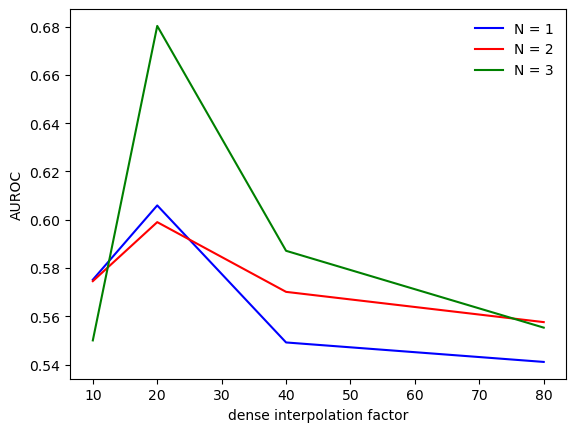

In [83]:
x = [10, 20, 40, 80]
y1 = [0.5751940298507463,
 0.605955223880597,
 0.5492238805970149,0.5411641791044776]
y2 = [0.5745970149253732,
 0.5990298507462687,
 0.5701641791044776,
 0.5576417910447761]
y3 = [0.5500746268656717,
 0.6802537313432836,
 0.5871641791044776,
 0.5553582089552239]

# Plot the data and set the line colors and labels
plt.plot(x, y1, color='blue', label='N = 1')
plt.plot(x, y2, color='red', label='N = 2')
plt.plot(x, y3, color='green', label='N = 3')

# Add a legend with the line colors
plt.legend(frameon=False)
plt.xlabel("dense interpolation factor") 
plt.ylabel("AUROC")

# Show the plot
plt.show()